# Project Based
**CONTEXT**: A complex modern semiconductor manufacturing process is normally under constant surveillance via the monitoring of signals/variables collected from sensors and/or process measurement points. However, not all of these signals are equally valuable in a specific monitoring system. The measured signals contain a combination of useful information, irrelevant information as well as noise. Engineers typically have a much larger number of signals than are actually required. If we consider each type of signal as a feature, then feature selection may be applied to identify the most relevant signals. The Process Engineers may then use these signals to determine key factors contributing to yield excursions downstream in the process. This will enable an increase in process throughput, decreased time to learning and reduce the per unit production costs. These signals can be used as features to predict the yield type. And by analysing and trying out different combinations of features, essential signals that are impacting the yield type can be identified.

**DATA DESCRIPTION**: `sensor-data.csv` : (1567, 592)
The data consists of **1567** examples each with **591** features. The dataset presented in this case represents a selection of such features where each example represents a single production entity with associated measured features and the labels represent a simple pass/fail yield for in house line testing. Target column **–1** corresponds to a **pass** and **1** corresponds to a **fail** and the data time stamp is for that specific test point.

**PROJECT OBJECTIVE**: We will build a classifier to predict the Pass/Fail yield of a particular process entity and analyse whether all the 
features are required to build the model or not.

## Importing the libraries

In [1]:
import numpy as np # mathematical manipulations
import pandas as pd # data manipulations

# for visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

# pre-processing of data
from scipy.stats import zscore # for standardising the scale
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.preprocessing import binarize

from sklearn.decomposition import PCA # reduction technique

# splitting into train and test sets and searching for hyperparameter tuning and cross validations
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV, StratifiedKFold,cross_val_score,KFold

# ML model libraries
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# various model performance measures
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,f1_score,precision_recall_fscore_support,roc_curve,auc

# sampling techniques
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# uncomment these to see whole data
# pd.set_option('max_columns',None)
# pd.set_option('max_rows',None)

## Import and warehouse data

In [2]:
# importing data to a data frame from csv
signal_df = pd.read_csv('signal-data.csv')

In [3]:
# checking top five rows to see if data is imported
signal_df.head()

Time        0        1          2          3       4      5  \
0  2008-07-19 11:55:00  3030.93  2564.00  2187.7333  1411.1265  1.3602  100.0   
1  2008-07-19 12:32:00  3095.78  2465.14  2230.4222  1463.6606  0.8294  100.0   
2  2008-07-19 13:17:00  2932.61  2559.94  2186.4111  1698.0172  1.5102  100.0   
3  2008-07-19 14:43:00  2988.72  2479.90  2199.0333   909.7926  1.3204  100.0   
4  2008-07-19 15:22:00  3032.24  2502.87  2233.3667  1326.5200  1.5334  100.0   

          6       7       8  ...       581     582     583     584      585  \
0   97.6133  0.1242  1.5005  ...       NaN  0.5005  0.0118  0.0035   2.3630   
1  102.3433  0.1247  1.4966  ...  208.2045  0.5019  0.0223  0.0055   4.4447   
2   95.4878  0.1241  1.4436  ...   82.8602  0.4958  0.0157  0.0039   3.1745   
3  104.2367  0.1217  1.4882  ...   73.8432  0.4990  0.0103  0.0025   2.0544   
4  100.3967  0.1235  1.5031  ...       NaN  0.4800  0.4766  0.1045  99.3032   

      586     587     588       589  Pass/Fail  
0     NaN     NaN     NaN       NaN         -1  
1  0.0096  0.0201  0.0060  208.2045         -1  
2  0.0584  0.0484  0.0148   82.8602          1  
3  0.0202  0.0149  0.0044   73.8432         -1  
4  0.0202  0.0149  0.0044   73.8432         -1  

[5 rows x 592 columns]

In [4]:
# analysing shape of the dataframe
signal_df.shape

(1567, 592)

In [5]:
# seeing shape and data types of various features
signal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass/Fail
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB


#### Observations:
- The data has been imported successfully from the `csv`.
- The dataset has **1567** datapoints, **591** independant features and **1** target variable.
- Before manipulating the original dataframe, we will make a copy of it to keep original data intact.

In [6]:
# copying the df
signal = signal_df.copy()

## Data Cleansing

In [7]:
# checking for missing values
signal.isnull().sum()

Time          0
0             6
1             7
2            14
3            14
             ..
586           1
587           1
588           1
589           1
Pass/Fail     0
Length: 592, dtype: int64

In [8]:
# checking for null across all features in each row
signal.isnull().any(axis=1).sum()

1567

### Observations:
- **1567** rows have atleast one `null` in one or the other feature in them.
- We cannot simply use `dropna()`, because that will empty the whole dataframe and all information will be lost.
- Drop all those rows for which **all** the datapoints for all the features are `null` because those datapoints would not help in any model and can't be imputed so randomly.
- Drop `Time` feature, because it won't help in model building.
- Drop `duplicates` from the df.
- Drop all those features for which the `std()` is **zero**, as it won't bring any variance to models as they are constant signals.

In [9]:
# dropping datapoints where all the features are null
signal.dropna(how='all',inplace=True)

In [10]:
# dropping Time feature
signal.drop(['Time'],axis=1,inplace=True)

In [11]:
# dropping duplicated rows
signal.drop_duplicates(inplace=True)

In [12]:
# dropping the columns the have constant signal
numeric_cols = signal.select_dtypes([np.number]).columns # selecting number column names 
std = signal[numeric_cols].std() # calculating standard deviation of each column
cols_to_drop = std[std==0].index # logical filtering for std=0
signal.drop(cols_to_drop, axis=1,inplace=True) # dropping the constant columns
signal.shape

(1567, 475)

### Observations:
- **16** features where dropped because of constant signal.
- Now the dataset has **1567** datapoints, **474** independant features and **1** target variable.
- Replacing all `NaN` with **0** as it has no signal in them.

In [13]:
# replacing the NaN with zero and considering it as no signal
signal.fillna(0,inplace=True)

## Data Analysis and Visualisation

In [14]:
# 5-point summary and other statistical features of all features
signal.describe(include='all').transpose()

count         mean         std     min         25%        50%  \
0          1567.0  3002.910638  200.204648  0.0000  2965.67000  3010.9200   
1          1567.0  2484.700932  184.815753  0.0000  2451.51500  2498.9100   
2          1567.0  2180.887035  209.206773  0.0000  2180.70000  2200.9556   
3          1567.0  1383.901023  458.937272  0.0000  1080.11605  1283.4368   
4          1567.0     4.159516   56.104457  0.0000     1.01100     1.3101   
...           ...          ...         ...     ...         ...        ...   
586        1567.0     0.021445    0.012366 -0.0169     0.01340     0.0205   
587        1567.0     0.016464    0.008815  0.0000     0.01060     0.0148   
588        1567.0     0.005280    0.002869  0.0000     0.00330     0.0046   
589        1567.0    99.606461   93.895701  0.0000    44.36860    71.7780   
Pass/Fail  1567.0    -0.867262    0.498010 -1.0000    -1.00000    -1.0000   

                 75%        max  
0          3056.5400  3356.3500  
1          2538.7450  2846.4400  
2          2218.0555  2315.2667  
3          1590.1699  3715.0417  
4             1.5188  1114.5366  
...              ...        ...  
586           0.0276     0.1028  
587           0.0203     0.0799  
588           0.0064     0.0286  
589         114.7497   737.3048  
Pass/Fail    -1.0000     1.0000  

[475 rows x 8 columns]

In [15]:
def pie_chart_and_count_plot(df,col_name):
    # initialising subplots
    figure, ax = plt.subplots(nrows=1, ncols=2)

    # setting figure parameters
    figure.set_figheight(7)
    figure.set_figwidth(15)
    
    #setting axes titles
    ax[0].set_title(f'Pie Chart of {col_name.upper()}')
    ax[1].set_title(f'Count plot of {col_name.upper()}')

    # plotting the distribution
    df[col_name].value_counts().plot.pie(ax=ax[0],autopct='%1.1f%%')
    sns.countplot(x=col_name,data=df,ax=ax[1])

    plt.show()

In [16]:
def calculateLowerAndUpperFence(df,col_name):
    Q1 = np.percentile(a=df[col_name],q=25) # 25th percentile
    Q3 = np.percentile(a=df[col_name],q=75) # 75th percentile
    IQR = Q3 - Q1 # inter-quartile-range
    cut_off = 1.5 * IQR
    # limit for outliers
    lower_fence = Q1 - cut_off
    upper_fence = Q3 + cut_off
    return lower_fence,upper_fence

In [17]:
def number_of_outliers(df,col_name,lower_fence,upper_fence):
    outliers = np.where((df[col_name] < lower_fence) | (df[col_name] > upper_fence))
    number_of_outliers = len(outliers[0])
    return number_of_outliers

In [18]:
def plotHistogramAndBoxPlotWithOutliers(df,col_name, outlier_col):
    # initialising subplots
    figure, ax = plt.subplots(nrows=1, ncols=2)

    # setting figure parameters
    figure.set_figheight(5)
    figure.set_figwidth(15)

    #setting axes titles
    ax[0].set_title(f'Distribution plot of feature:: {col_name.upper()}')
    ax[1].set_title(f'Box plot of feature number:: {col_name.upper()}')

    # plotting the distribution
    sns.histplot(data=df[col_name],ax=ax[0],kde=True,color='g')
    sns.boxplot(x=df[col_name],ax=ax[1])

    plt.show()

    # figuring upper and lower limits
    lower_fence,upper_fence = calculateLowerAndUpperFence(df,col_name)

    # logical selection of outliers
    no_of_outliers = number_of_outliers(df,col_name,lower_fence,upper_fence)
    if no_of_outliers > 0:
        outlier_col.append(col_name)
        print(f'The number of outliers for feature:: {col_name} are {no_of_outliers}')

### Observations:
- As we know it's not realistic to plot distributions for all **475** features, we will restrict our visualistion to `first 50` features.

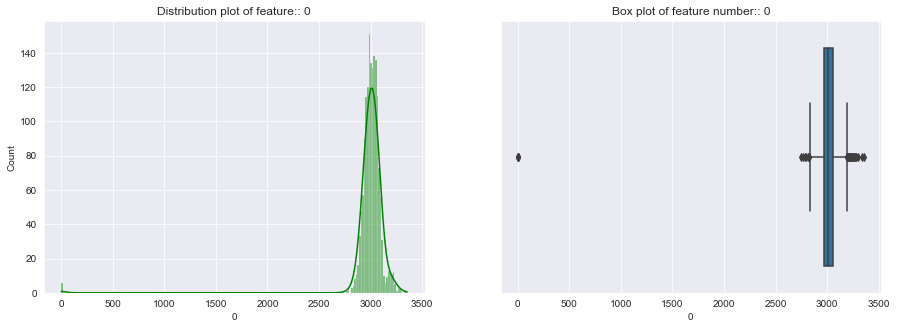

The number of outliers for feature:: 0 are 55
****************************************


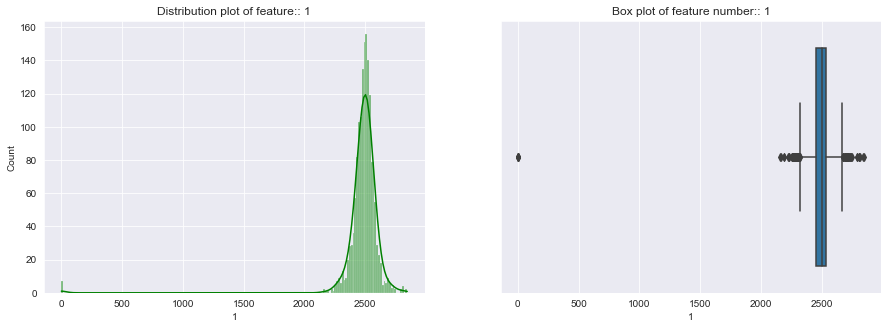

The number of outliers for feature:: 1 are 91
****************************************


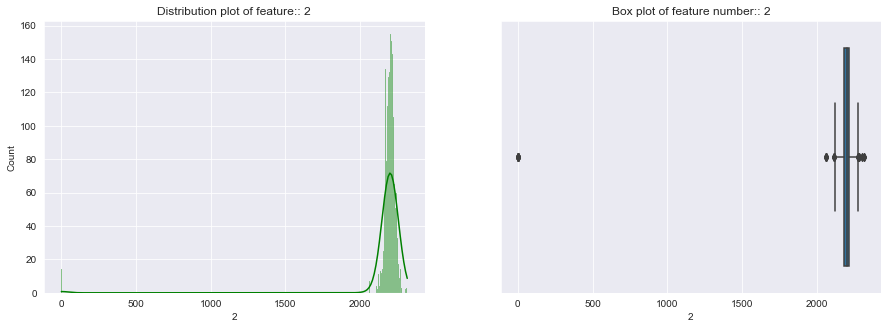

The number of outliers for feature:: 2 are 39
****************************************


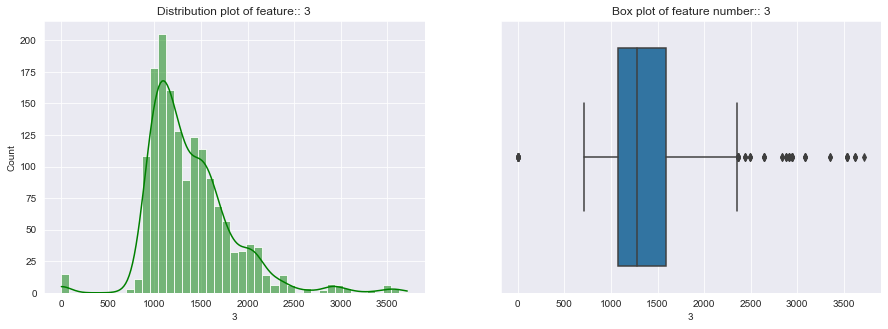

The number of outliers for feature:: 3 are 65
****************************************


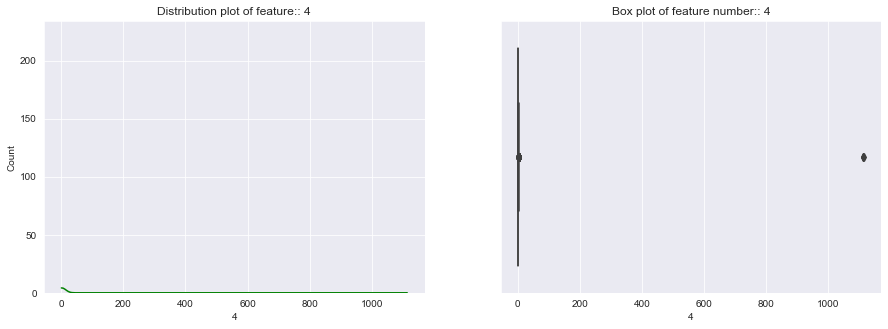

The number of outliers for feature:: 4 are 62
****************************************


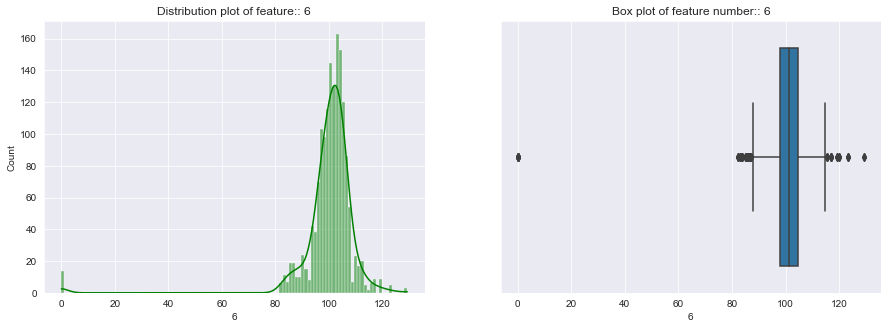

The number of outliers for feature:: 6 are 108
****************************************


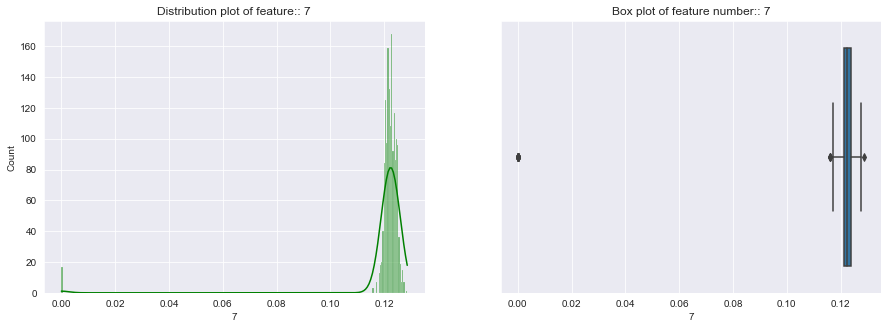

The number of outliers for feature:: 7 are 21
****************************************


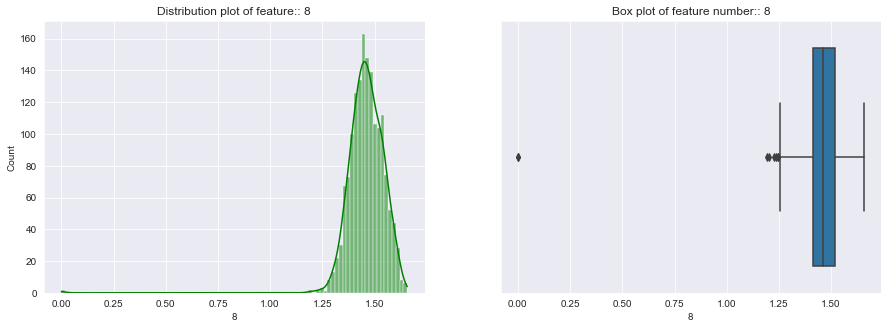

The number of outliers for feature:: 8 are 8
****************************************


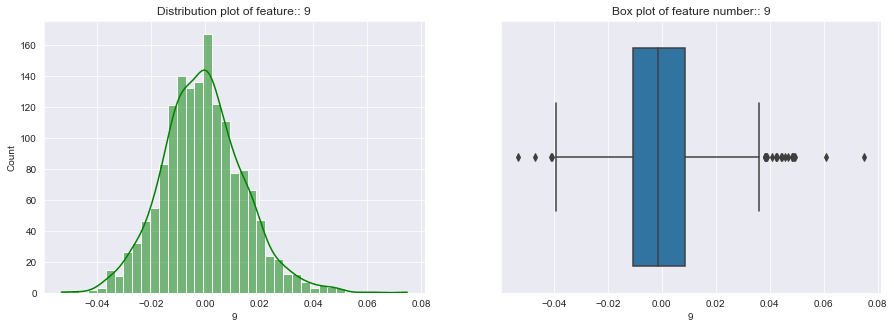

The number of outliers for feature:: 9 are 26
****************************************


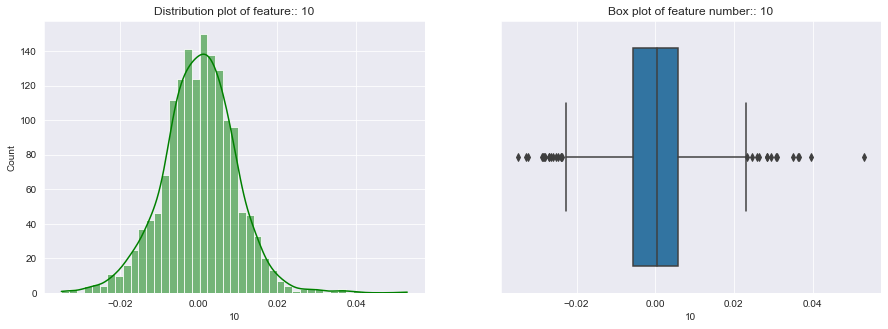

The number of outliers for feature:: 10 are 30
****************************************


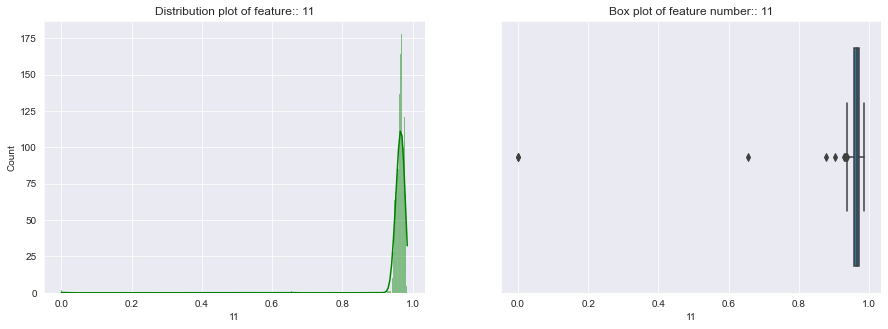

The number of outliers for feature:: 11 are 9
****************************************


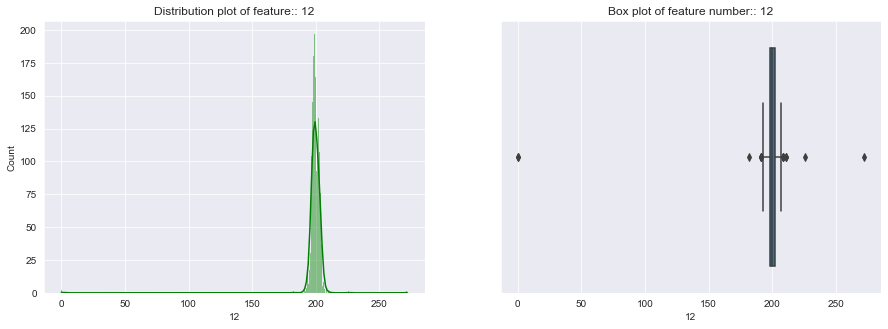

The number of outliers for feature:: 12 are 14
****************************************


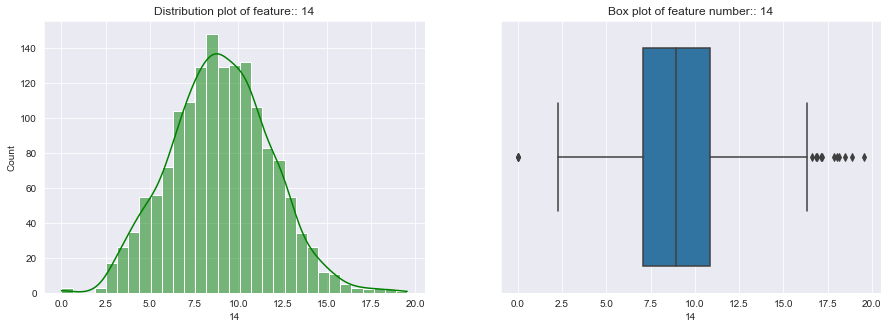

The number of outliers for feature:: 14 are 14
****************************************


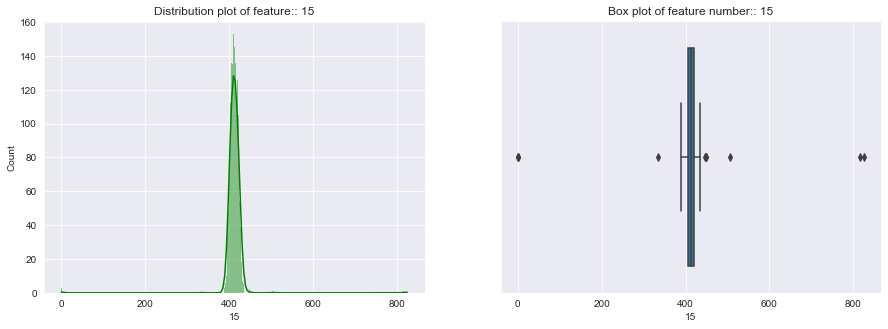

The number of outliers for feature:: 15 are 10
****************************************


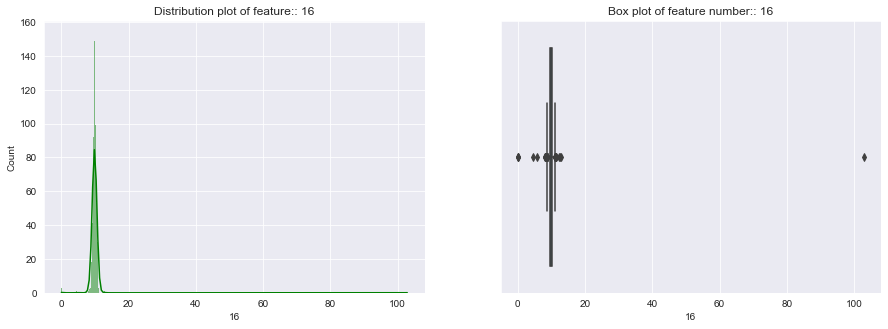

The number of outliers for feature:: 16 are 37
****************************************


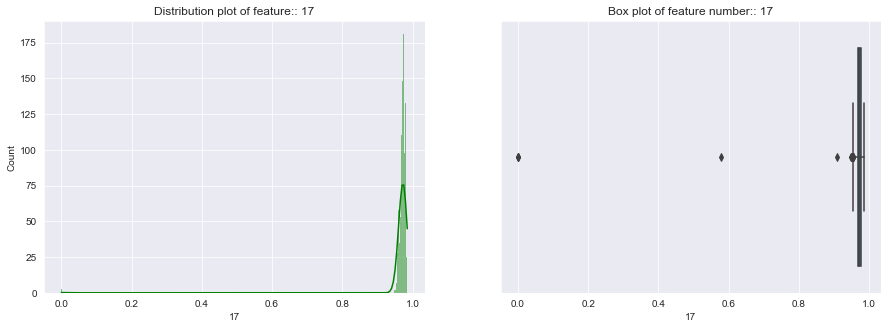

The number of outliers for feature:: 17 are 18
****************************************


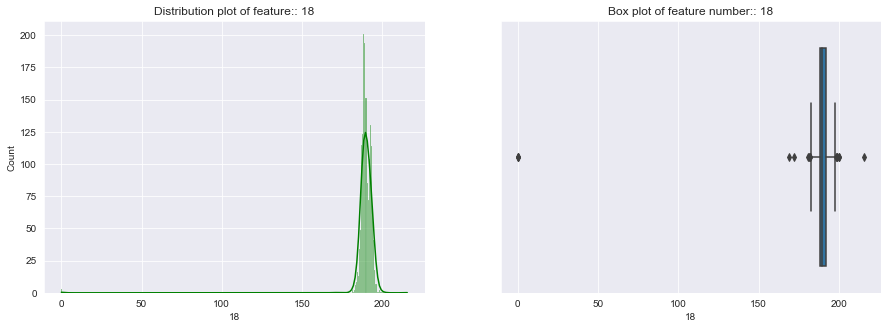

The number of outliers for feature:: 18 are 15
****************************************


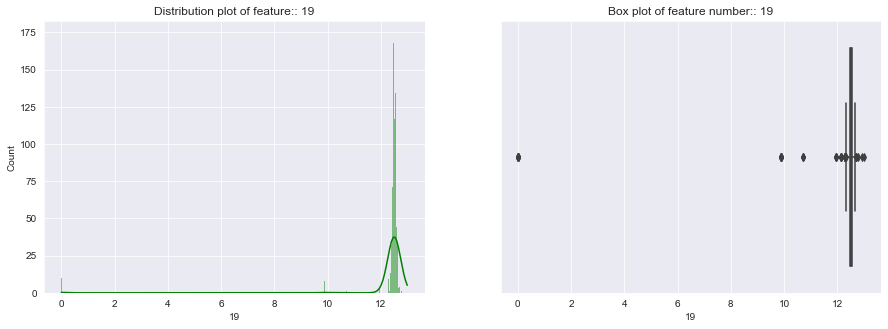

The number of outliers for feature:: 19 are 56
****************************************


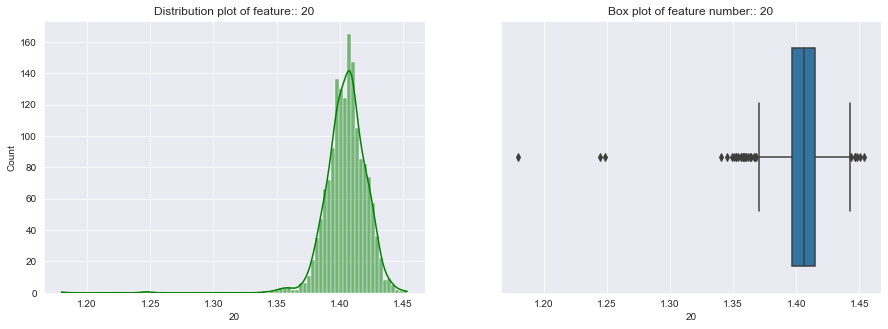

The number of outliers for feature:: 20 are 29
****************************************


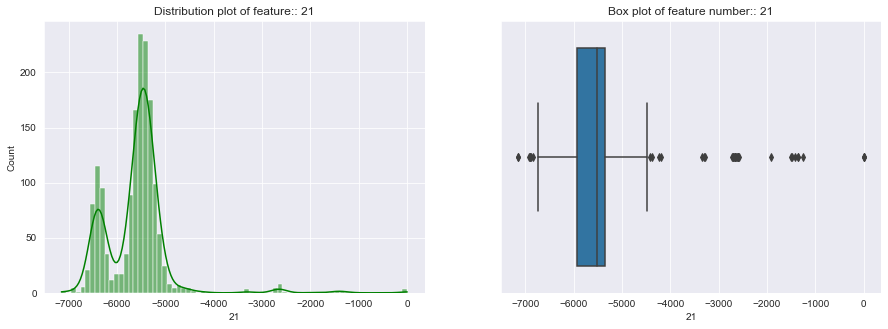

The number of outliers for feature:: 21 are 37
****************************************


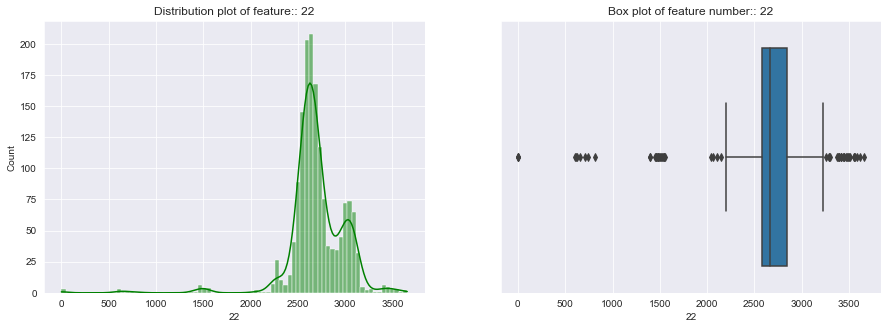

The number of outliers for feature:: 22 are 55
****************************************


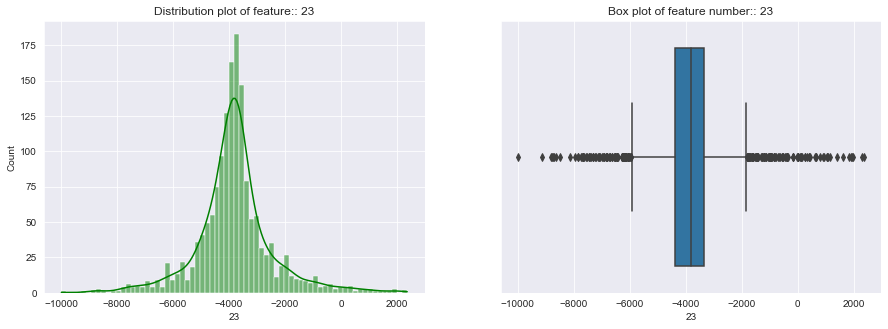

The number of outliers for feature:: 23 are 195
****************************************


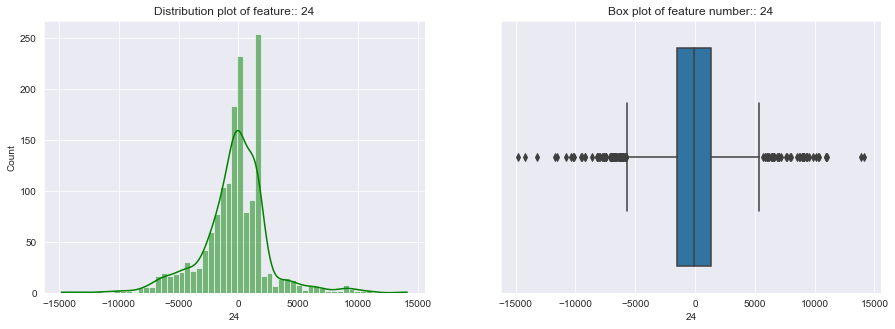

The number of outliers for feature:: 24 are 122
****************************************


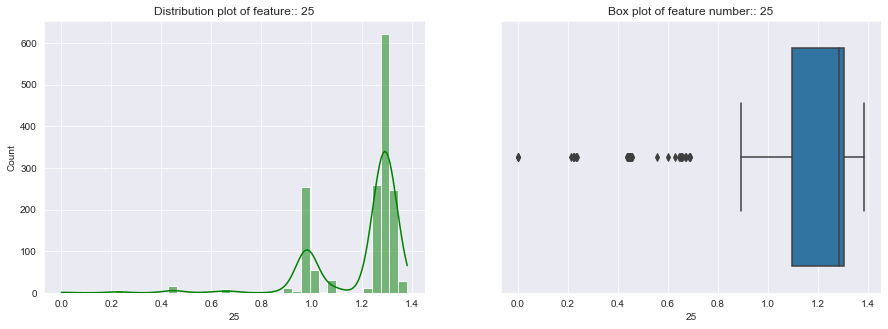

The number of outliers for feature:: 25 are 41
****************************************


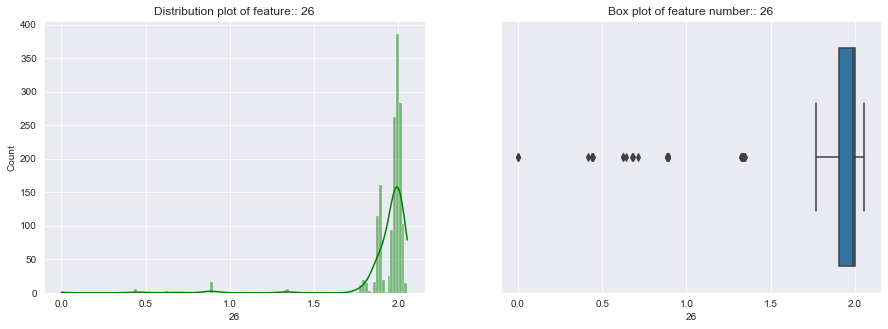

The number of outliers for feature:: 26 are 41
****************************************


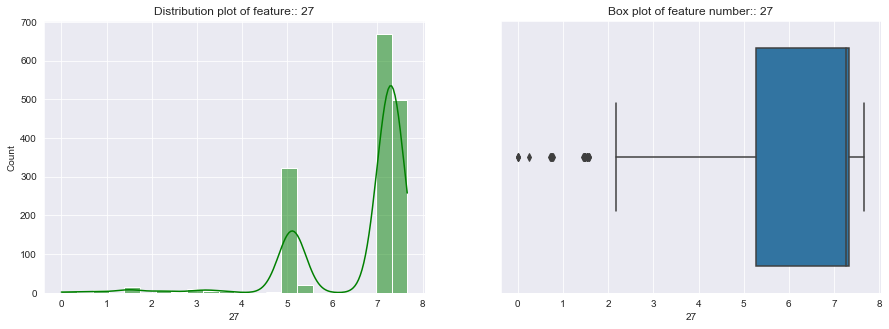

The number of outliers for feature:: 27 are 26
****************************************


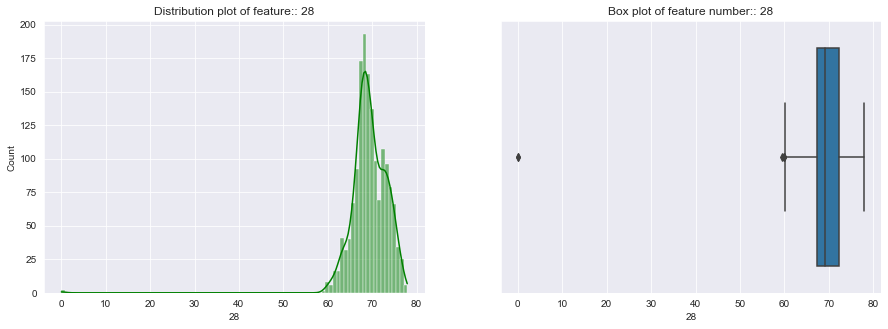

The number of outliers for feature:: 28 are 7
****************************************


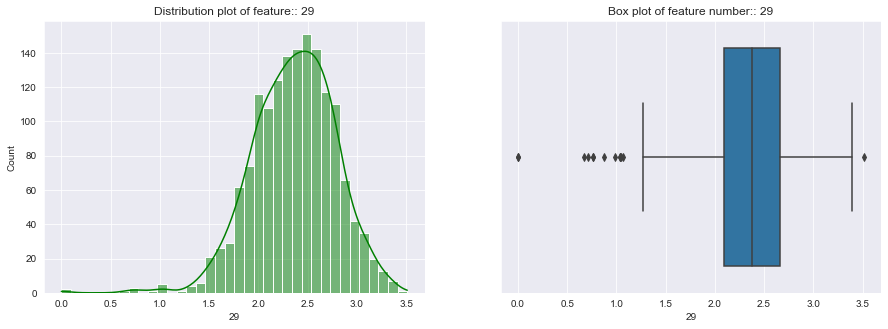

The number of outliers for feature:: 29 are 13
****************************************


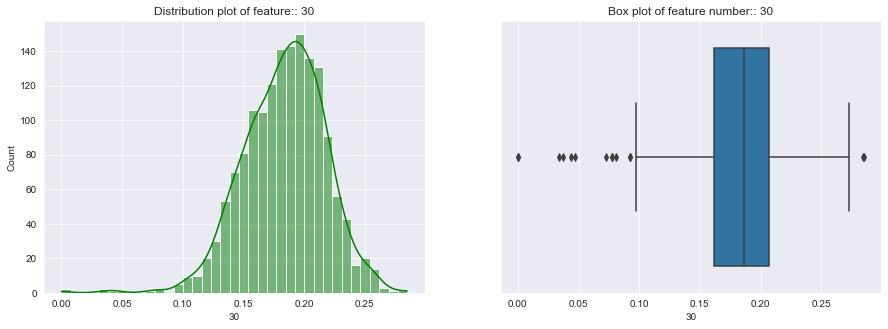

The number of outliers for feature:: 30 are 14
****************************************


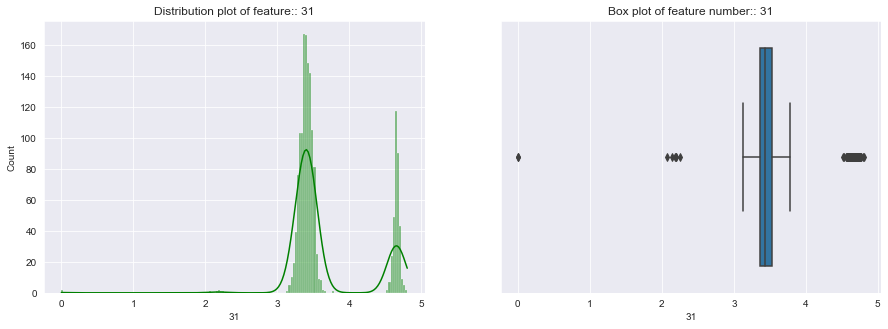

The number of outliers for feature:: 31 are 356
****************************************


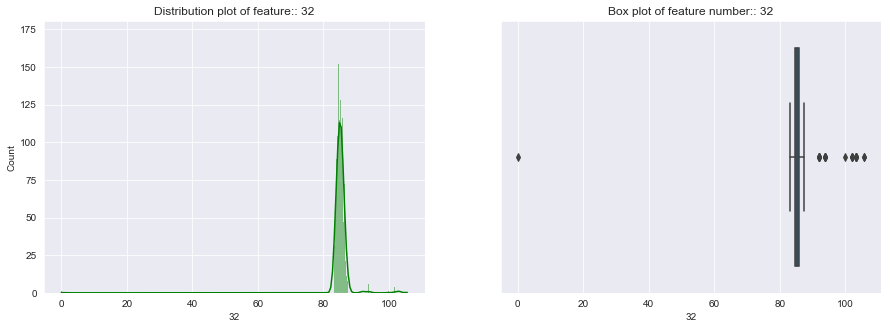

The number of outliers for feature:: 32 are 28
****************************************


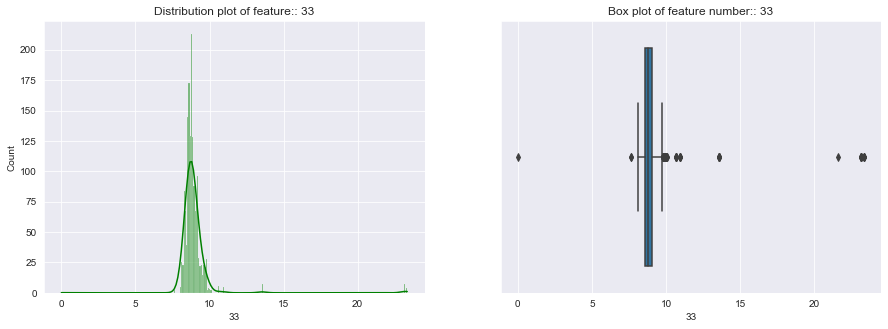

The number of outliers for feature:: 33 are 55
****************************************


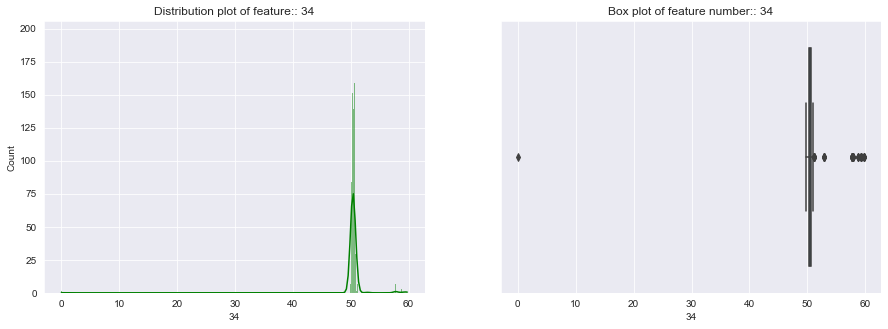

The number of outliers for feature:: 34 are 47
****************************************


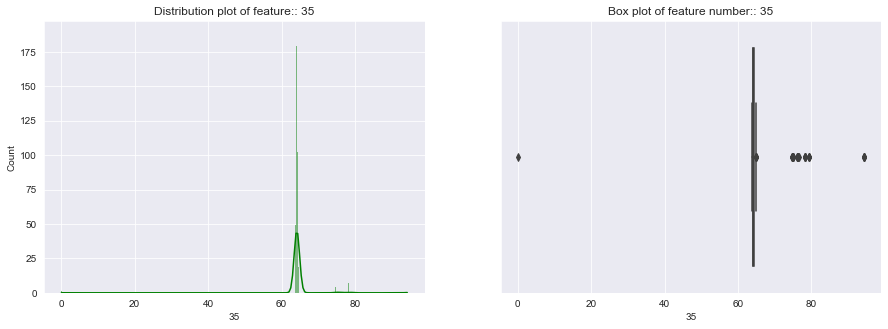

The number of outliers for feature:: 35 are 44
****************************************


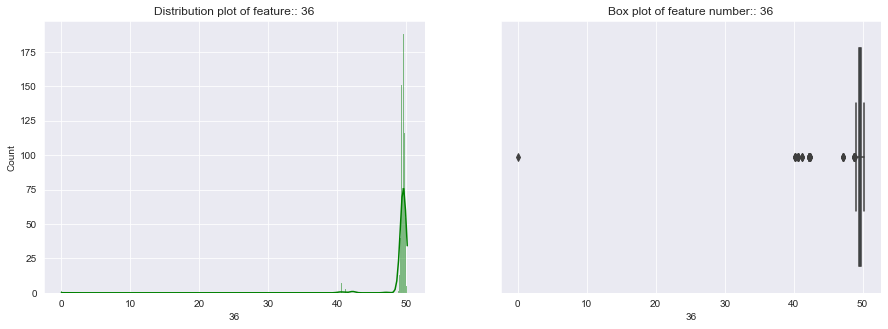

The number of outliers for feature:: 36 are 47
****************************************


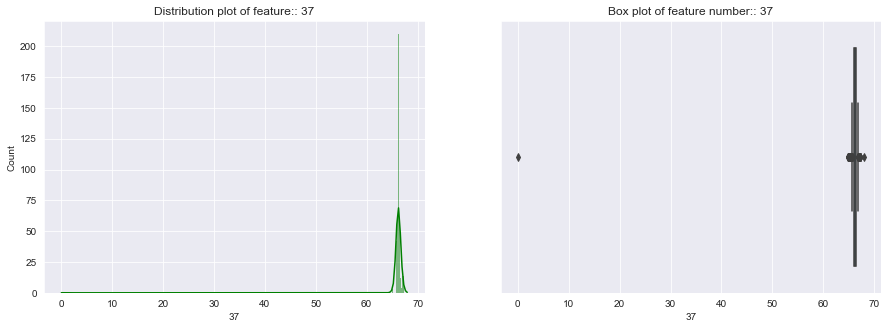

The number of outliers for feature:: 37 are 100
****************************************


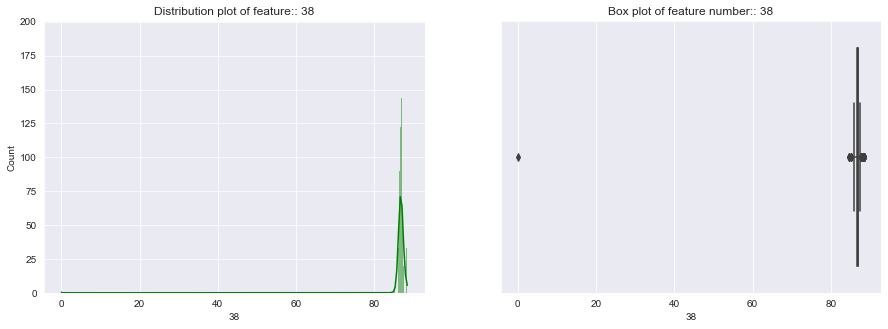

The number of outliers for feature:: 38 are 86
****************************************


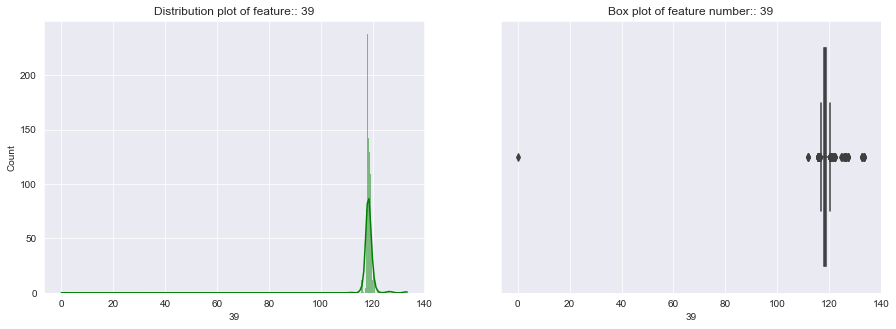

The number of outliers for feature:: 39 are 140
****************************************


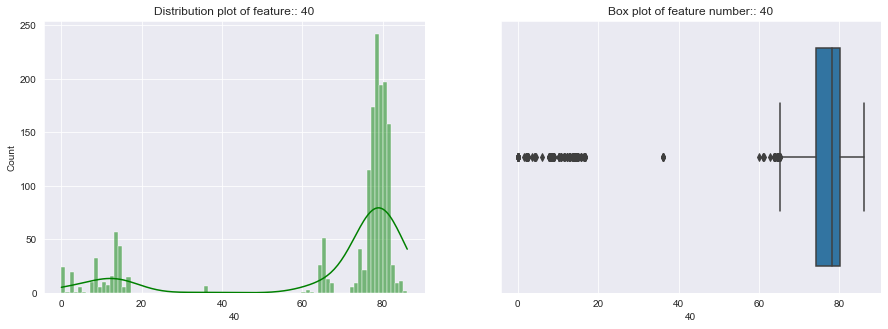

The number of outliers for feature:: 40 are 313
****************************************


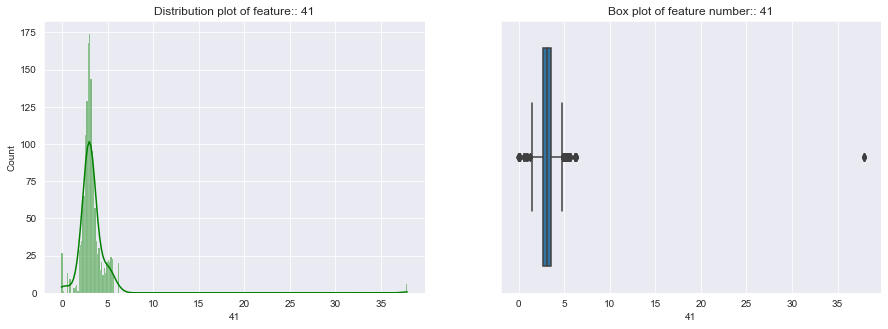

The number of outliers for feature:: 41 are 214
****************************************


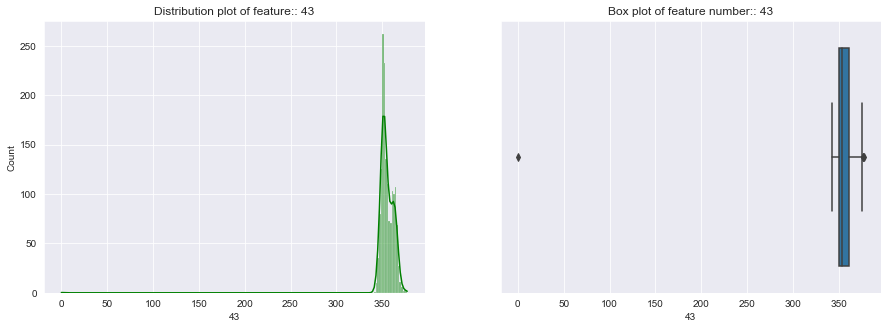

The number of outliers for feature:: 43 are 4
****************************************


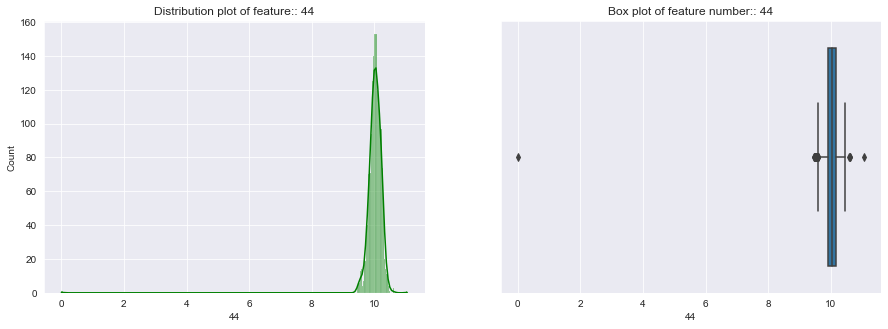

The number of outliers for feature:: 44 are 34
****************************************


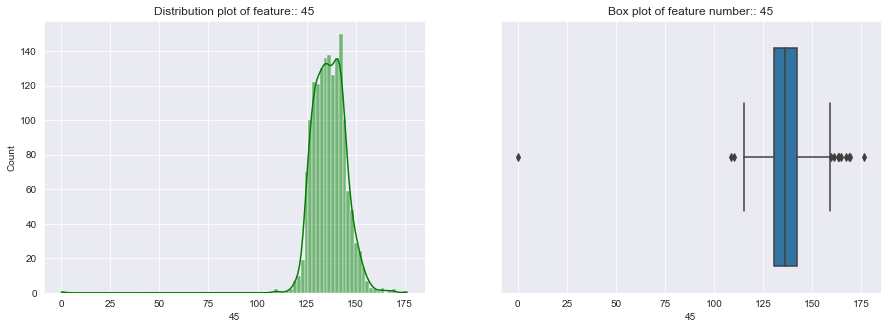

The number of outliers for feature:: 45 are 12
****************************************


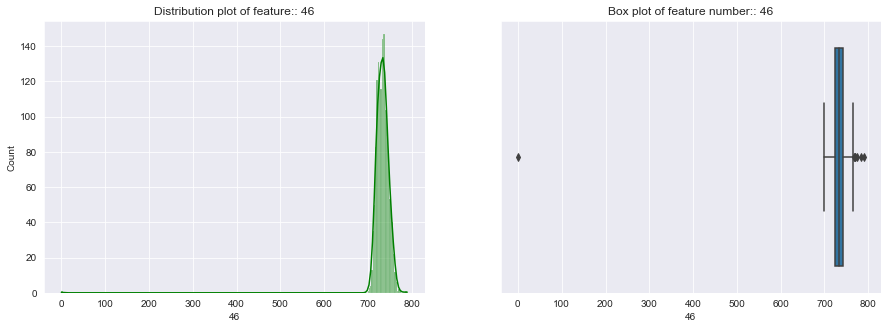

The number of outliers for feature:: 46 are 7
****************************************


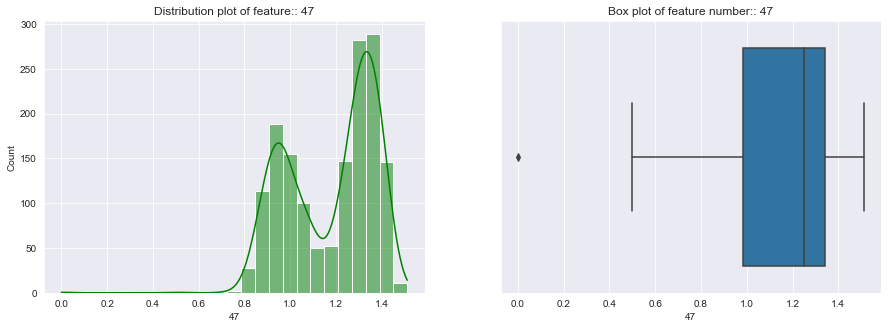

The number of outliers for feature:: 47 are 1
****************************************


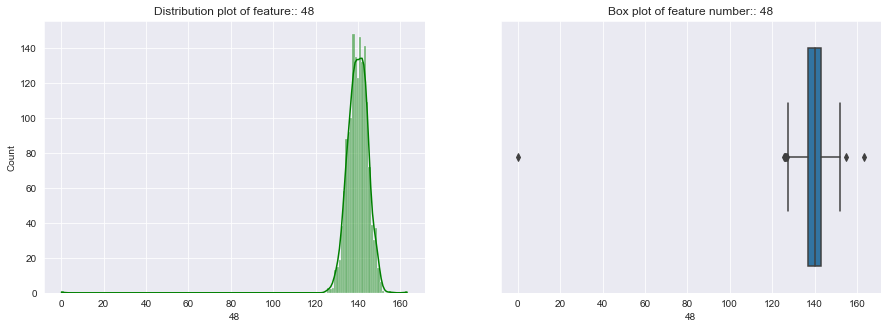

The number of outliers for feature:: 48 are 8
****************************************


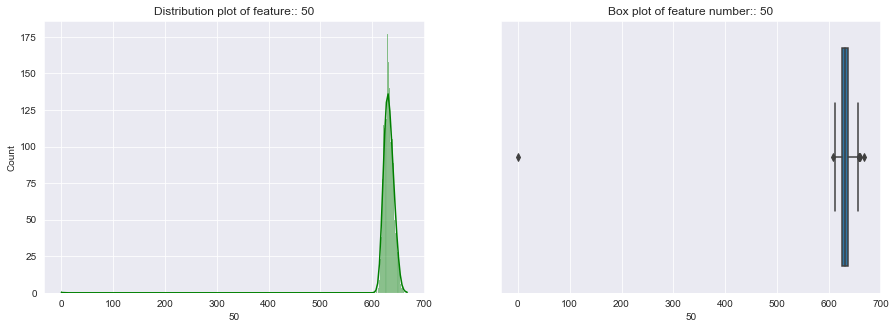

The number of outliers for feature:: 50 are 9
****************************************


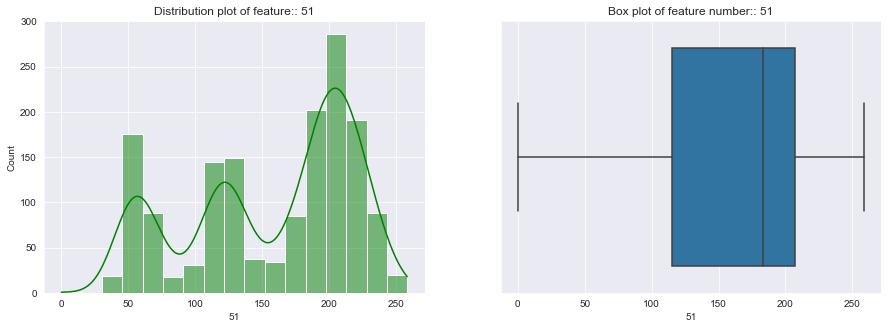

****************************************


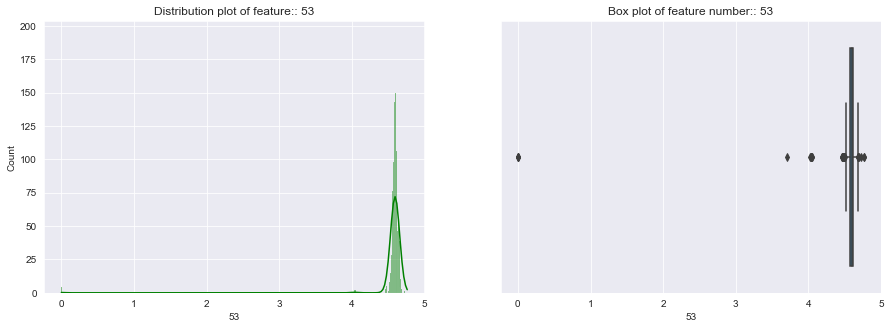

The number of outliers for feature:: 53 are 33
****************************************


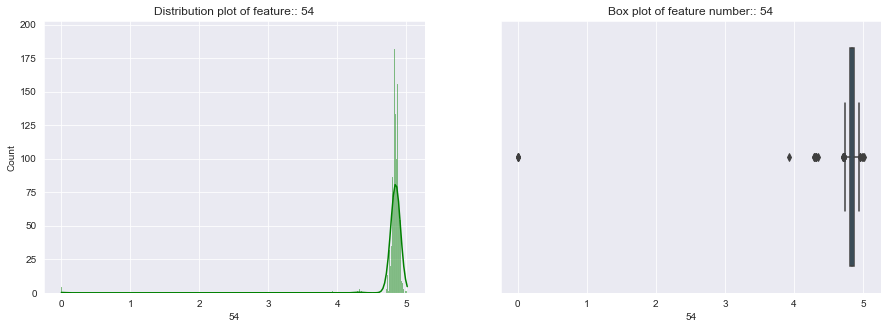

The number of outliers for feature:: 54 are 35
****************************************


In [19]:
numeric_features = signal.select_dtypes([np.number]).columns
outlier_cols = [] # initialising list to hold outlier columns
for col in numeric_features[0:50]:
    if col != 'Pass/Fail':
        plotHistogramAndBoxPlotWithOutliers(signal,col,outlier_cols) # call to appropriate function
        print('*'*40)

In [20]:
# calculating outliers for all the features
outlier_cols = [] # initialising list to hold outlier columns
for col_name in numeric_features:
    if col_name != 'Pass/Fail':
        # figuring upper and lower limits
        lower_fence,upper_fence = calculateLowerAndUpperFence(signal,col_name)

        # logical selection of outliers
        no_of_outliers = number_of_outliers(signal,col_name,lower_fence,upper_fence)
        if no_of_outliers > 0:
            outlier_cols.append(col_name)

In [21]:
len(outlier_cols)

452

### Observations:
From `describe()` and the visual analysis we could observe:

- The **5-point** summary of all `numeric` features.
- The distribution of many features is `skewed`.
- The distribution of many features is `normal`.
- The distribution of many features is `multi-modal`.
- There are **452** features with `outliers`.

### Observations:
- As it is not realistic to plot a `scatter plot` or a `heatmap` for all the features, we will only concentrate on features whose `absolute correlation` is **high(say 0.7 or more)**.
- As our features should be **independant** of one another for the models to perform well, we can pre-process highly correlated features:
    + Drop highly correlated features based on `domain knowledge` or keep feature with `lower errors`, because the information from that feature is already contained in the other feature.
    + Make **composite** features out of highly correlated features.

In [22]:
corr = signal.corr() # finding the correlation matrix
corr

0         1         2         3         4         6  \
0          1.000000 -0.047782  0.007590  0.009448 -0.000915  0.006129   
1         -0.047782  1.000000 -0.030448  0.006021  0.002192 -0.031616   
2          0.007590 -0.030448  1.000000  0.323782  0.020438  0.818770   
3          0.009448  0.006021  0.323782  1.000000 -0.054015 -0.119180   
4         -0.000915  0.002192  0.020438 -0.054015  1.000000 -0.034736   
...             ...       ...       ...       ...       ...       ...   
586        0.044745 -0.009219  0.015733  0.038755 -0.043693 -0.005877   
587        0.005233  0.039479 -0.007090 -0.038371 -0.030930  0.016362   
588        0.003918  0.040500 -0.009122 -0.033648 -0.026046  0.013832   
589        0.021489  0.044464 -0.030434 -0.084449  0.050741  0.002246   
Pass/Fail  0.006149 -0.019672  0.024929 -0.016341 -0.013577  0.030075   

                  7         8         9        10  ...       581       582  \
0          0.010738 -0.050979  0.009959 -0.010253  ... -0.033622  0.010503   
1         -0.025086  0.027609  0.003704  0.028889  ...  0.043107 -0.017392   
2          0.747230  0.002600 -0.045731  0.004713  ...  0.038416 -0.010627   
3          0.279646 -0.108217  0.051567  0.046281  ...  0.000922  0.009788   
4         -0.475861 -0.020082  0.053859 -0.006505  ...  0.107783  0.012778   
...             ...       ...       ...       ...  ...       ...       ...   
586        0.051943  0.017642  0.032423  0.000758  ... -0.206109 -0.008240   
587       -0.006335  0.027655  0.057856  0.047377  ...  0.227096  0.018981   
588       -0.014288  0.033729  0.059321  0.046459  ...  0.216292  0.019083   
589       -0.067263 -0.016895  0.004106  0.008651  ...  0.431632  0.028502   
Pass/Fail  0.023590  0.028376 -0.031209  0.033645  ...  0.003478  0.018736   

                583       584       585       586       587       588  \
0          0.019840  0.017889  0.019522  0.044745  0.005233  0.003918   
1          0.003809  0.004409  0.003821 -0.009219  0.039479  0.040500   
2         -0.004771 -0.003030 -0.004263  0.015733 -0.007090 -0.009122   
3          0.022593  0.022361  0.023288  0.038755 -0.038371 -0.033648   
4         -0.001323 -0.001605 -0.001636 -0.043693 -0.030930 -0.026046   
...             ...       ...       ...       ...       ...       ...   
586        0.002391  0.001602  0.002872  1.000000  0.169634  0.165942   
587       -0.001809 -0.001696 -0.002122  0.169634  1.000000  0.974332   
588       -0.001445 -0.001182 -0.001746  0.165942  0.974332  1.000000   
589       -0.002453 -0.002750 -0.003266 -0.484741  0.391503  0.389898   
Pass/Fail  0.006131  0.005593  0.005179  0.004448  0.035670  0.031447   

                589  Pass/Fail  
0          0.021489   0.006149  
1          0.044464  -0.019672  
2         -0.030434   0.024929  
3         -0.084449  -0.016341  
4          0.050741  -0.013577  
...             ...        ...  
586       -0.484741   0.004448  
587        0.391503   0.035670  
588        0.389898   0.031447  
589        1.000000  -0.002472  
Pass/Fail -0.002472   1.000000  

[475 rows x 475 columns]

## NOTE:: My laptop processing is not allowing me to visualise such plots. We can anytime uncomment the below snippets to visualise the facts.

In [23]:
# # visualisation of correlation matrix
# plt.figure(figsize=(20,8))
# sns.heatmap(abs(corr>0.8), annot=True)
# plt.show()

In [24]:
# # pairwise scatter plots and the distributions
# sns.pairplot(data=signal.iloc[:,:10],diag_kind='kde') 
# plt.show()

## Data pre-processing

### Observations:
- Imputing values in `outlier_cols` by bringing values lower than `lower_fence` upto `lower_fence` and values higher than `upper_fence` upto `upper_fence`.
    + I chose this approach of correcting `outliers` rather than imputimg to `mean`, `median` or `zero`, because those would change **concentration/distribution** of data and also outliers are more similar to the boundary elements.

In [25]:
def pull_outliers_to_quartile_limits(df,outlier_cols):
    for col_name in outlier_cols:
        lower_fence,upper_fence = calculateLowerAndUpperFence(df,col_name)
        print(f'The number of outliers for {col_name} before imputing are {number_of_outliers(df,col_name,lower_fence,upper_fence)}')

        col_index = df.columns.get_loc(col_name)
        # imputing values lower than lower fence equal to lower fence
        for row_index in np.where(df[col_name] < lower_fence)[0]:
            df.iloc[[row_index],[col_index]] = lower_fence

        # imputing values higher than upper fence equal to upper fence
        for row_index in np.where(df[col_name] > upper_fence)[0]:
            df.iloc[[row_index],[col_index]] = upper_fence
        
        print(f'The number of outliers for {col_name} after imputing are {number_of_outliers(df,col_name,lower_fence,upper_fence)}')
        print()

In [26]:
pull_outliers_to_quartile_limits(signal,outlier_cols)  # call to appropriate function

The number of outliers for 0 before imputing are 55
The number of outliers for 0 after imputing are 0

The number of outliers for 1 before imputing are 91
The number of outliers for 1 after imputing are 0

The number of outliers for 2 before imputing are 39
The number of outliers for 2 after imputing are 0

The number of outliers for 3 before imputing are 65
The number of outliers for 3 after imputing are 0

The number of outliers for 4 before imputing are 62
The number of outliers for 4 after imputing are 0

The number of outliers for 6 before imputing are 108
The number of outliers for 6 after imputing are 0

The number of outliers for 7 before imputing are 21
The number of outliers for 7 after imputing are 0

The number of outliers for 8 before imputing are 8
The number of outliers for 8 after imputing are 0

The number of outliers for 9 before imputing are 26
The number of outliers for 9 after imputing are 0

The number of outliers for 10 before imputing are 30
The number of outlie

The number of outliers for 95 before imputing are 54
The number of outliers for 95 after imputing are 0

The number of outliers for 96 before imputing are 72
The number of outliers for 96 after imputing are 0

The number of outliers for 98 before imputing are 80
The number of outliers for 98 after imputing are 0

The number of outliers for 99 before imputing are 50
The number of outliers for 99 after imputing are 0

The number of outliers for 100 before imputing are 37
The number of outliers for 100 after imputing are 0

The number of outliers for 101 before imputing are 61
The number of outliers for 101 after imputing are 0

The number of outliers for 102 before imputing are 63
The number of outliers for 102 after imputing are 0

The number of outliers for 103 before imputing are 30
The number of outliers for 103 after imputing are 0

The number of outliers for 104 before imputing are 46
The number of outliers for 104 after imputing are 0

The number of outliers for 105 before imputin

The number of outliers for 196 before imputing are 68
The number of outliers for 196 after imputing are 0

The number of outliers for 197 before imputing are 53
The number of outliers for 197 after imputing are 0

The number of outliers for 198 before imputing are 26
The number of outliers for 198 after imputing are 0

The number of outliers for 199 before imputing are 175
The number of outliers for 199 after imputing are 0

The number of outliers for 200 before imputing are 25
The number of outliers for 200 after imputing are 0

The number of outliers for 201 before imputing are 59
The number of outliers for 201 after imputing are 0

The number of outliers for 202 before imputing are 37
The number of outliers for 202 after imputing are 0

The number of outliers for 203 before imputing are 23
The number of outliers for 203 after imputing are 0

The number of outliers for 204 before imputing are 111
The number of outliers for 204 after imputing are 0

The number of outliers for 205 befo

The number of outliers for 303 before imputing are 20
The number of outliers for 303 after imputing are 0

The number of outliers for 305 before imputing are 3
The number of outliers for 305 after imputing are 0

The number of outliers for 306 before imputing are 90
The number of outliers for 306 after imputing are 0

The number of outliers for 307 before imputing are 22
The number of outliers for 307 after imputing are 0

The number of outliers for 308 before imputing are 37
The number of outliers for 308 after imputing are 0

The number of outliers for 309 before imputing are 22
The number of outliers for 309 after imputing are 0

The number of outliers for 310 before imputing are 26
The number of outliers for 310 after imputing are 0

The number of outliers for 311 before imputing are 6
The number of outliers for 311 after imputing are 0

The number of outliers for 312 before imputing are 234
The number of outliers for 312 after imputing are 0

The number of outliers for 316 before 

The number of outliers for 431 before imputing are 82
The number of outliers for 431 after imputing are 0

The number of outliers for 432 before imputing are 115
The number of outliers for 432 after imputing are 0

The number of outliers for 433 before imputing are 62
The number of outliers for 433 after imputing are 0

The number of outliers for 434 before imputing are 47
The number of outliers for 434 after imputing are 0

The number of outliers for 435 before imputing are 63
The number of outliers for 435 after imputing are 0

The number of outliers for 436 before imputing are 59
The number of outliers for 436 after imputing are 0

The number of outliers for 437 before imputing are 43
The number of outliers for 437 after imputing are 0

The number of outliers for 438 before imputing are 43
The number of outliers for 438 after imputing are 0

The number of outliers for 439 before imputing are 34
The number of outliers for 439 after imputing are 0

The number of outliers for 440 befor

The number of outliers for 559 before imputing are 12
The number of outliers for 559 after imputing are 0

The number of outliers for 560 before imputing are 85
The number of outliers for 560 after imputing are 0

The number of outliers for 561 before imputing are 9
The number of outliers for 561 after imputing are 0

The number of outliers for 562 before imputing are 279
The number of outliers for 562 after imputing are 0

The number of outliers for 563 before imputing are 286
The number of outliers for 563 after imputing are 0

The number of outliers for 564 before imputing are 42
The number of outliers for 564 after imputing are 0

The number of outliers for 565 before imputing are 74
The number of outliers for 565 after imputing are 0

The number of outliers for 566 before imputing are 46
The number of outliers for 566 after imputing are 0

The number of outliers for 567 before imputing are 82
The number of outliers for 567 after imputing are 0

The number of outliers for 568 befor

In [27]:
# making a copy of the dataset and dropping the target class
signal_without_target = signal.copy()
signal_without_target.drop(['Pass/Fail'],axis=1,inplace=True)

In [28]:
# Create correlation matrix
corr_matrix = signal_without_target.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.70
to_drop = [column for column in upper.columns if any(upper[column] > 0.70)]

# Drop features with high correlation
signal_without_target.drop(to_drop, axis=1, inplace=True)

In [29]:
signal_without_target.shape

(1567, 230)

### Observations:
- After dropping highly correlated features, we have **1567** datapoints and **230** features.

In [30]:
# label encoding the target class
signal['Pass/Fail'].replace({-1:0,1:1},inplace=True)

In [31]:
# concatenating df
signal = pd.concat([signal_without_target,signal['Pass/Fail']],axis=1)

In [32]:
# dropping null features
signal.dropna(axis=1,inplace=True)

In [33]:
# segregating into predictors and target variable
# predictors/independant features
X = signal.drop(['Pass/Fail'],axis=1)

# target feature
y = signal['Pass/Fail']

Values for Pass/Fail
0    1463
1     104
Name: Pass/Fail, dtype: int64



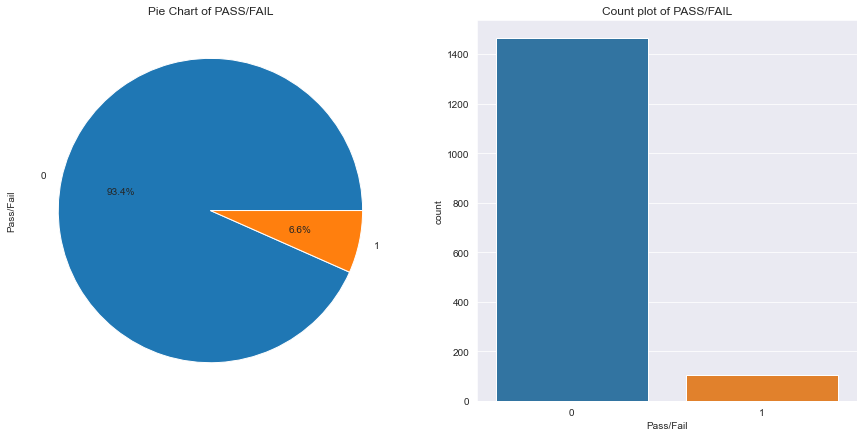

In [34]:
# checking for target classes imbalance
print('Values for Pass/Fail')
print(signal['Pass/Fail'].value_counts())
print()
pie_chart_and_count_plot(signal,'Pass/Fail') # call to plotting function

### Observations:
- As seen from above analysis, there is huge **imbalance** between the classes in the target variable.
- This should be fixed by bringing in balanced data for the target classes or there can be some techniques applied before building the model. If we do not treat the data before model building, the model will be more inclined to one of the target class than the other. Some techniques used are:
    + Use metrics like `precision`, `recall`, `F1-score`.
    + `Over-sampling` tries to balance dataset by increasing the size of rare samples, rather than getting rid of abundant samples using `SMOTE (Synthetic Minority Over-Sampling Technique)` or `Random Up Sampling`.
    + `Under-sampling` balances the dataset by reducing the size of the abundant class with `Tomek Links`, `Cluster Based Under Sampling`, `Random Under Sampling`.
- We will take care of imbalance while model building.

### Observations:
- **Classification models** generally work on **scaled** data, so will scale our independant features by `zscore`.

In [35]:
# random-state seed
seed = 1

In [36]:
# apply zscore
X_scaled = X.apply(zscore)

In [37]:
# dropping null features
X_scaled.dropna(axis=1,inplace=True)

In [38]:
final_X = X_scaled.copy()
final_y = y.copy()

In [39]:
# splitting data into train:test as 70:30
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.30,random_state=seed,stratify=y)

In [40]:
mean_df = pd.DataFrame()
mean_df['Mean of un-balanced train data'] = X_train.mean()
mean_df['Mean of test data'] = X_test.mean()
mean_df

Mean of un-balanced train data  Mean of test data
0                          0.010450          -0.024317
1                         -0.001135           0.002640
2                         -0.011119           0.025873
3                         -0.005363           0.012480
4                         -0.012472           0.029022
..                              ...                ...
582                        0.017113          -0.039822
583                       -0.030082           0.070000
586                        0.002190          -0.005096
587                       -0.023805           0.055393
589                       -0.004214           0.009807

[212 rows x 2 columns]

In [41]:
std_df = pd.DataFrame()
std_df['Std dev of un-balanced train data'] = X_train.std()
std_df['Std dev of test data'] = X_test.std()
std_df

Std dev of un-balanced train data  Std dev of test data
0                             1.011934              0.973380
1                             0.985061              1.036019
2                             1.001594              0.997930
3                             0.996934              1.009107
4                             0.988112              1.028646
..                                 ...                   ...
582                           0.995061              1.012393
583                           0.993506              1.013606
586                           1.000151              1.001755
587                           0.974419              1.057133
589                           1.005065              0.990180

[212 rows x 2 columns]

#### We can also carry out `Hypothesis` testing to see different statistics.

In [42]:
# one-way ANOVA

# IMPORTING NECESSARY LIBRARIES
from scipy.stats import f_oneway

alpha = 0.05 # confidence interval

In [43]:
# selecting number column names 
numeric_cols = X_train.select_dtypes([np.number]).columns
for col in numeric_cols:
    #performing the test
    stat, p_value = f_oneway(signal[col],X_train[col],X_test[col])

    #comparing values with alpha to arrive at a conclusion
    if p_value <= alpha:
        print(f'Since the p-value, {round(p_value,6)} < {alpha} (alpha) we reject the Null hypothesis.')
        print(f'{col.upper()} are different.')
    else:
        print(f'Since the p-value, {round(p_value,6)} > {alpha} (alpha) we fail to reject the Null hypothesis.')
        print(f'{col.upper()} are same.')
    print()

Since the p-value, 0.0 < 0.05 (alpha) we reject the Null hypothesis.
0 are different.

Since the p-value, 0.0 < 0.05 (alpha) we reject the Null hypothesis.
1 are different.

Since the p-value, 0.0 < 0.05 (alpha) we reject the Null hypothesis.
2 are different.

Since the p-value, 0.0 < 0.05 (alpha) we reject the Null hypothesis.
3 are different.

Since the p-value, 0.0 < 0.05 (alpha) we reject the Null hypothesis.
4 are different.

Since the p-value, 0.0 < 0.05 (alpha) we reject the Null hypothesis.
6 are different.

Since the p-value, 7e-06 < 0.05 (alpha) we reject the Null hypothesis.
7 are different.

Since the p-value, 0.0 < 0.05 (alpha) we reject the Null hypothesis.
8 are different.

Since the p-value, 0.633929 > 0.05 (alpha) we fail to reject the Null hypothesis.
9 are same.

Since the p-value, 0.174025 > 0.05 (alpha) we fail to reject the Null hypothesis.
10 are same.

Since the p-value, 0.0 < 0.05 (alpha) we reject the Null hypothesis.
11 are different.

Since the p-value, 0.0 

Since the p-value, 0.815086 > 0.05 (alpha) we fail to reject the Null hypothesis.
578 are same.

Since the p-value, 0.0 < 0.05 (alpha) we reject the Null hypothesis.
582 are different.

Since the p-value, 0.031366 < 0.05 (alpha) we reject the Null hypothesis.
583 are different.

Since the p-value, 0.693487 > 0.05 (alpha) we fail to reject the Null hypothesis.
586 are same.

Since the p-value, 0.103417 > 0.05 (alpha) we fail to reject the Null hypothesis.
587 are same.

Since the p-value, 0.0 < 0.05 (alpha) we reject the Null hypothesis.
589 are different.



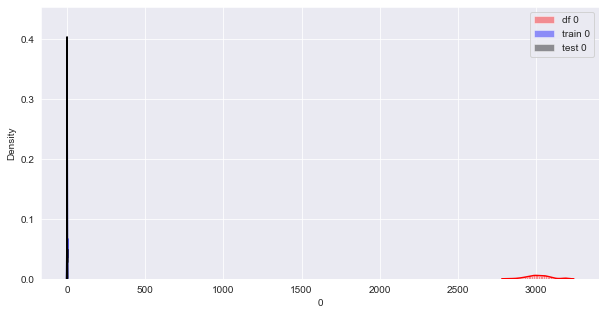

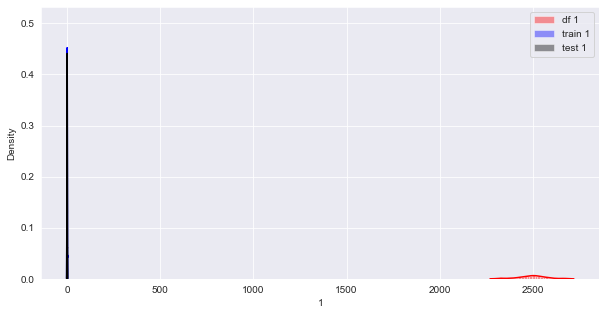

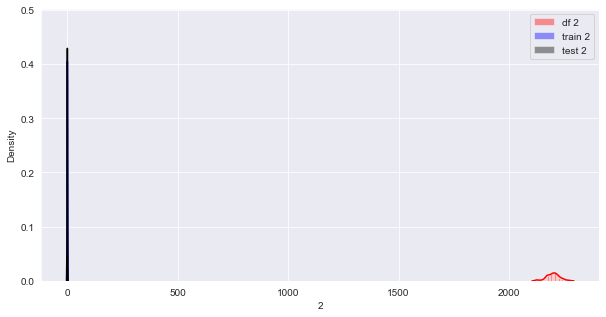

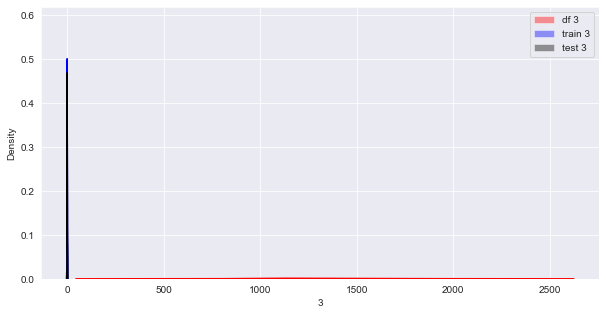

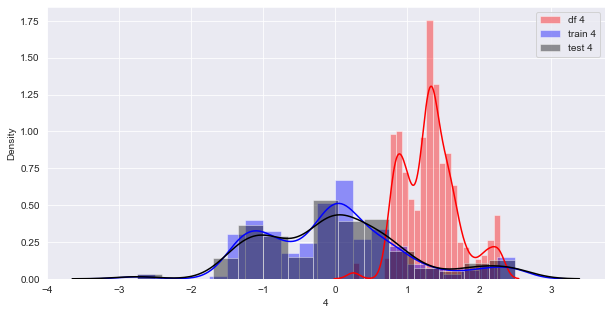

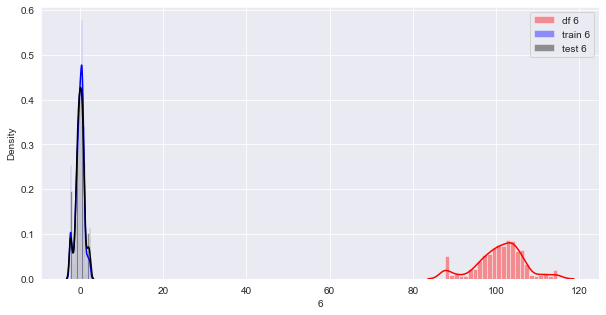

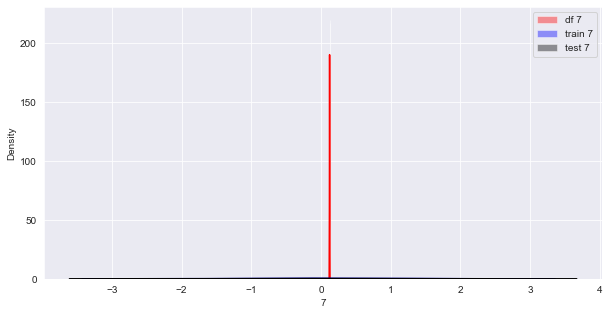

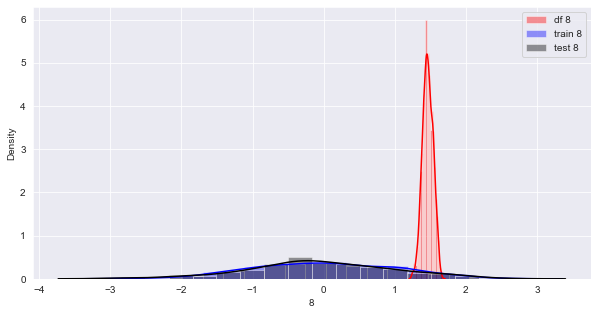

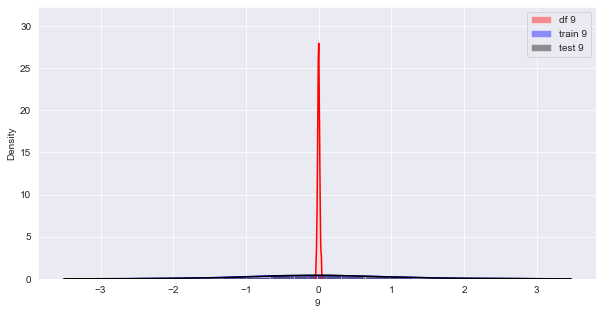

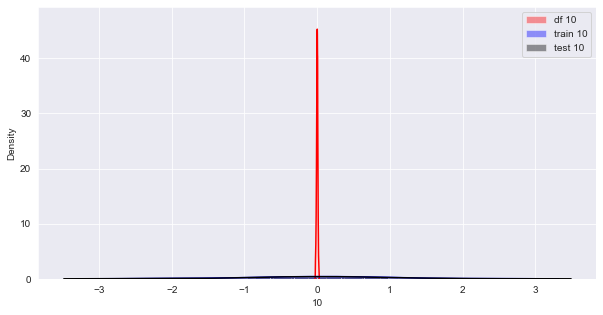

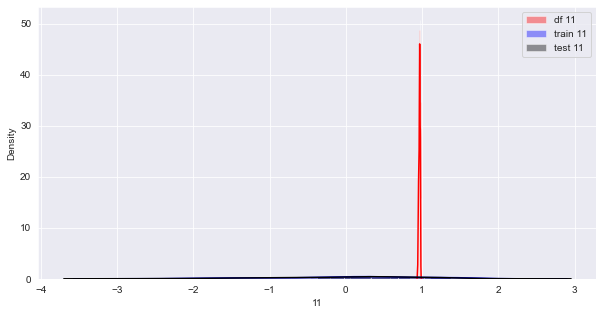

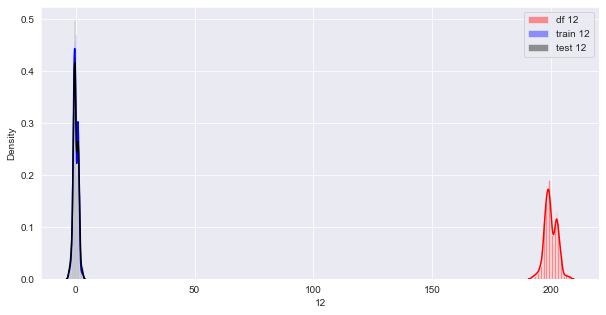

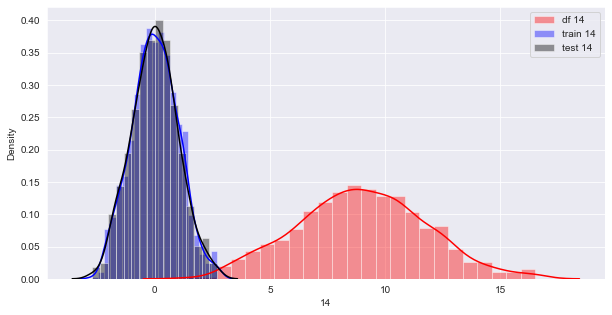

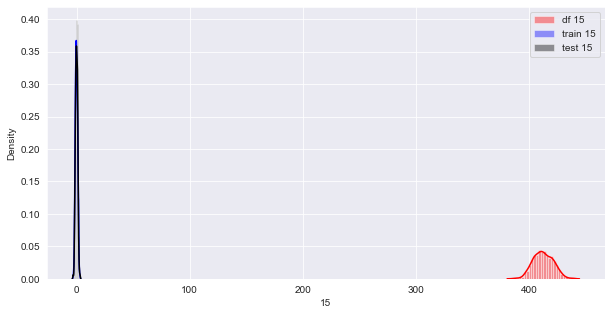

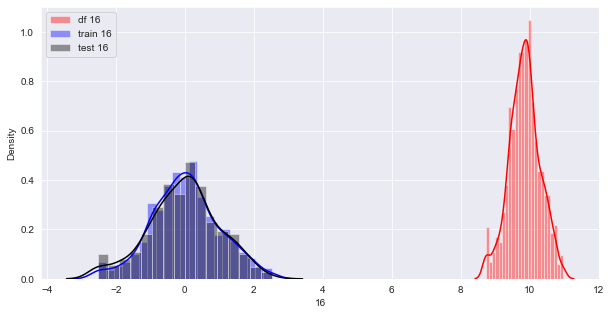

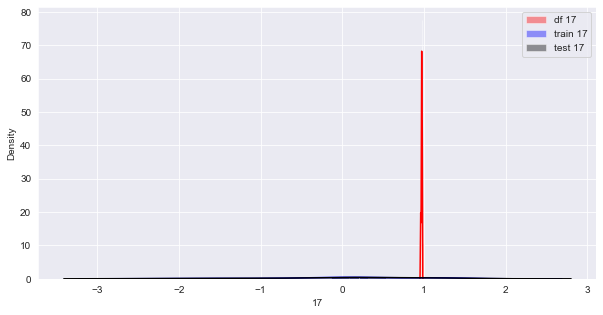

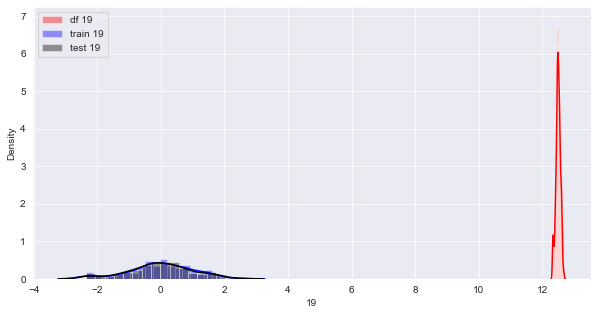

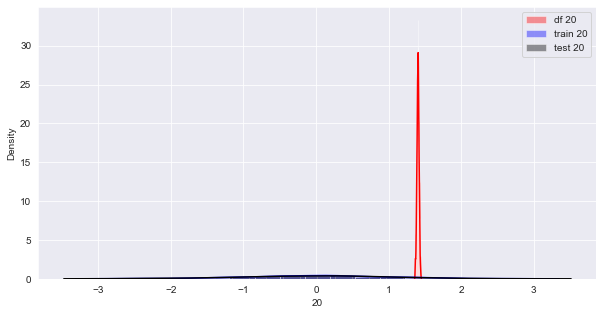

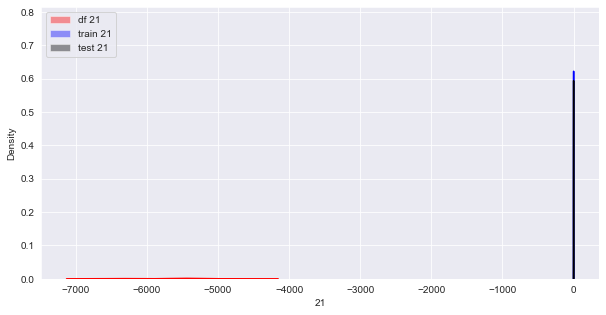

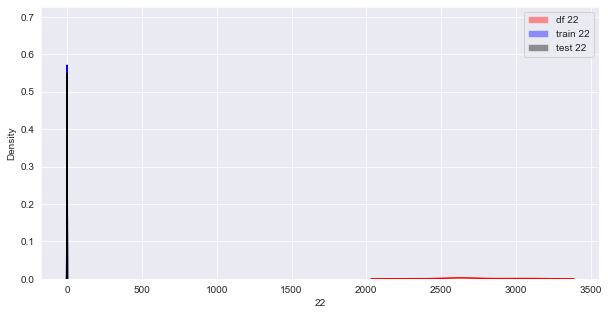

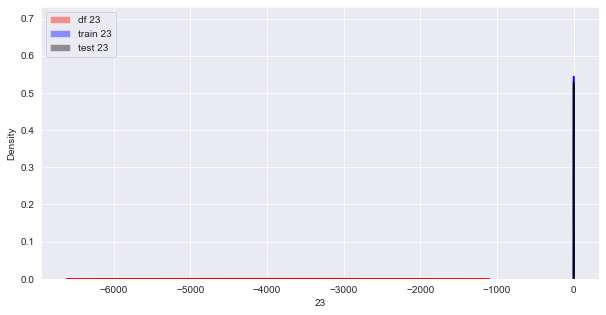

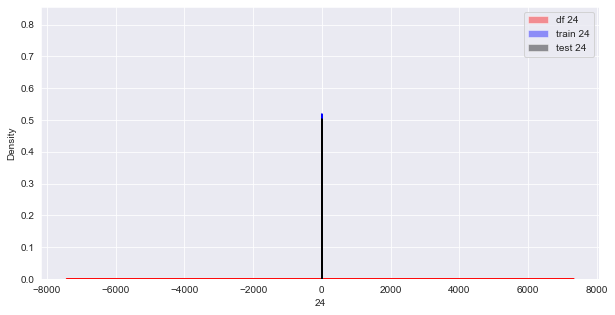

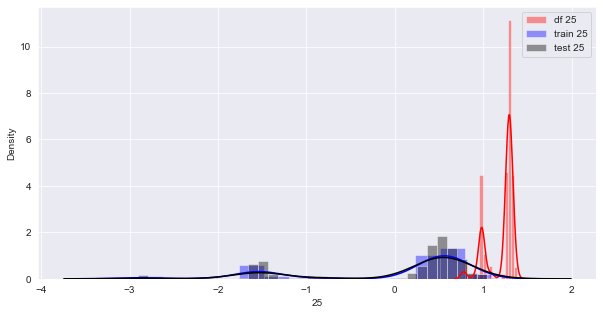

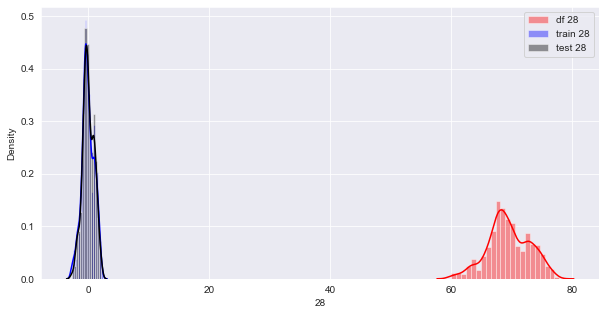

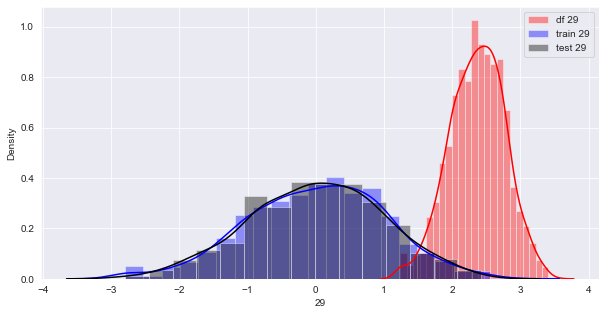

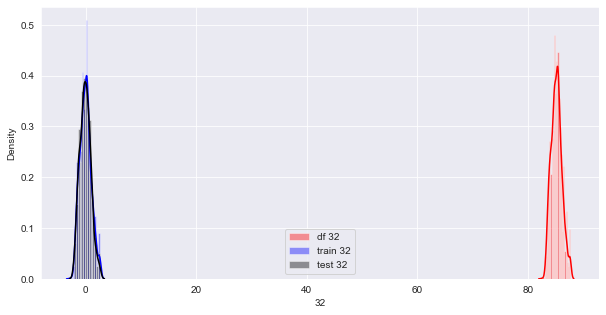

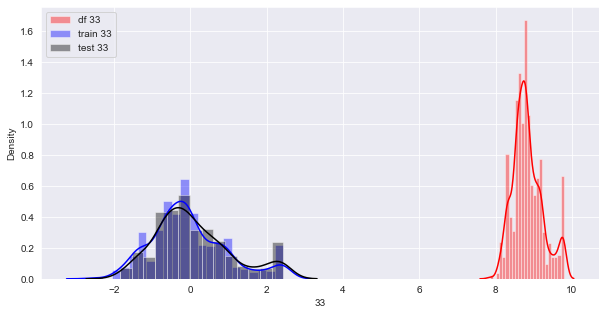

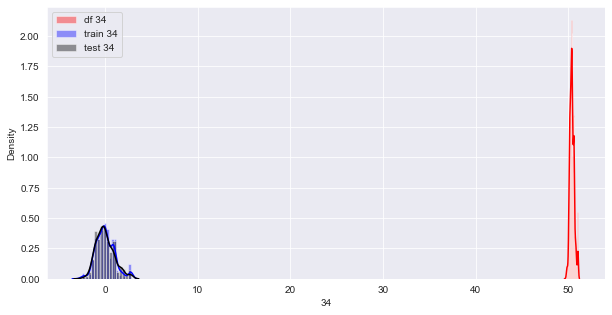

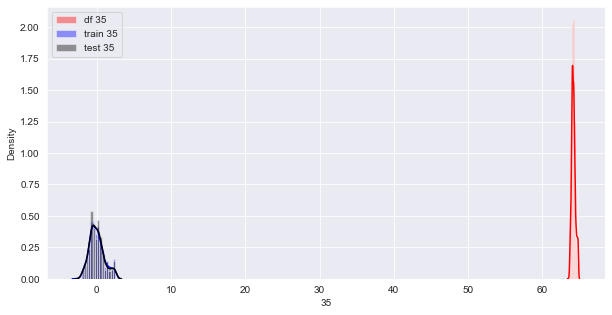

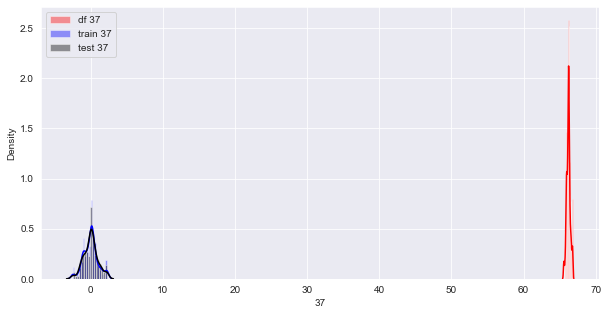

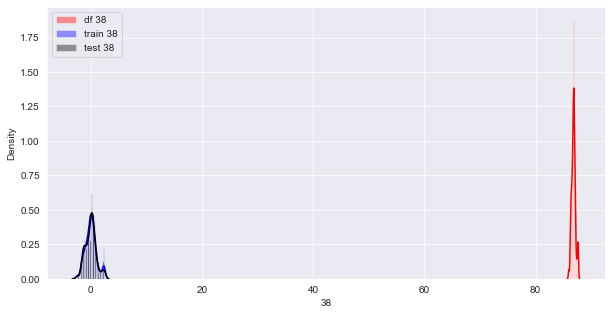

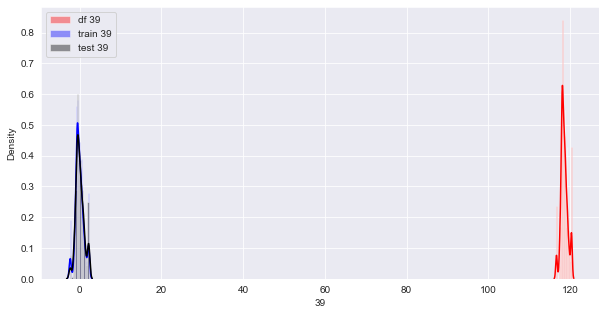

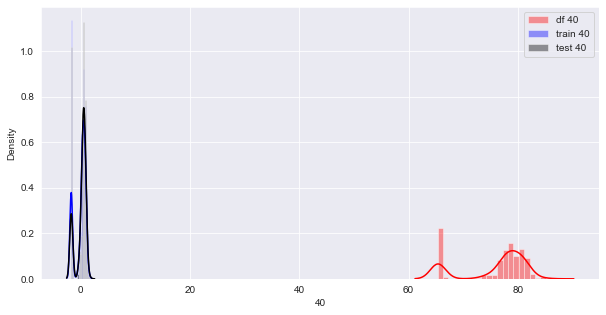

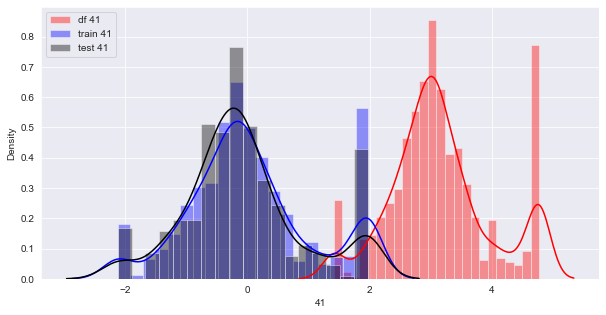

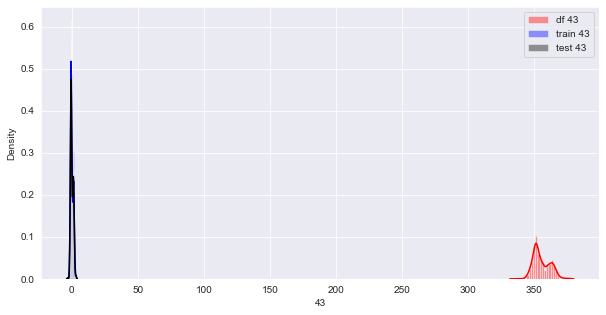

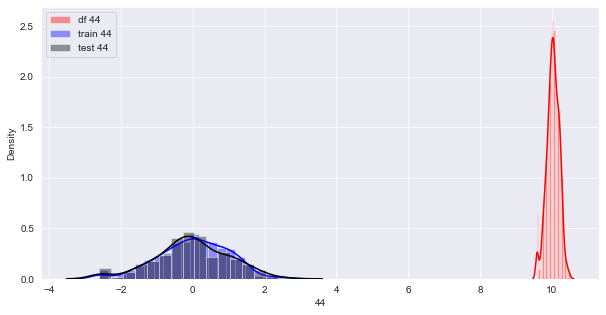

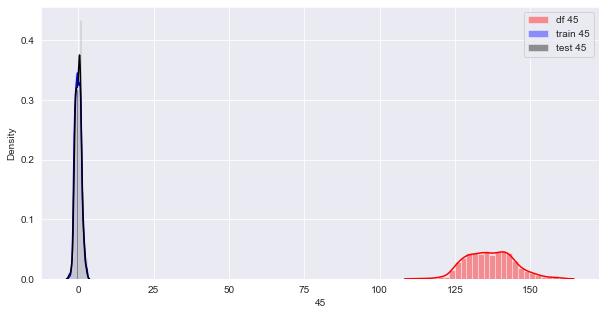

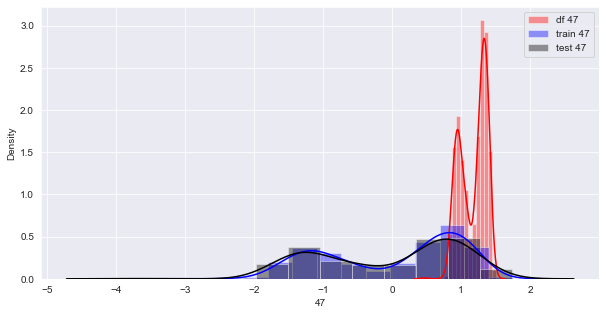

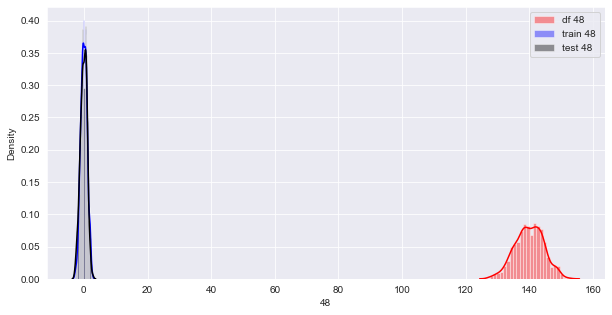

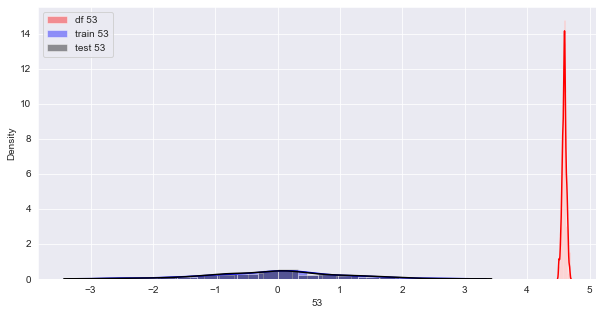

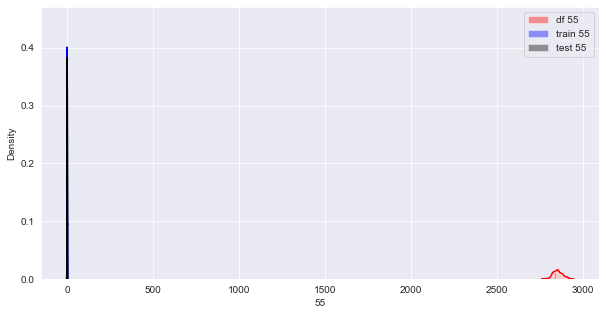

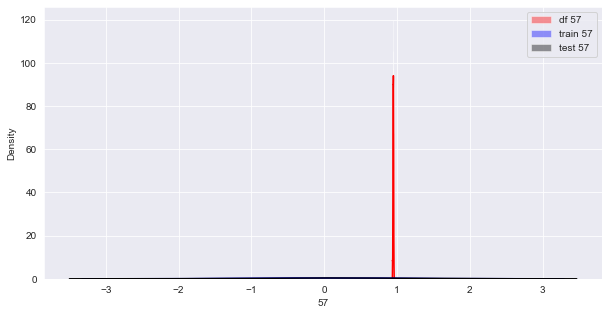

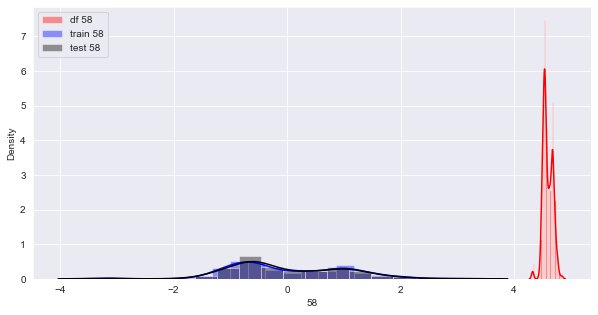

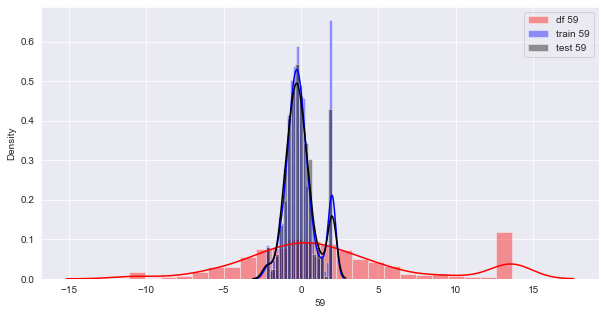

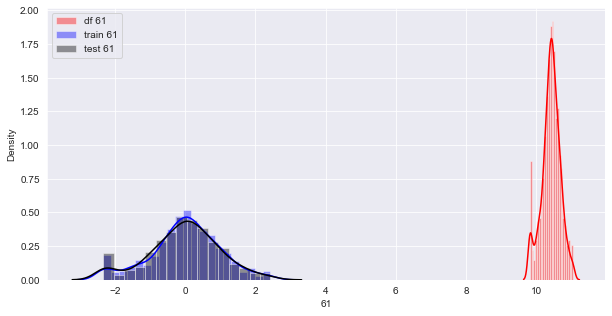

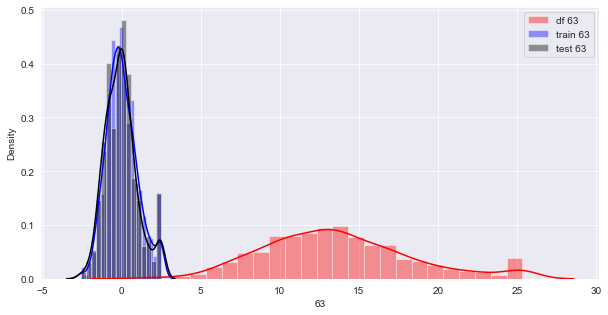

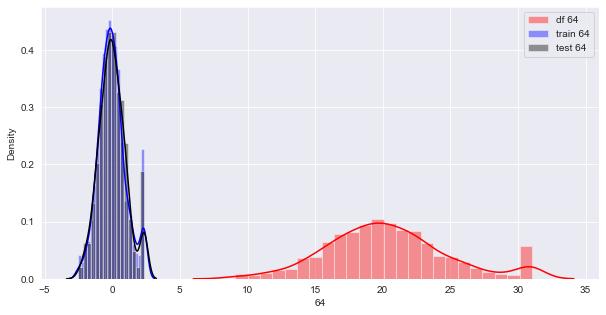

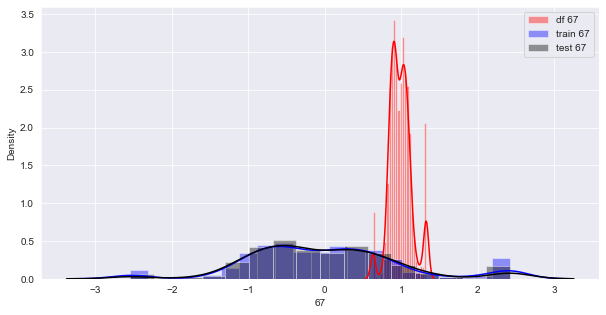

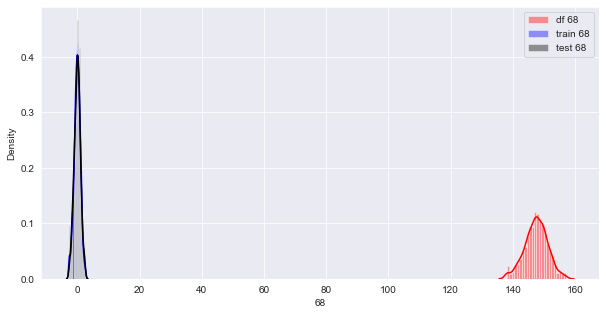

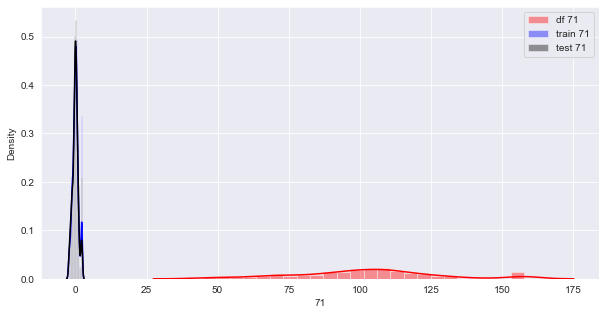

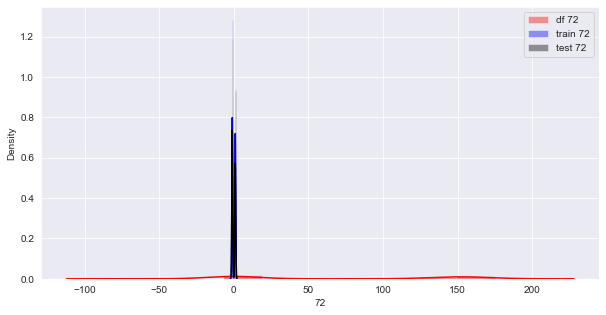

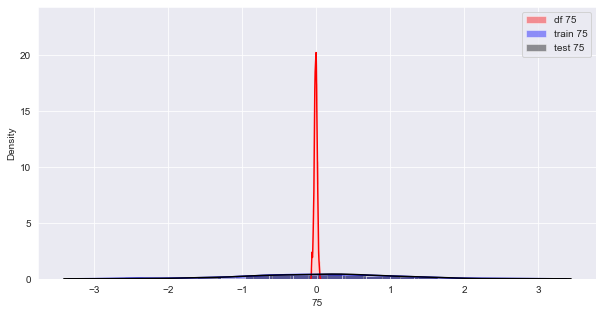

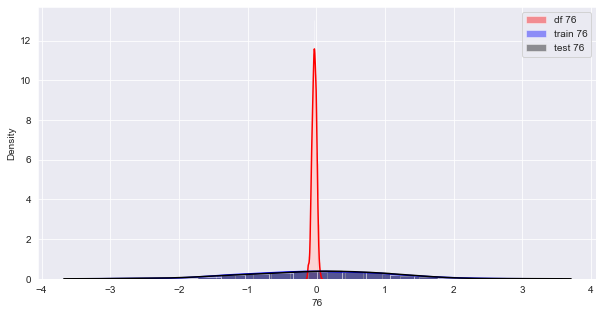

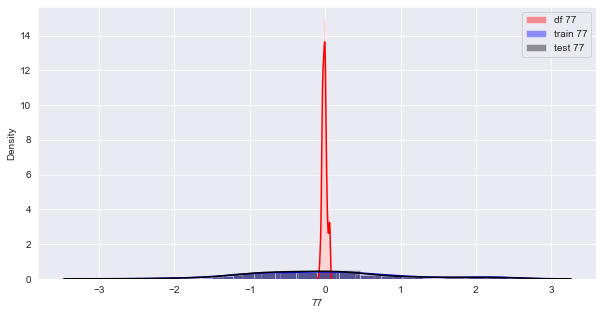

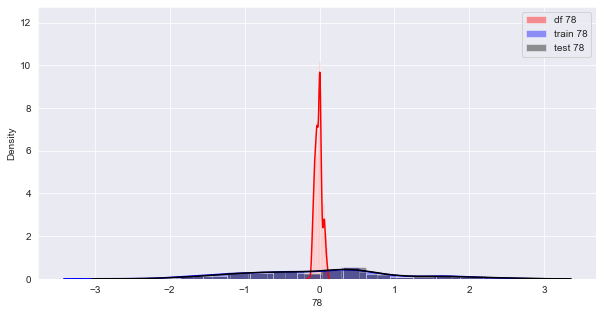

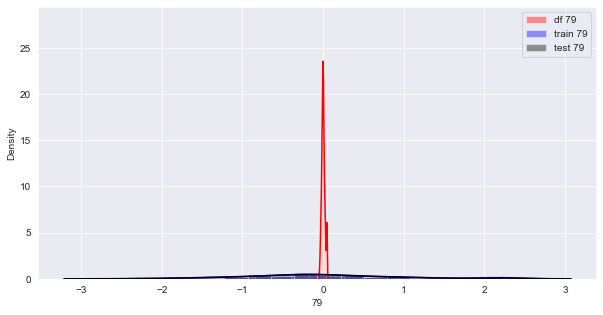

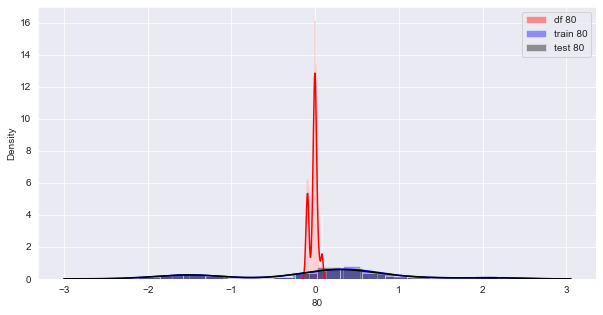

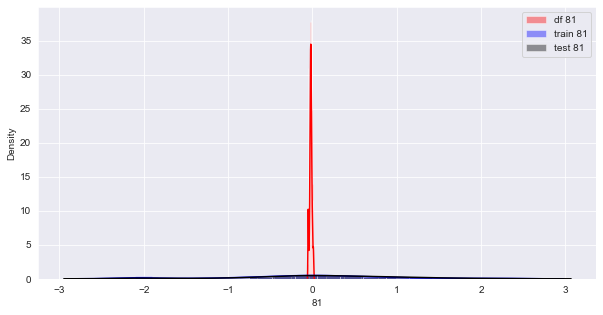

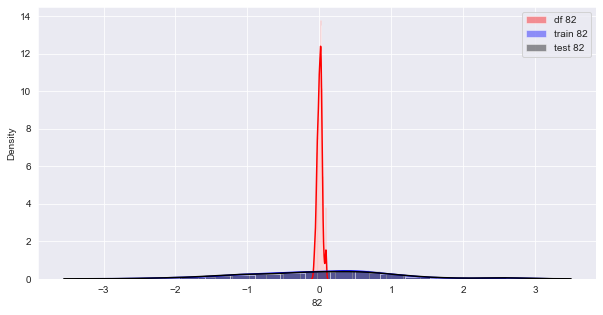

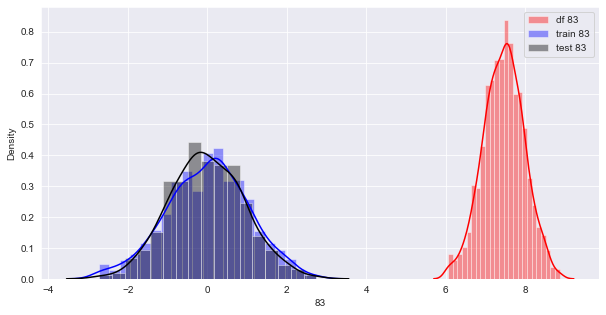

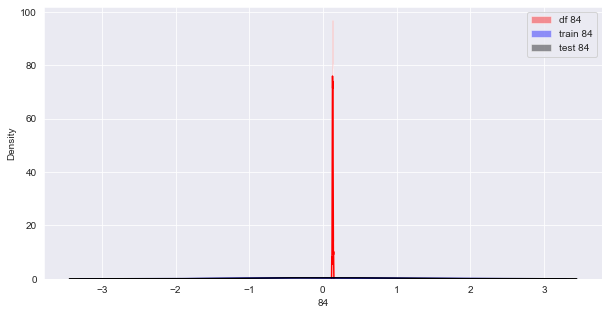

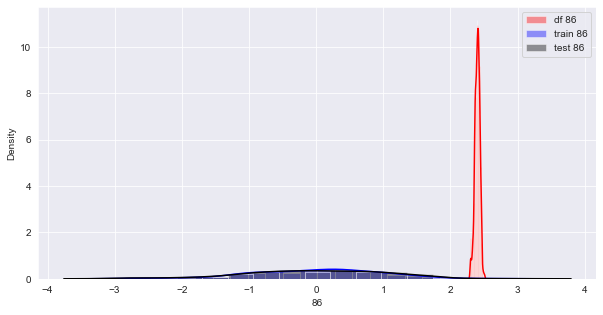

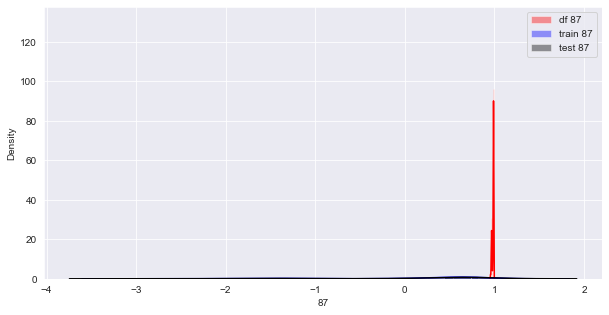

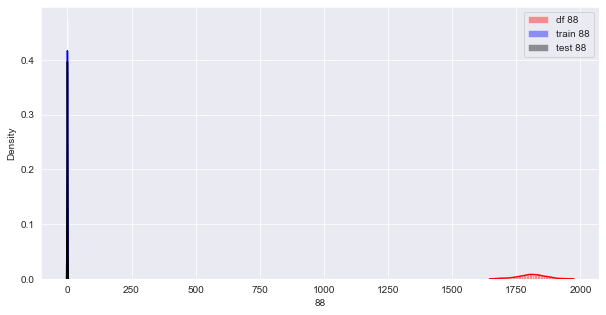

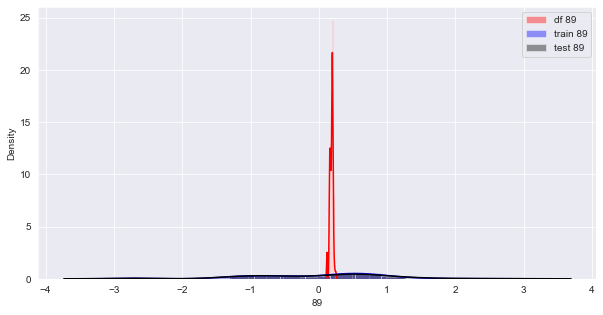

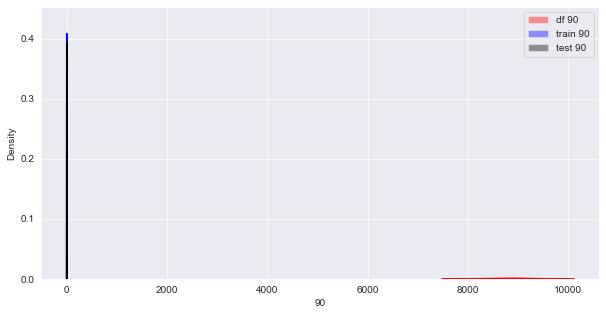

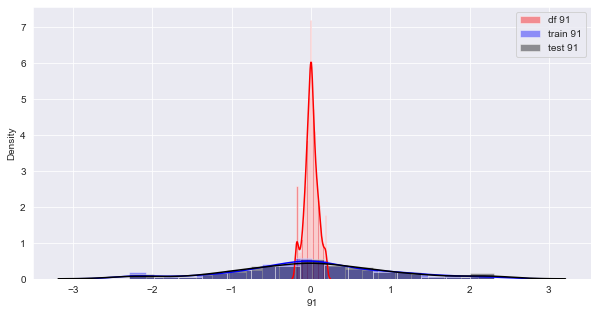

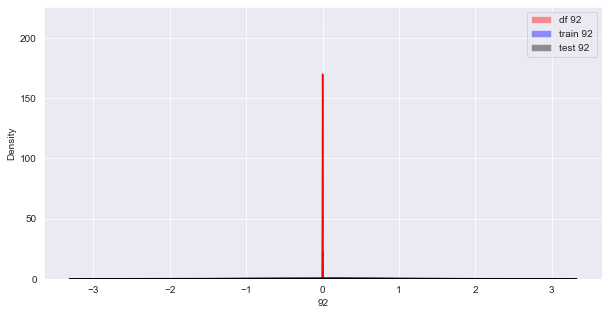

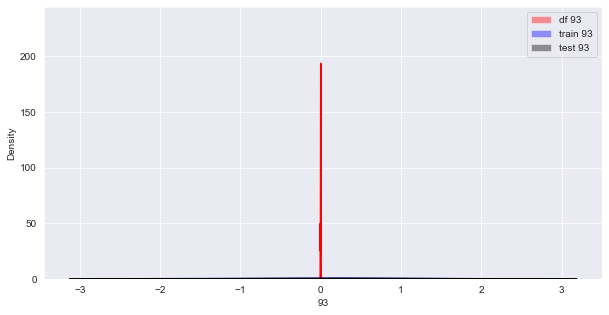

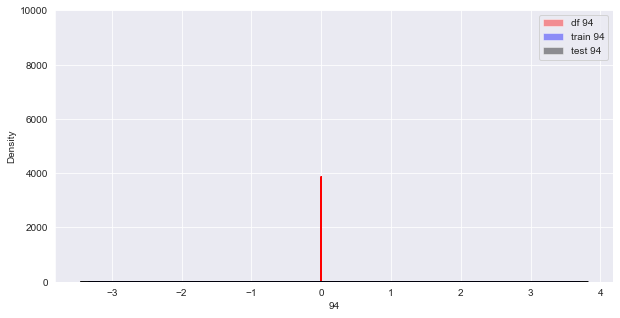

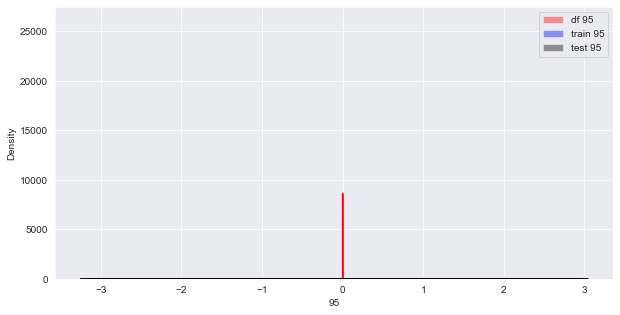

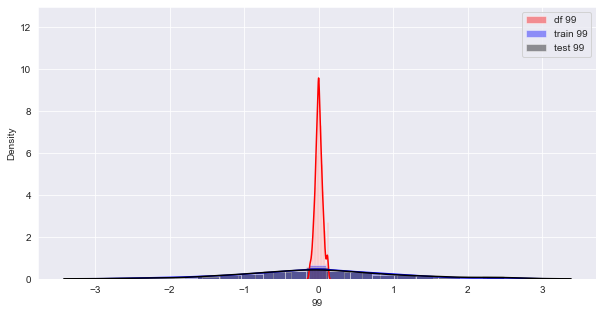

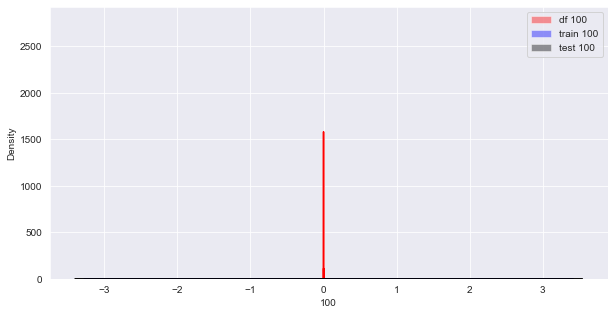

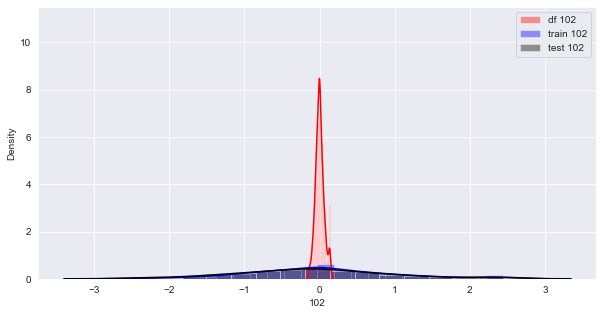

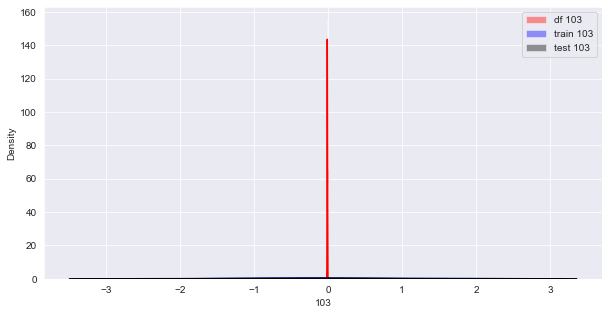

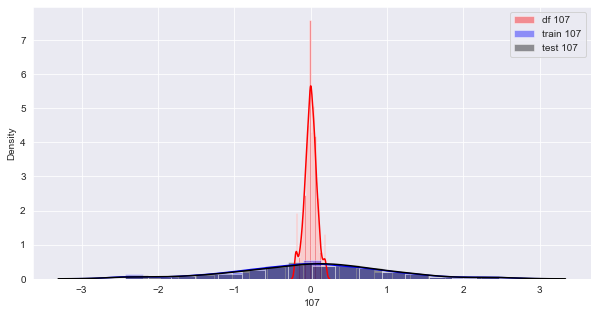

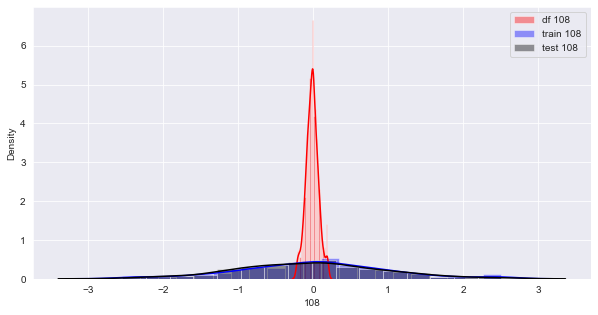

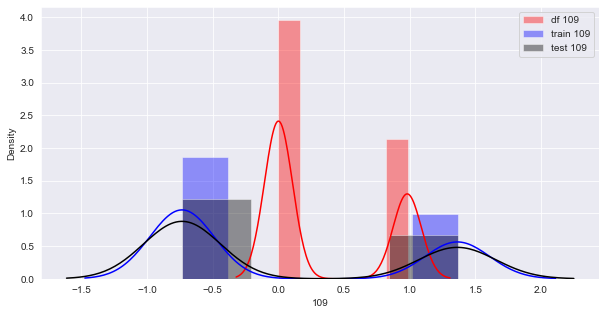

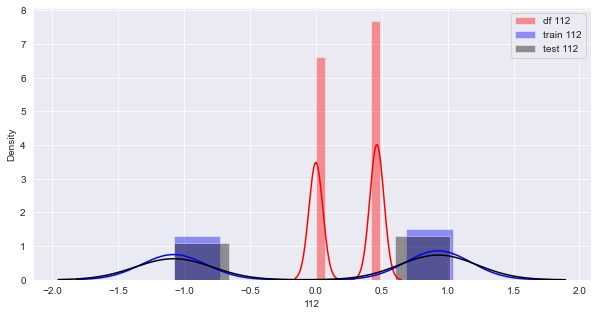

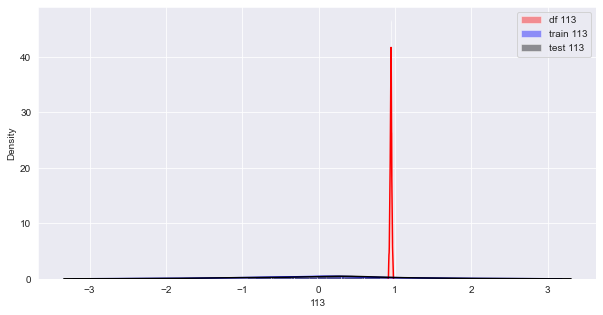

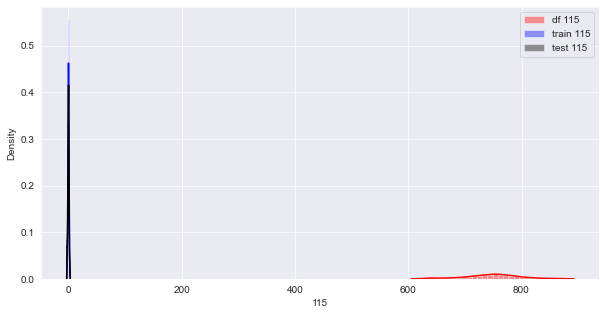

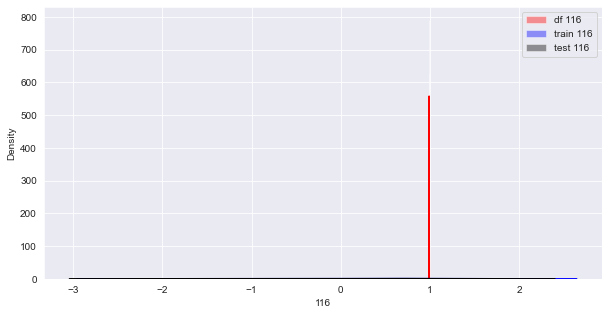

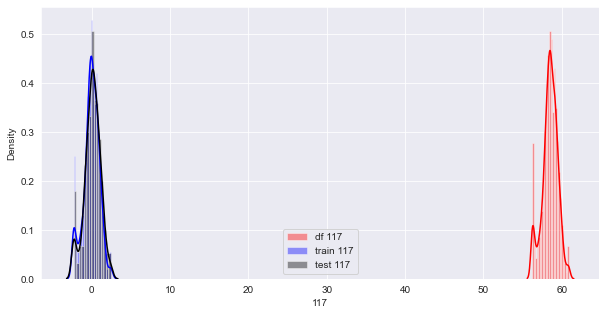

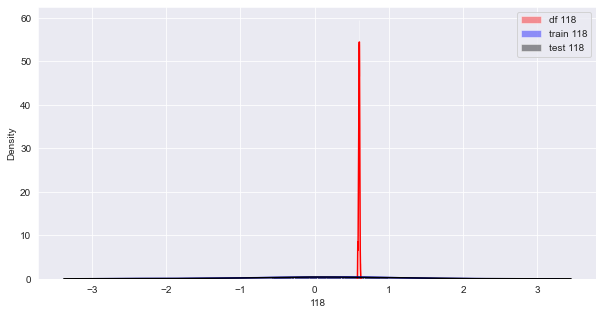

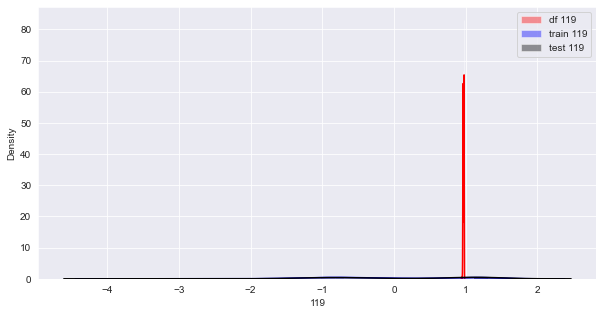

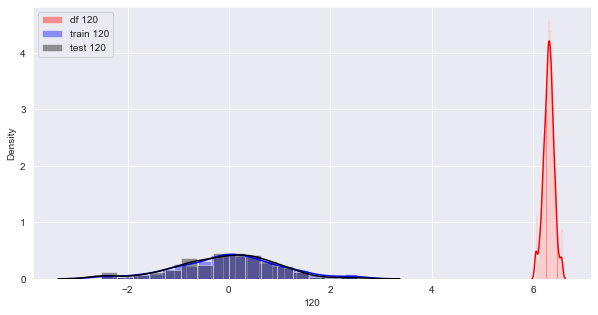

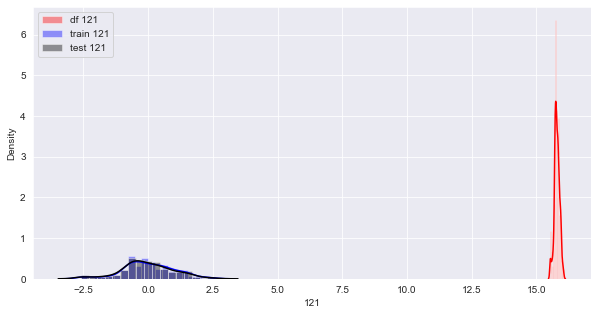

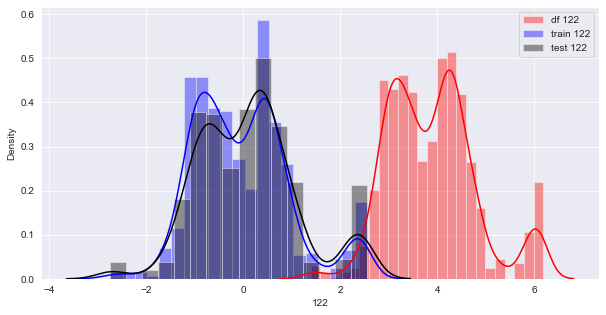

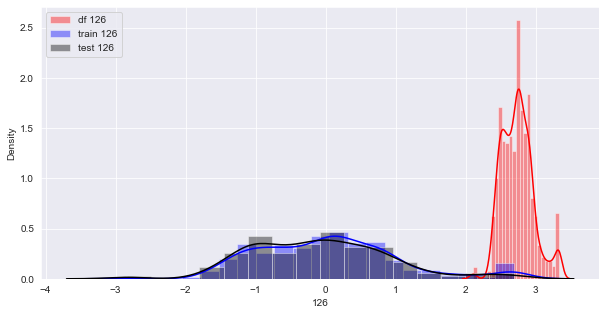

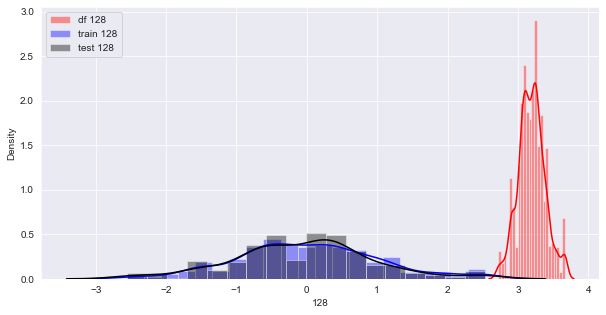

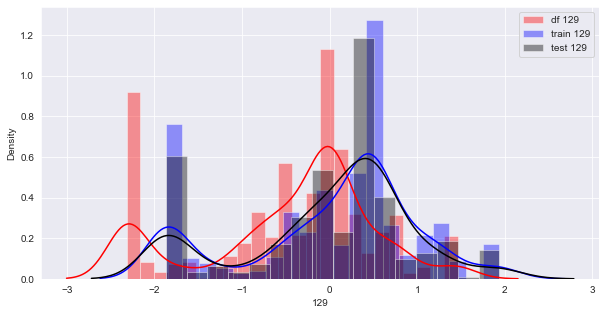

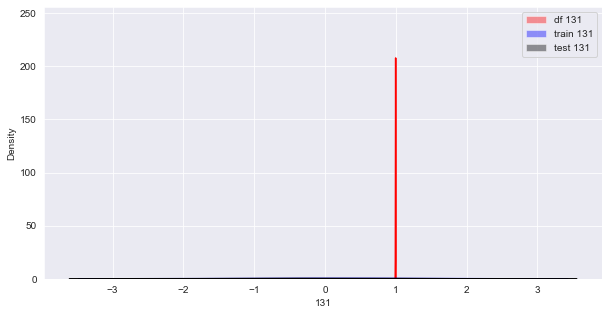

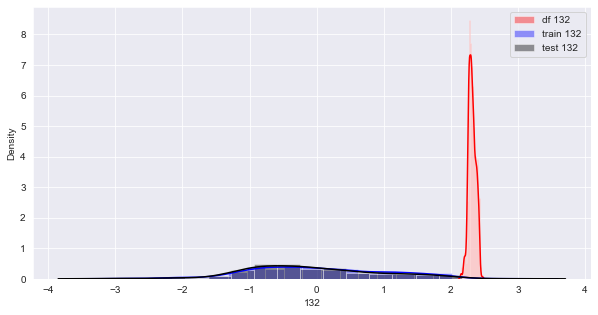

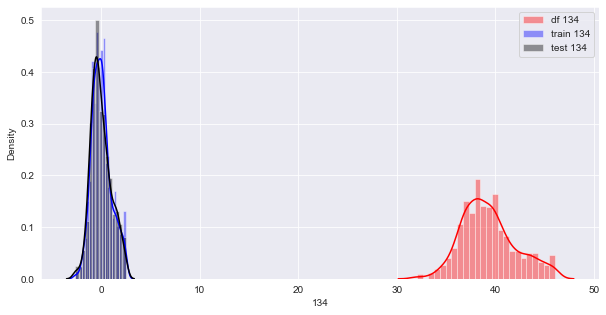

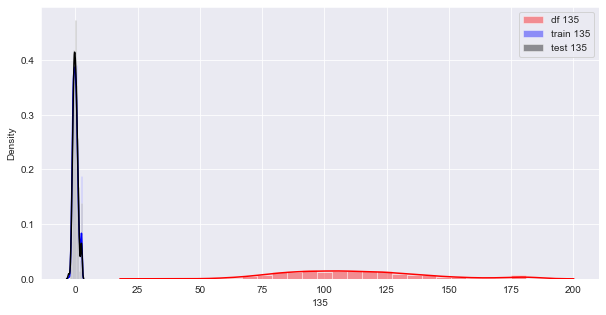

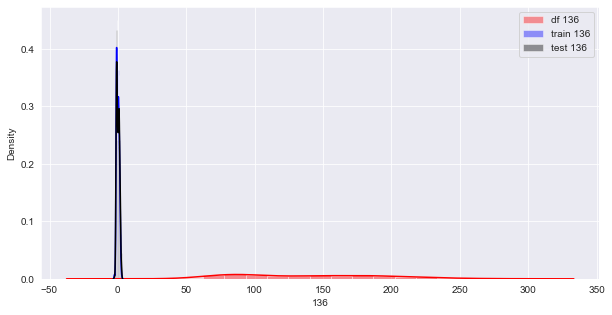

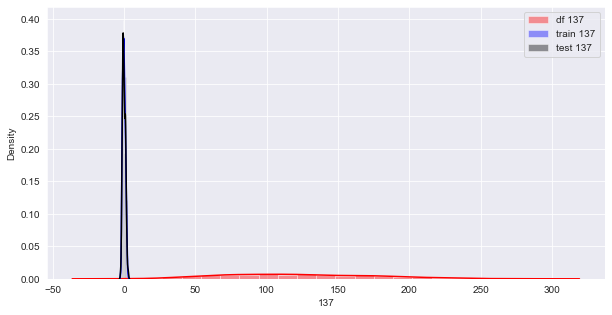

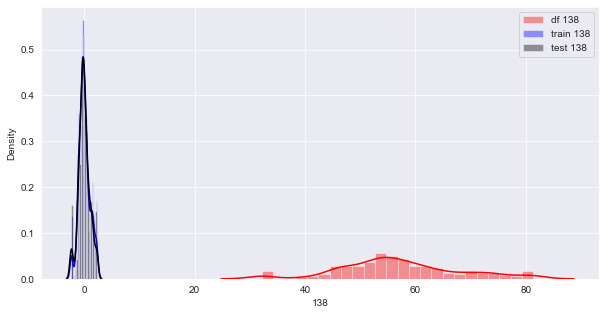

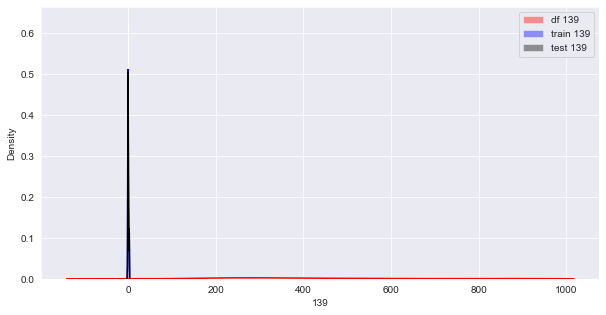

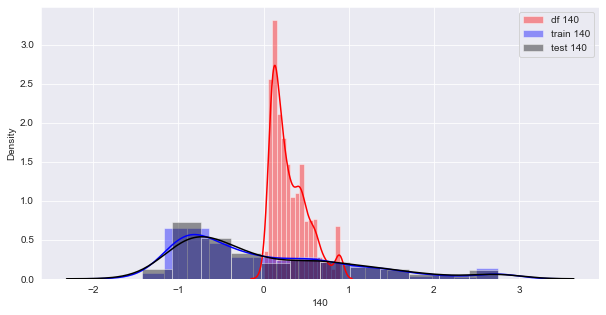

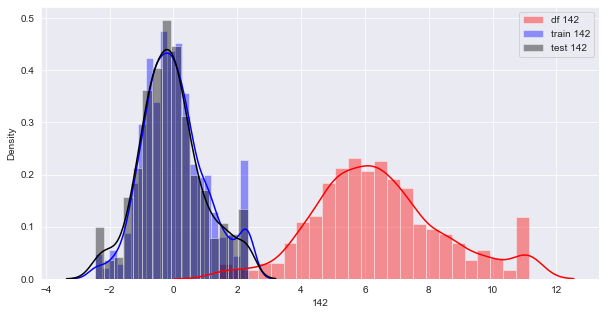

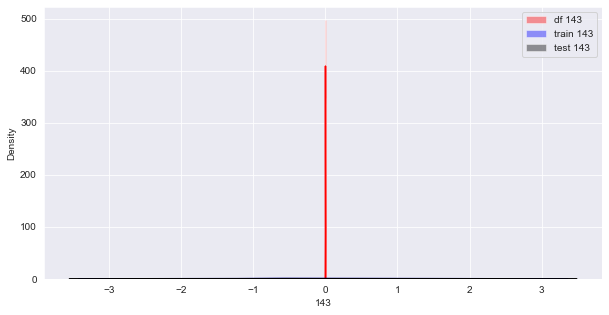

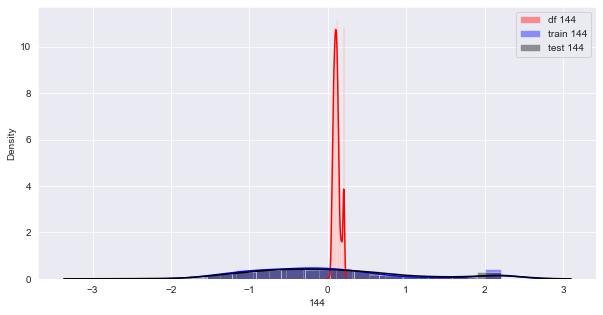

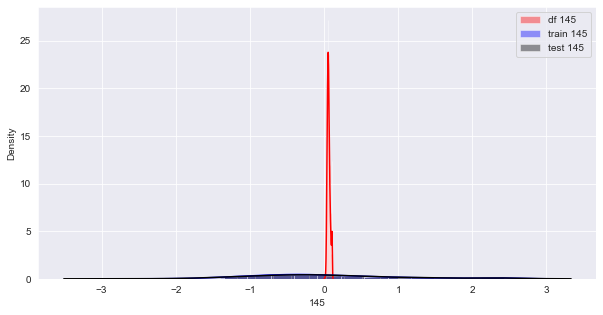

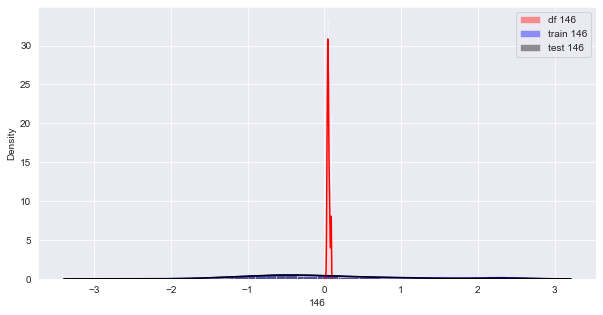

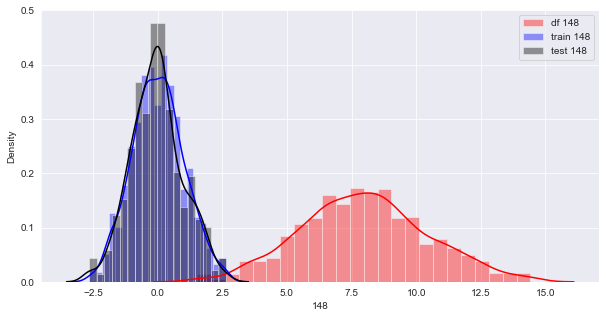

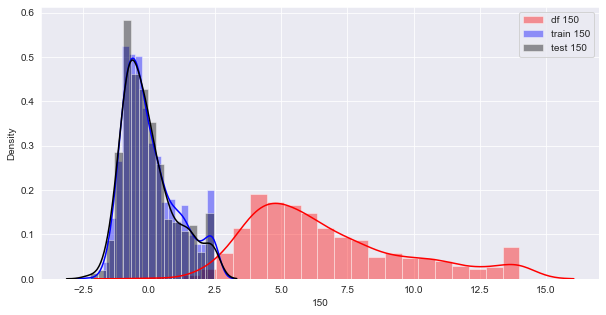

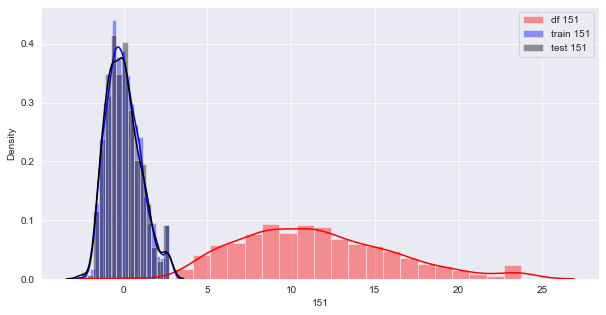

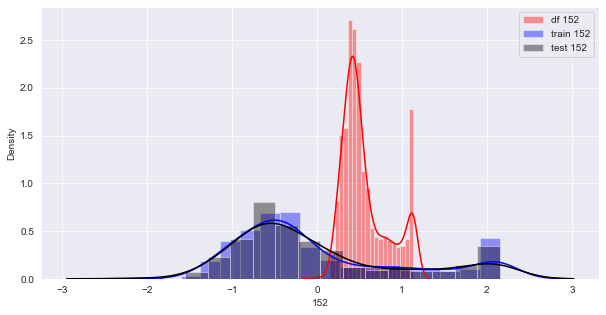

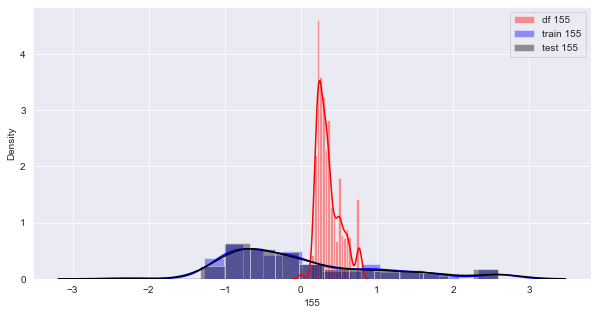

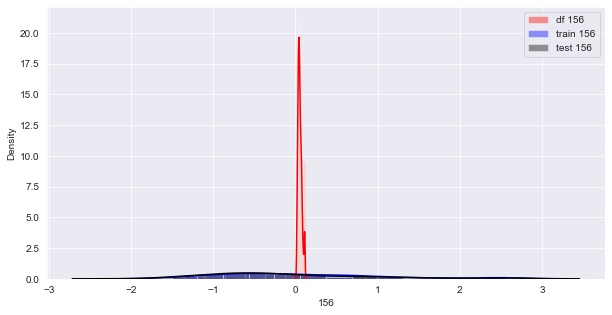

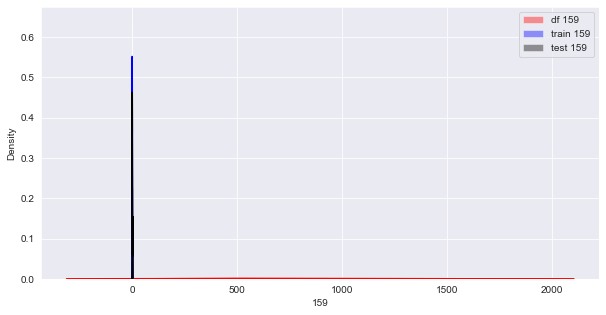

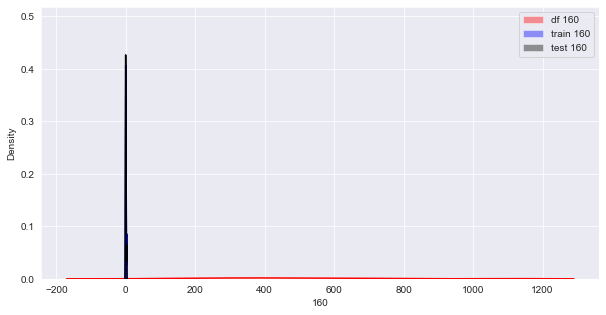

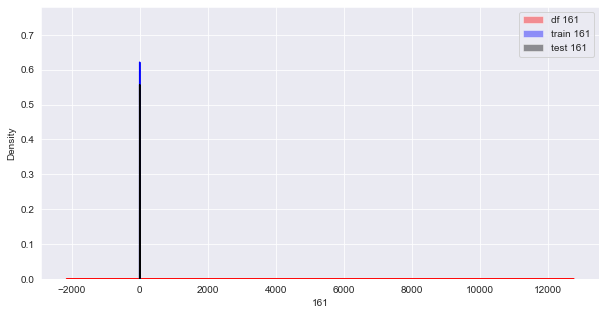

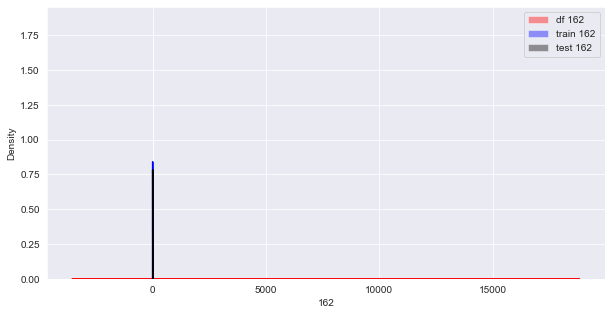

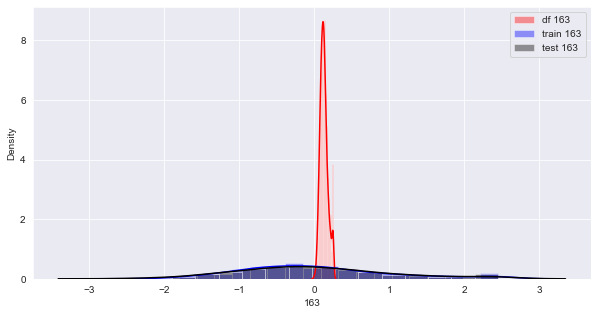

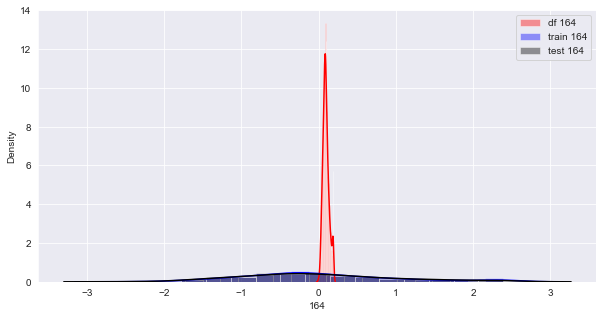

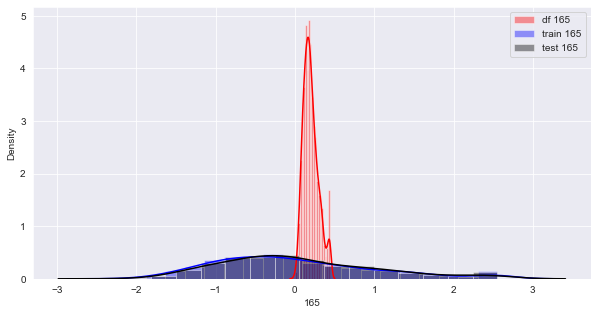

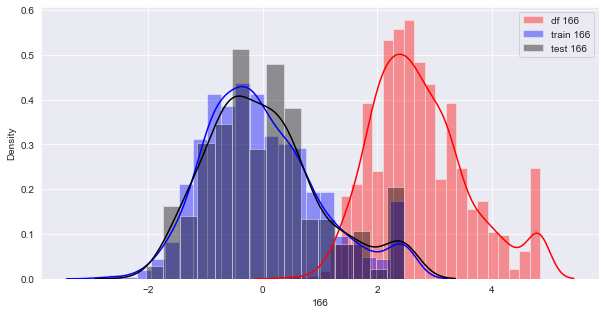

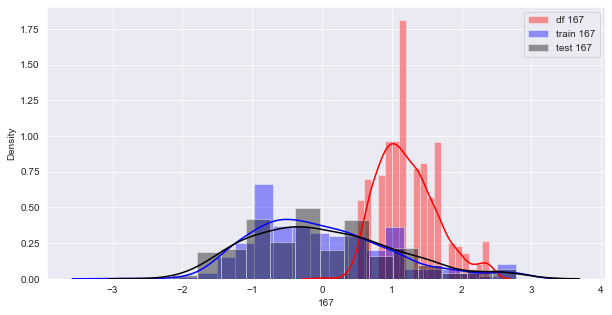

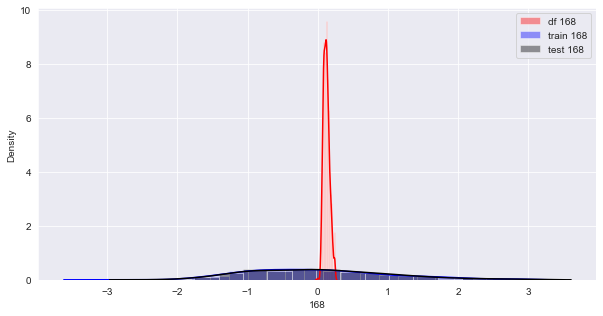

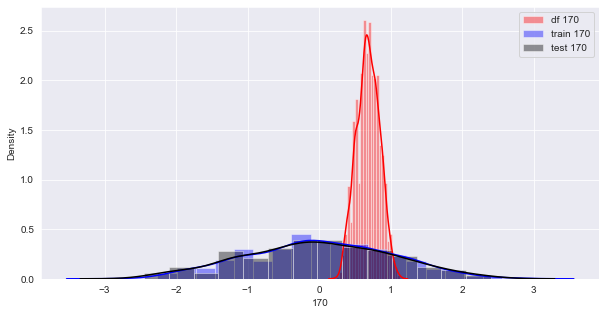

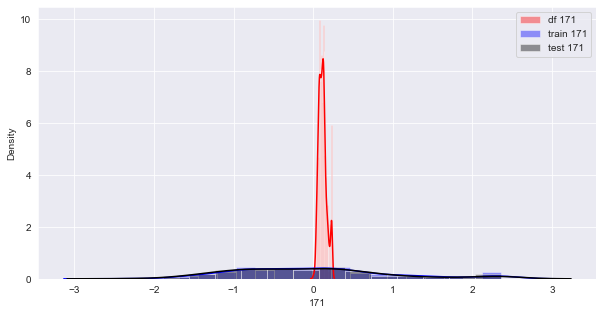

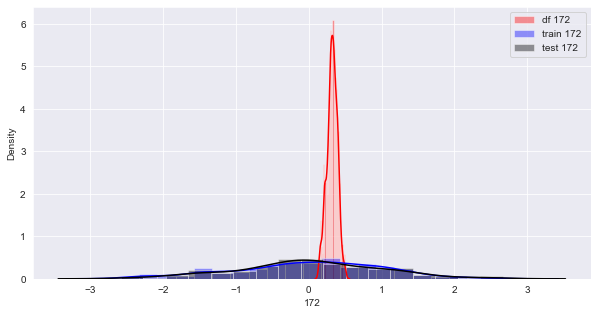

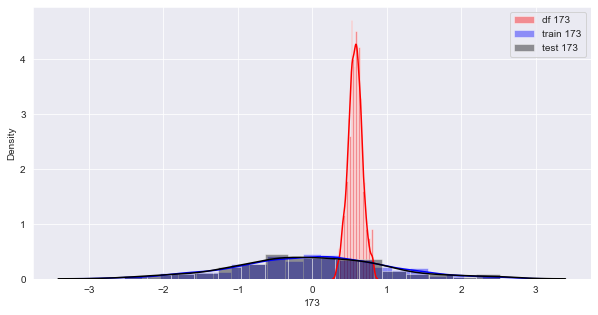

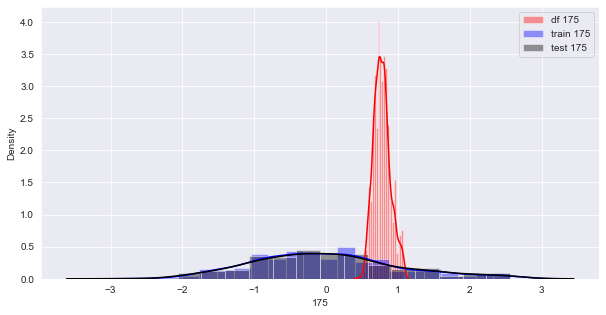

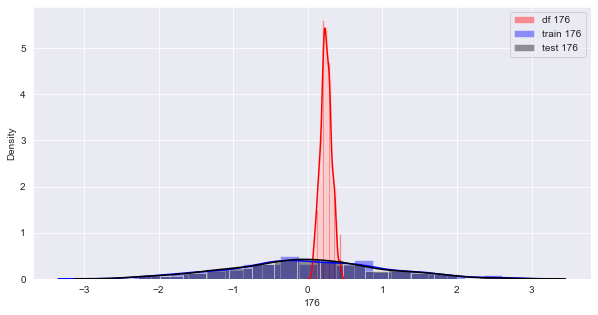

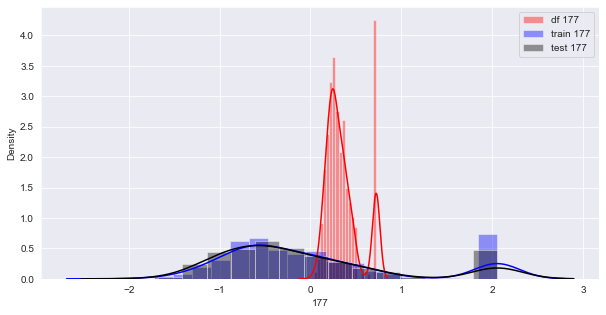

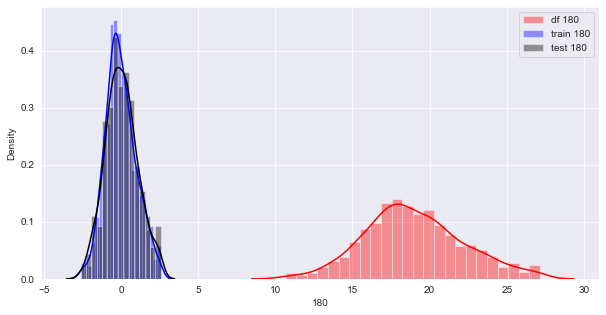

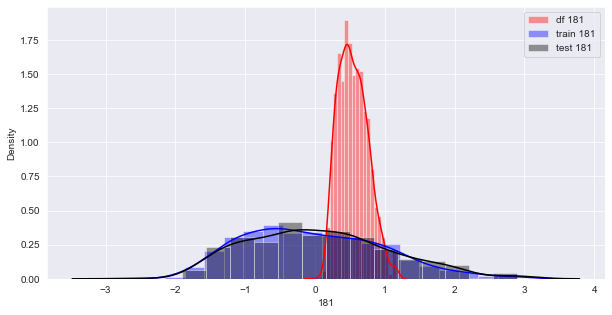

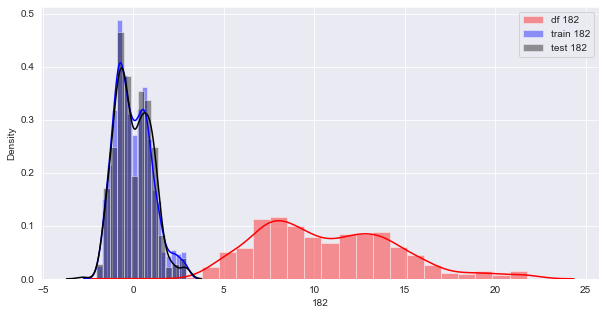

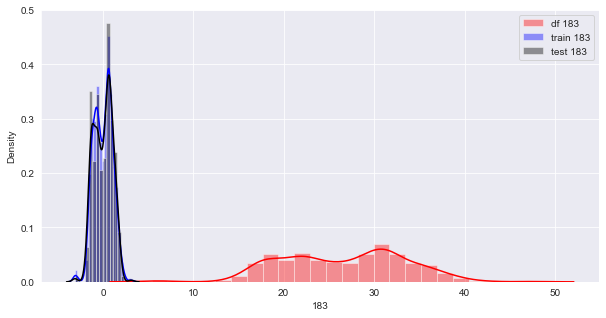

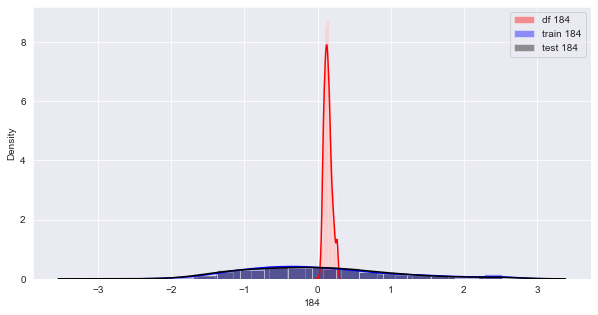

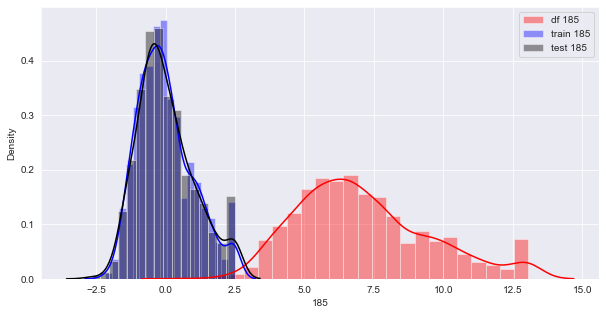

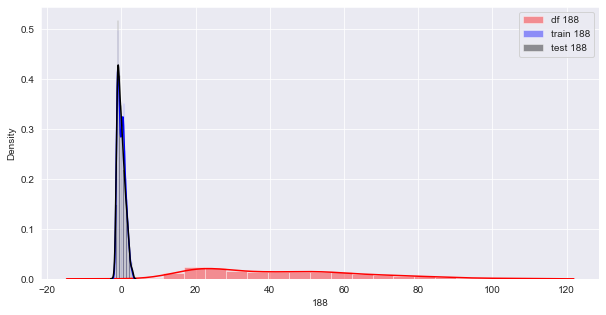

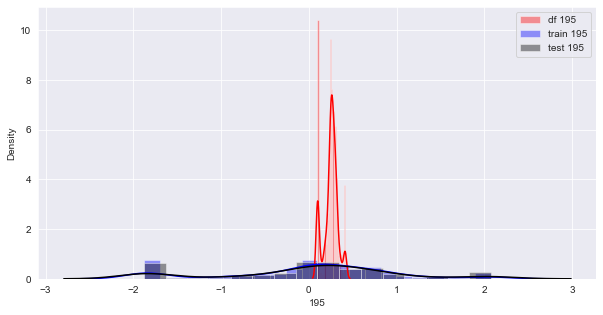

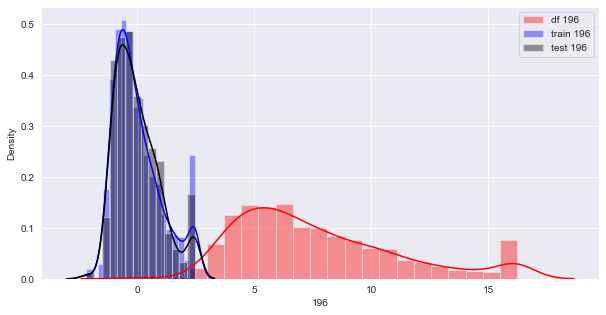

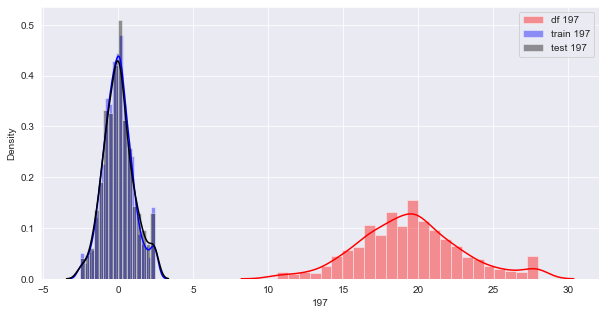

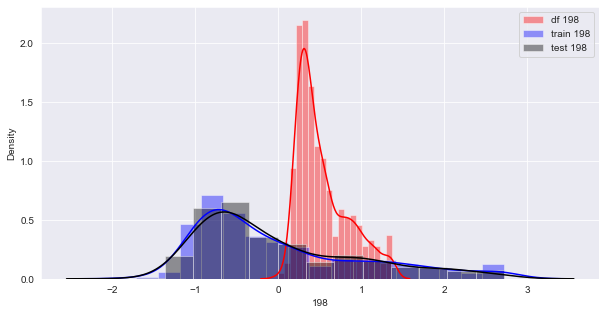

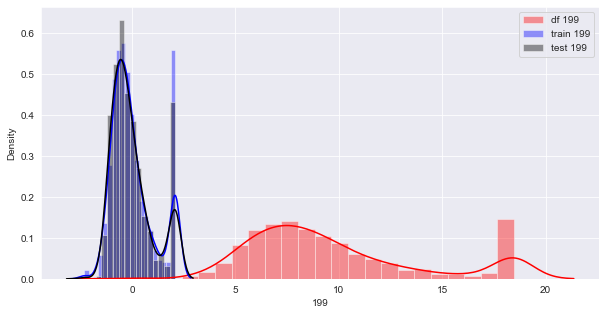

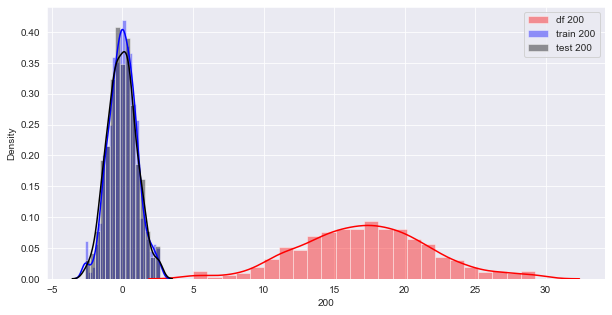

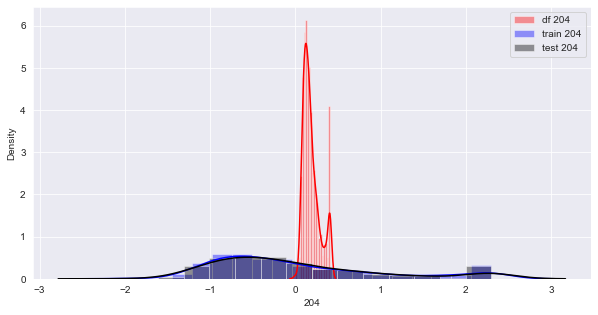

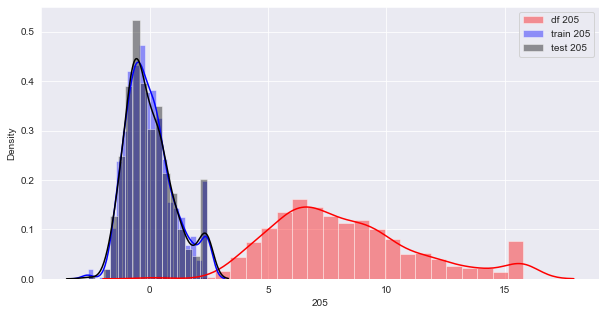

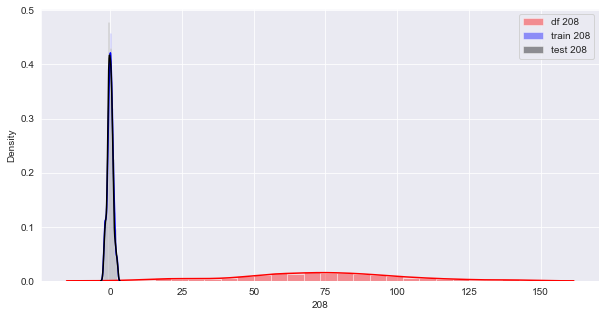

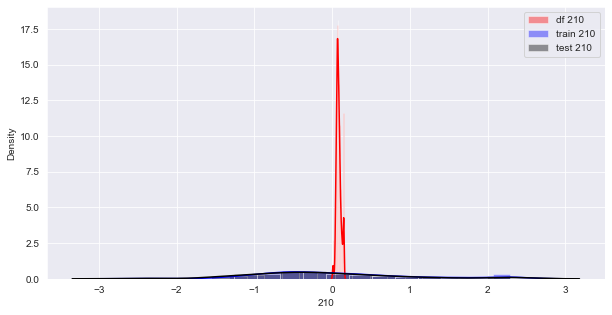

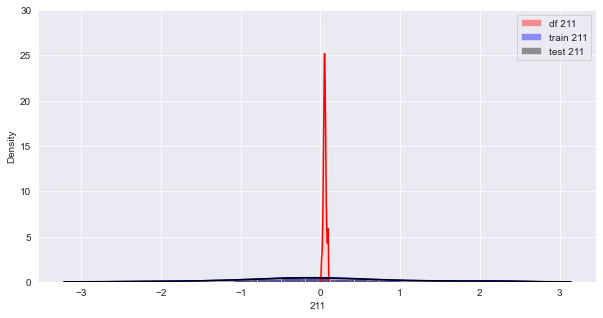

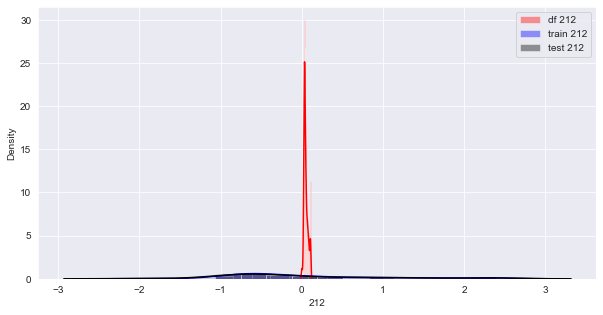

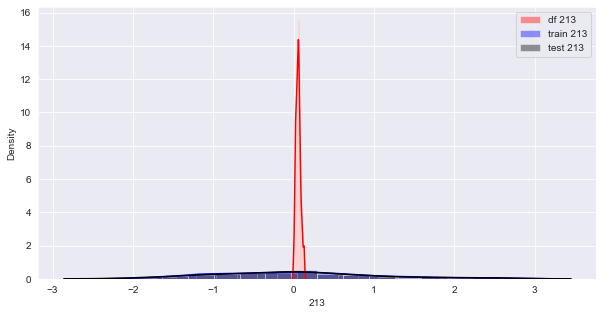

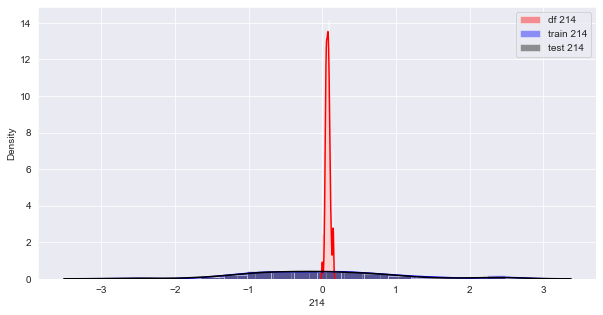

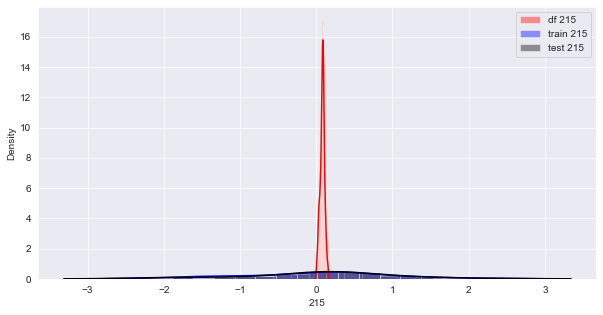

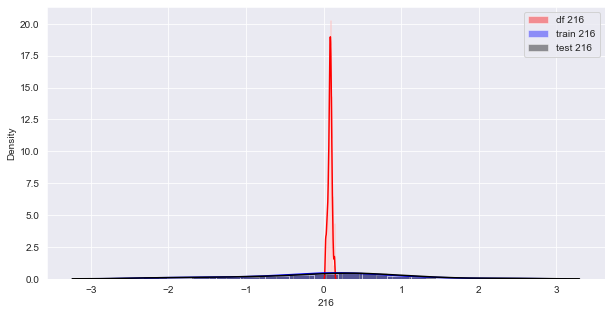

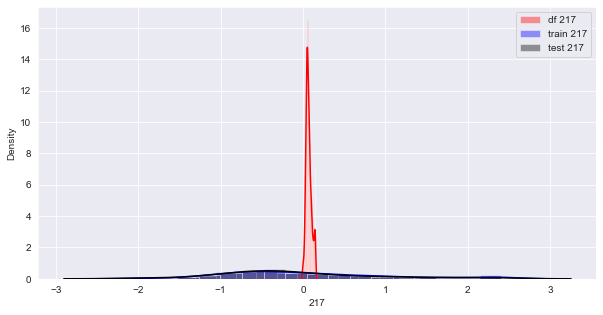

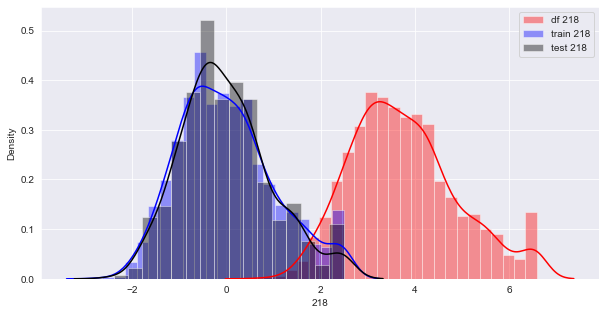

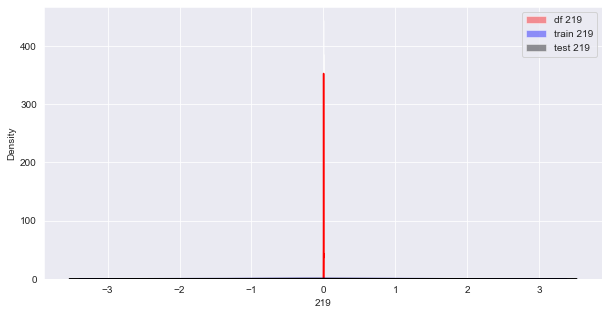

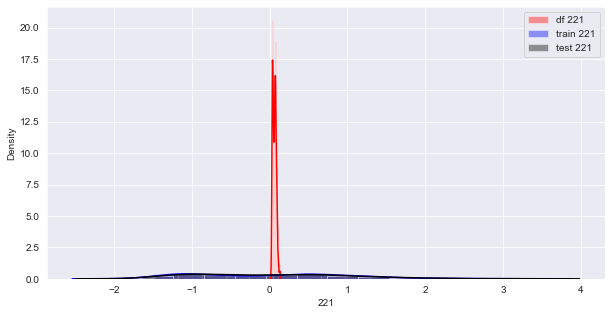

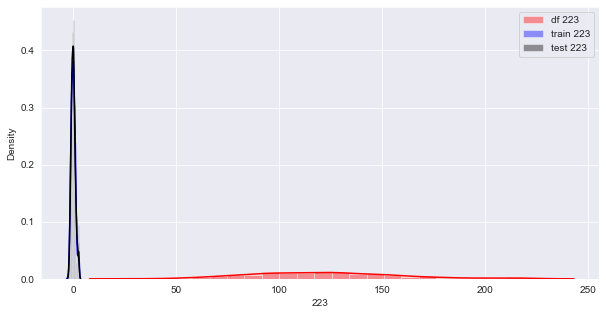

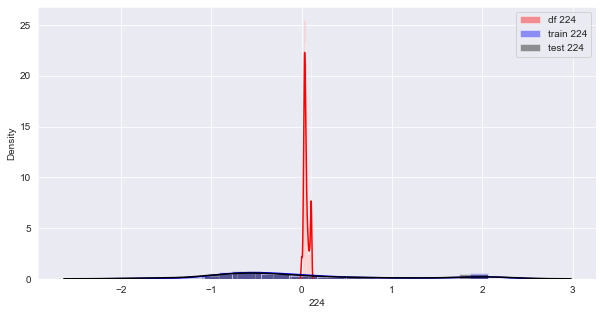

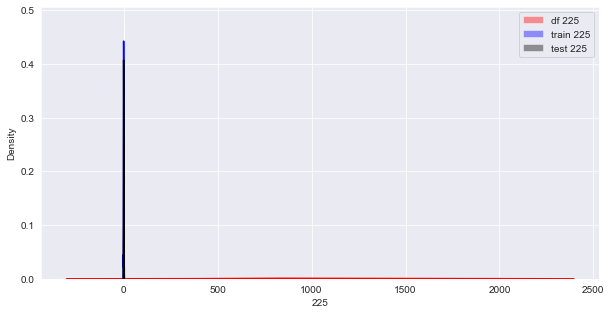

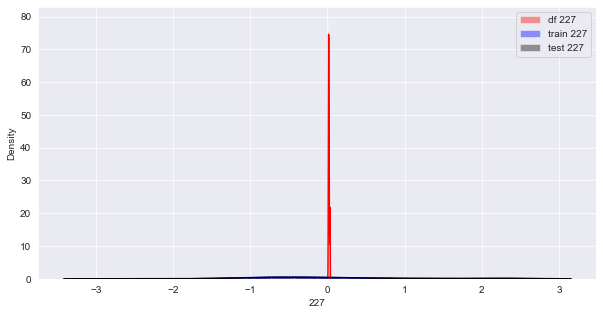

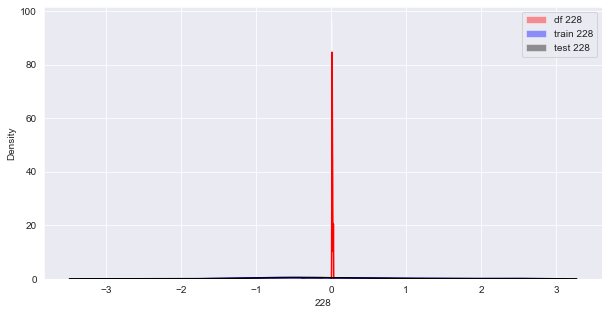

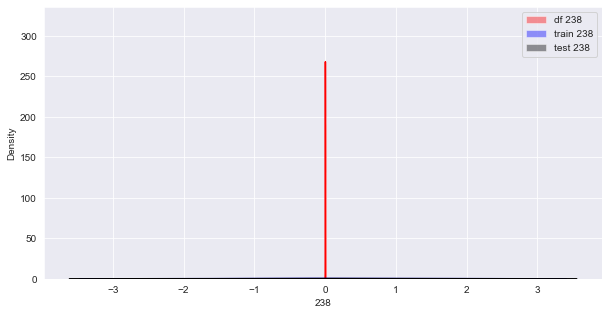

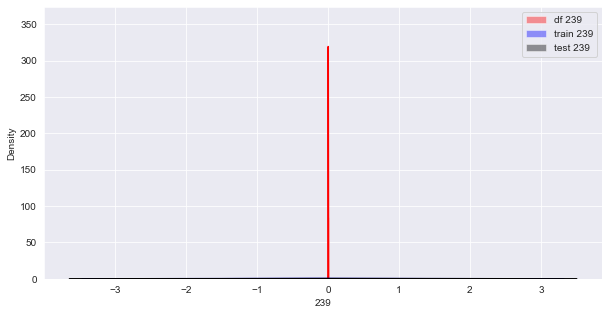

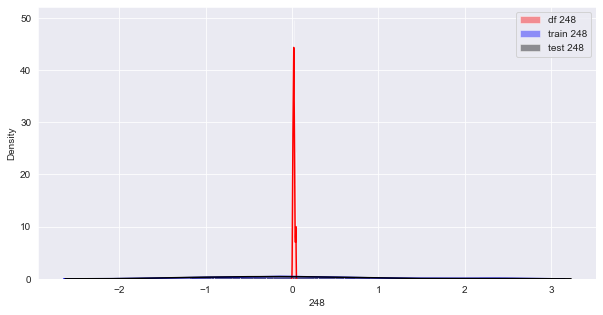

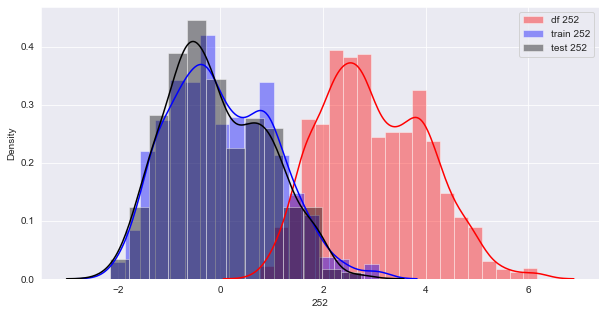

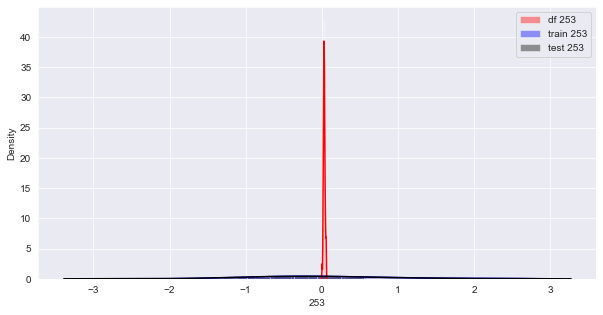

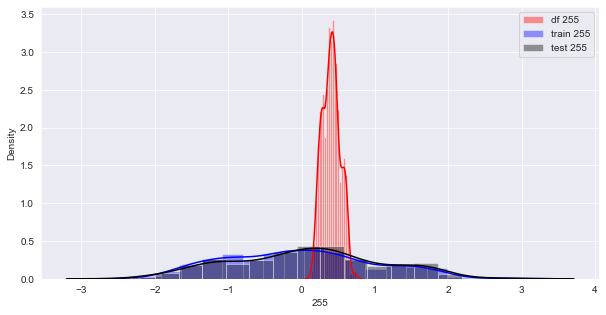

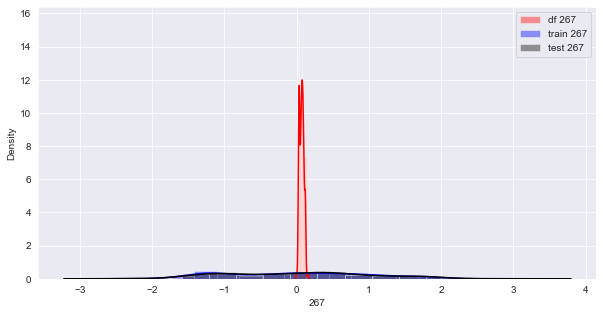

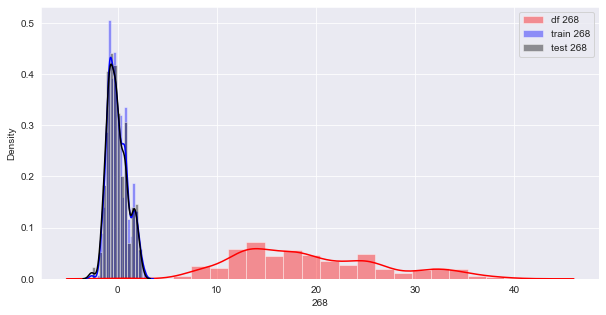

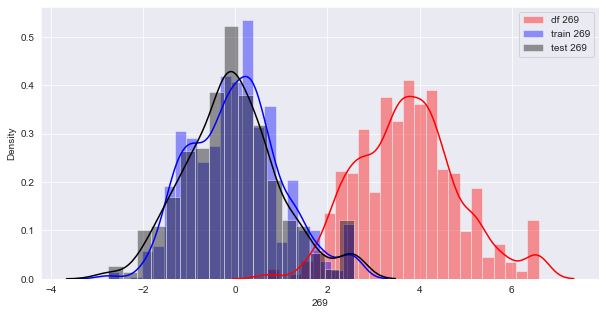

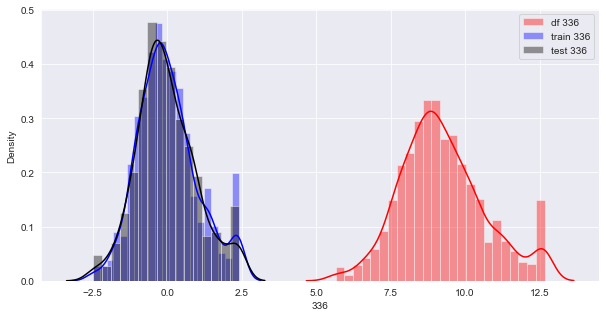

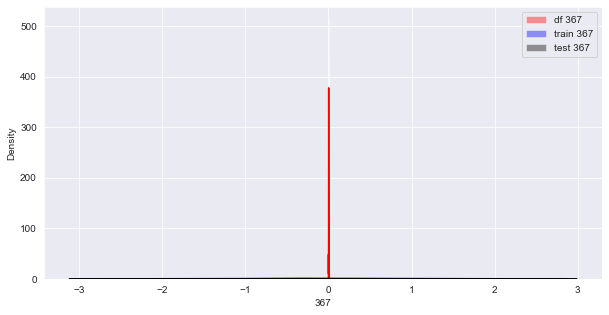

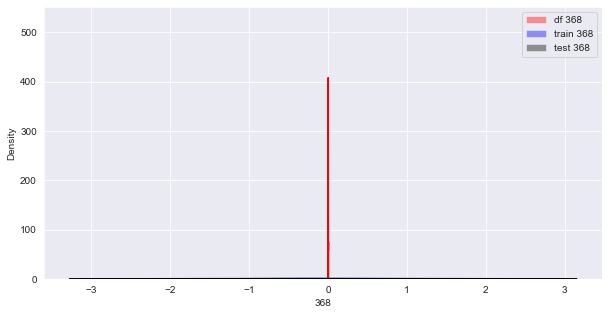

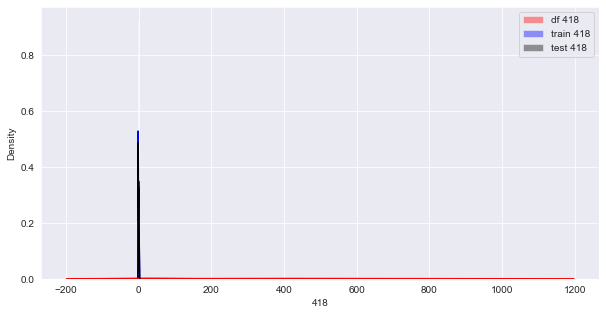

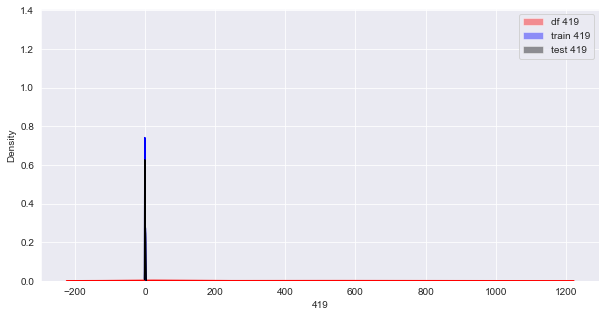

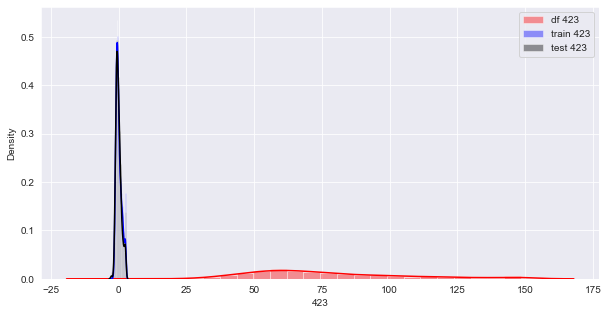

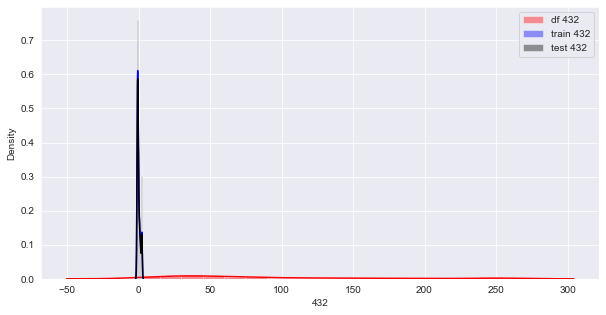

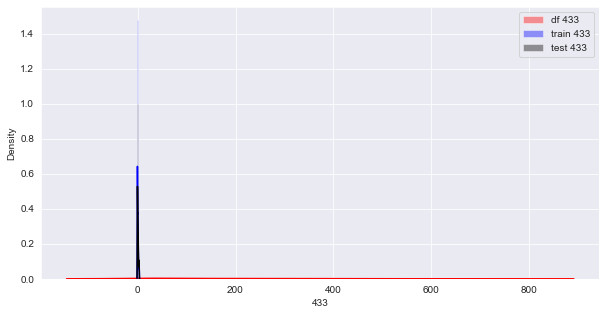

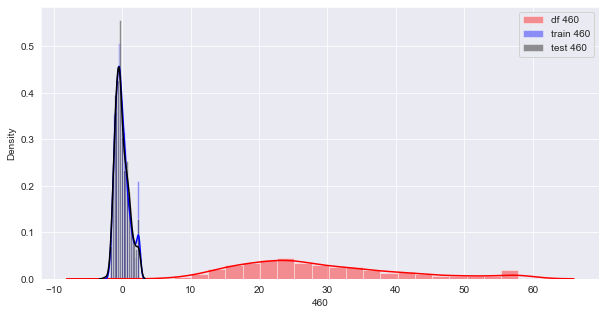

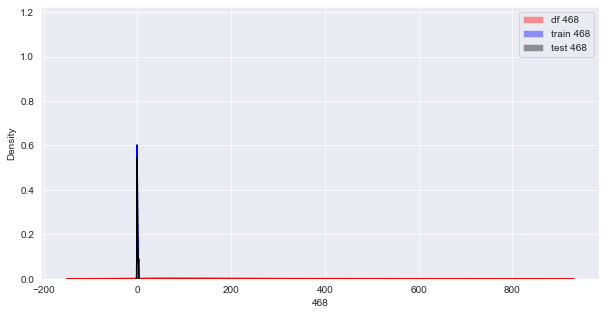

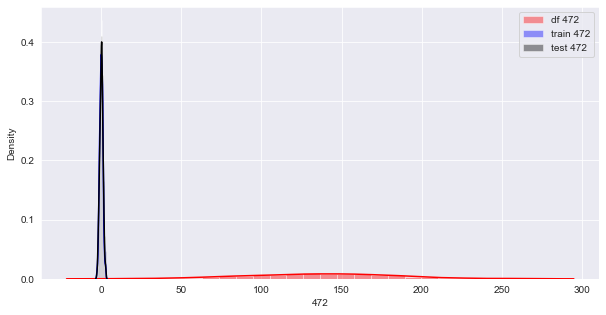

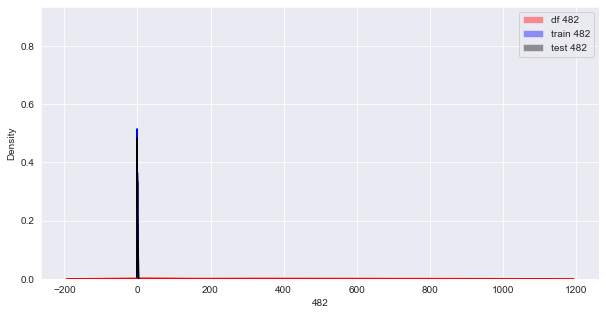

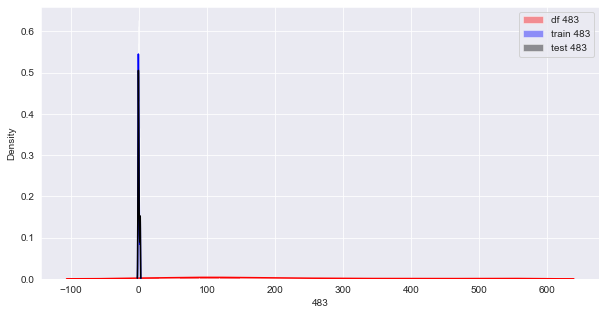

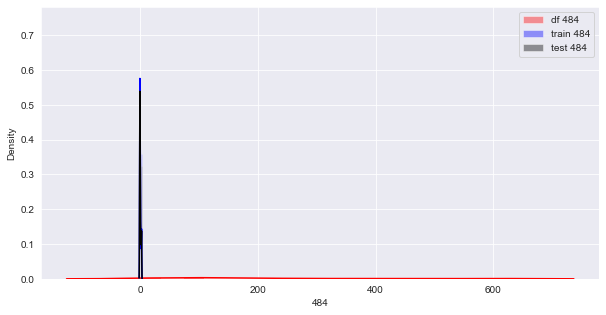

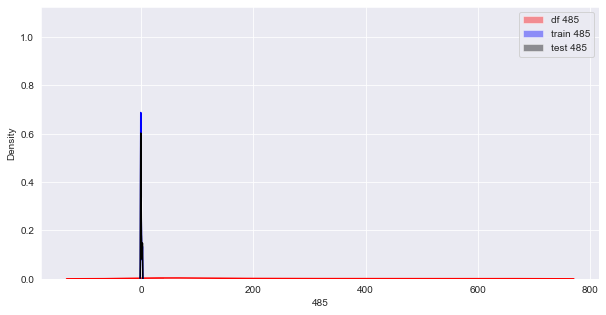

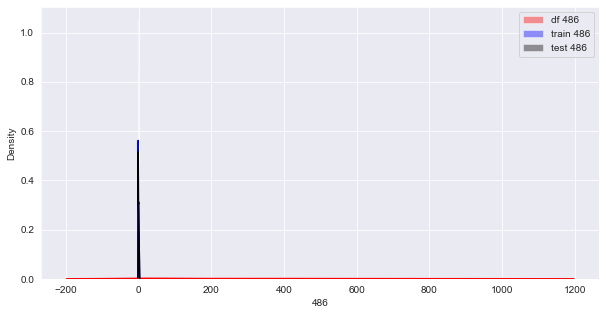

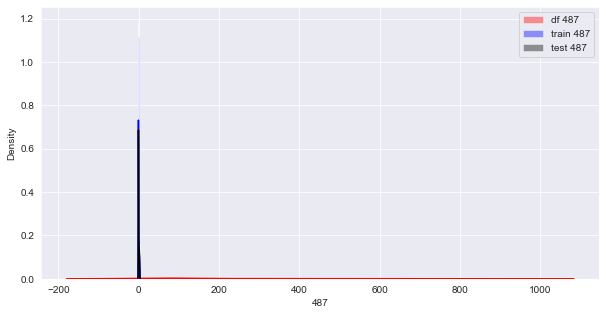

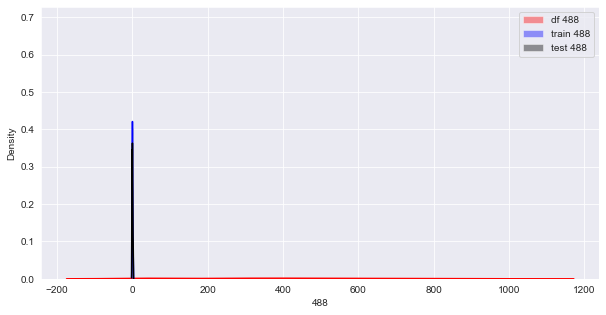

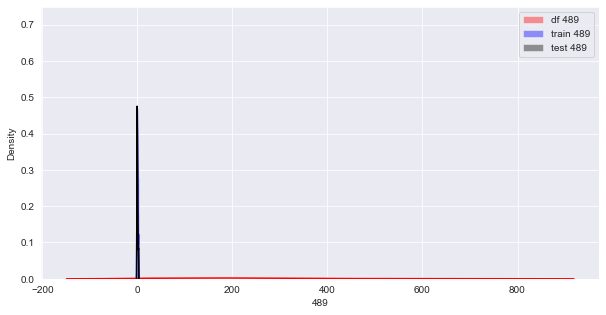

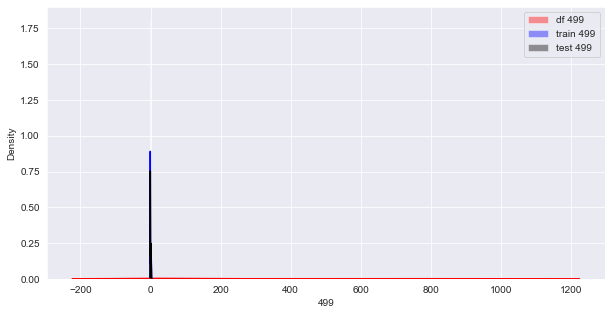

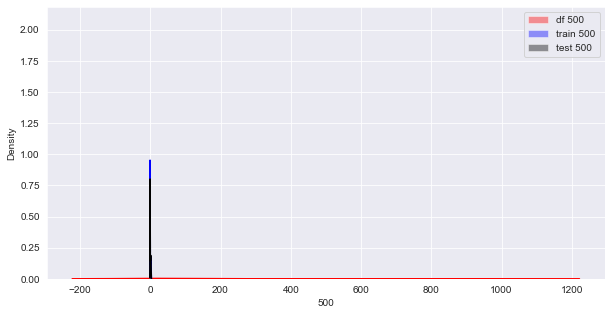

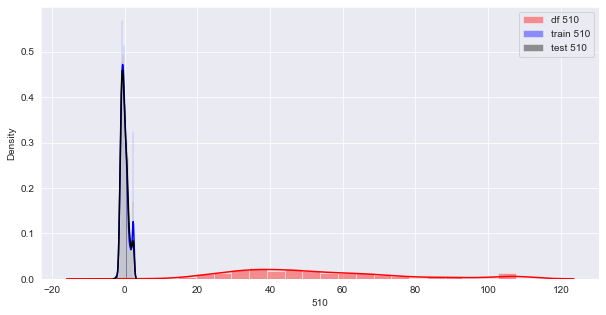

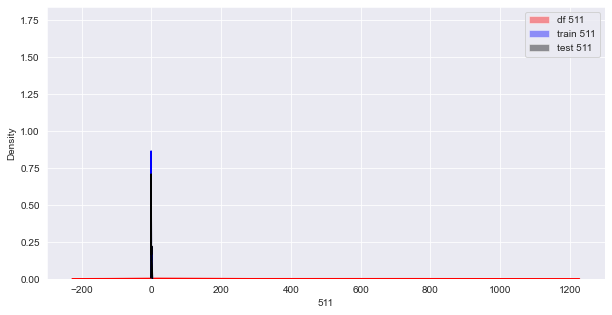

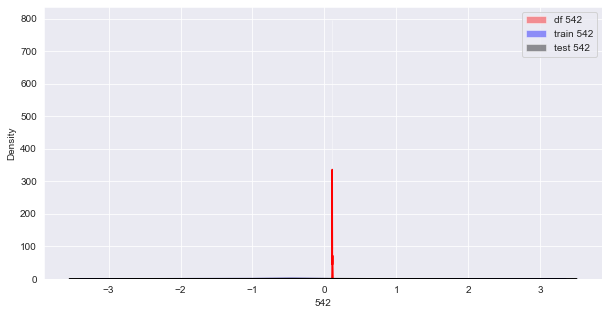

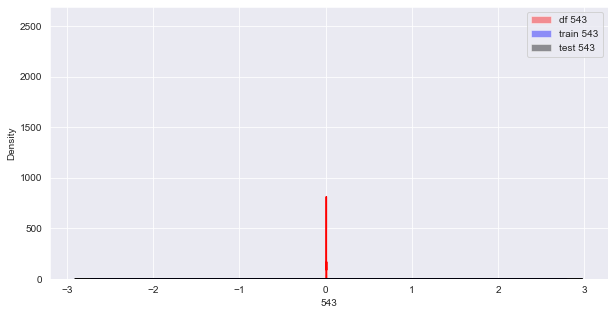

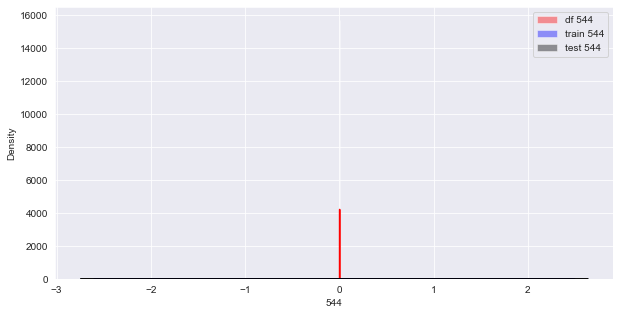

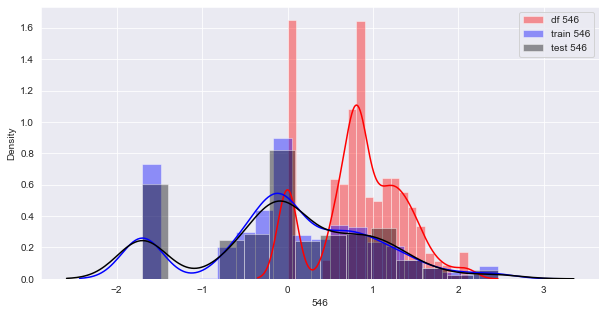

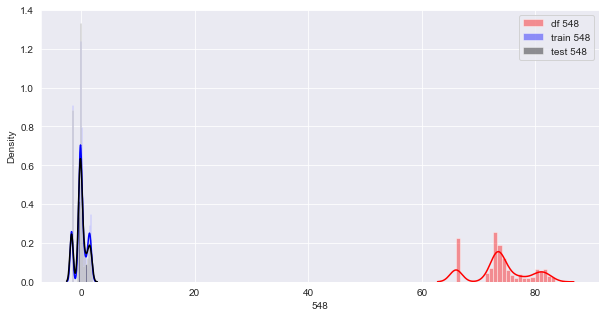

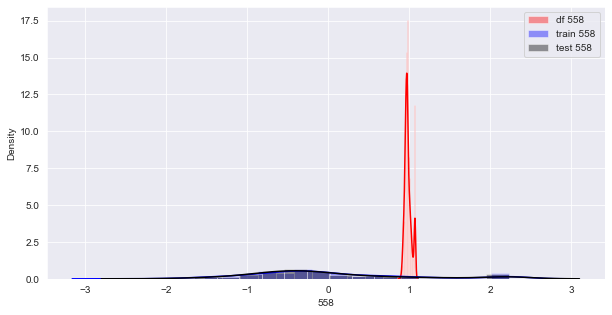

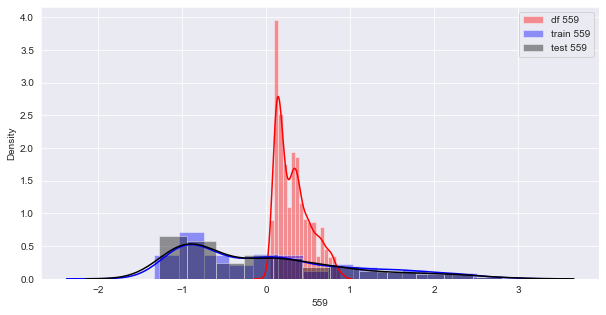

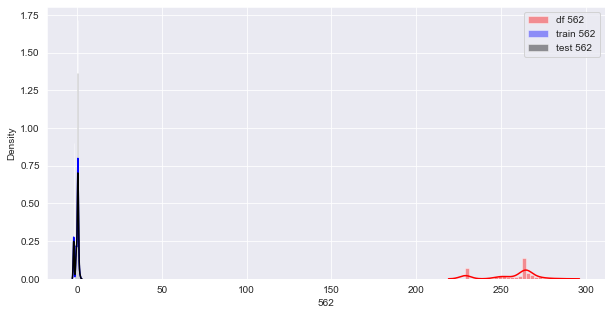

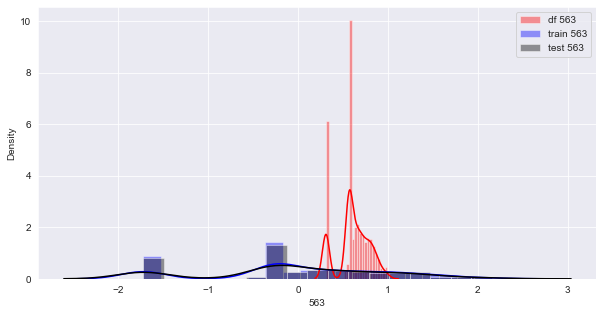

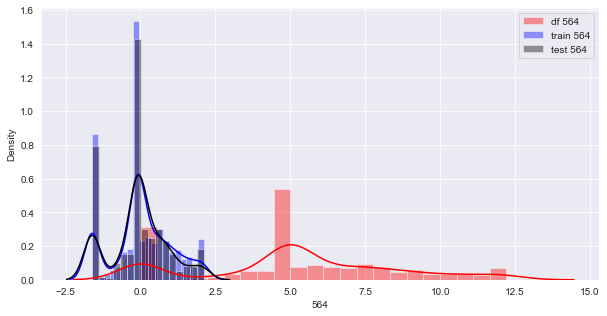

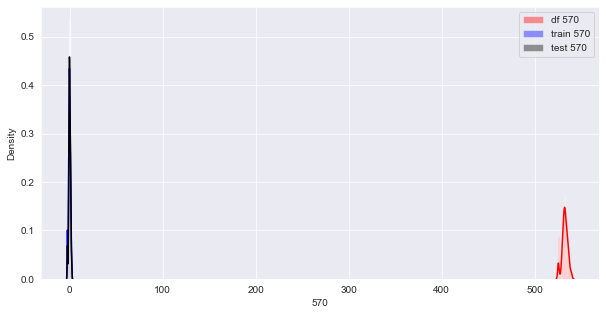

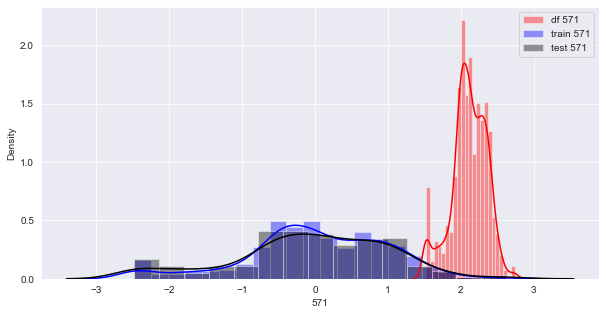

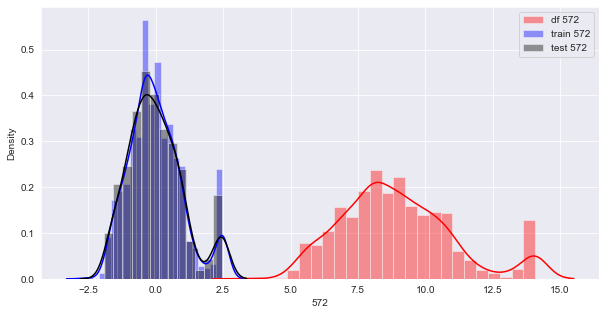

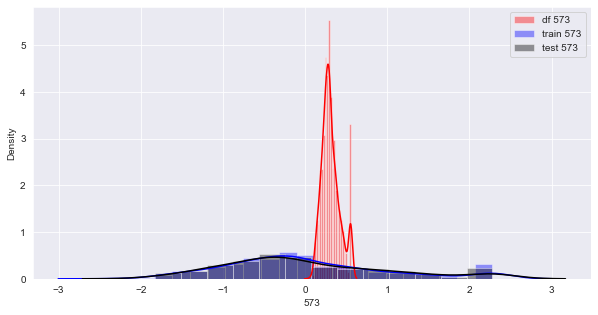

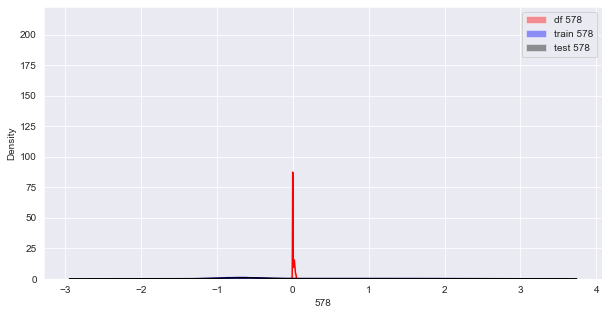

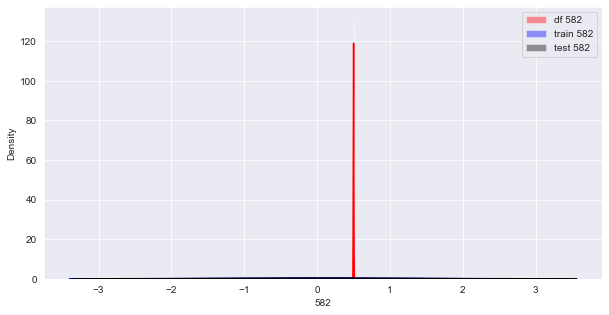

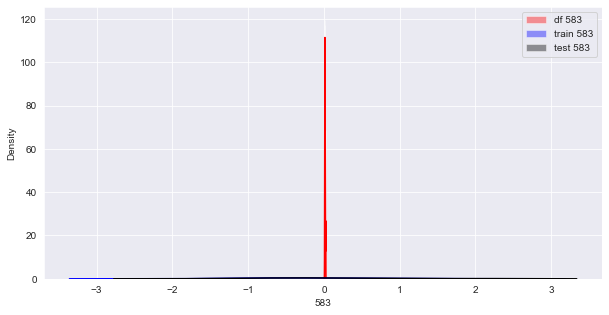

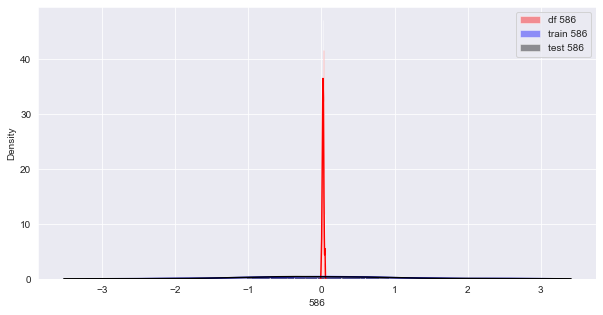

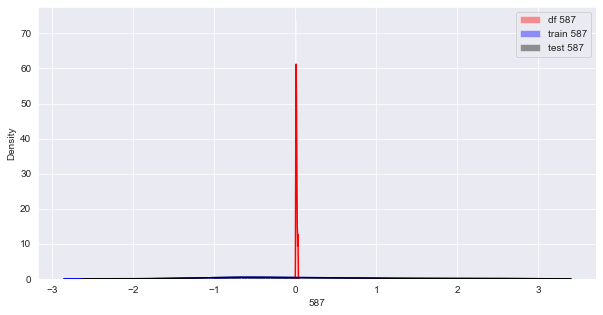

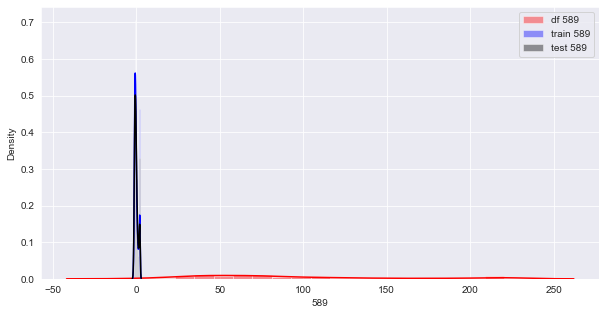

In [44]:
for col in numeric_cols:
    if col != 'Pass/Fail':
        plt.figure(figsize=(10,5))
        sns.distplot(signal[col], color = 'r', label = 'df '+col)
        sns.distplot(X_train[col], color = 'b', label = 'train '+col)
        sns.distplot(X_test[col], color = 'k', label = 'test '+col)
        plt.legend()
        plt.show()
        print()

### Observations:
- By calculating `mean` and `standard deviation` on `train`, `test` and `original data`, the statistics seem to be `similar`.
- By carrying out `Analysis of Variance(ANOVA)`, the different features seem very `different`.

## Model training, testing and tuning

In [45]:
# initialised a dictionary to hold accuracy of various models
# {model: [train_accuracy,test_accuracy]}
accuracies = {}

In [46]:
# initialised a dictionary to hold predictions of various models
# {model: [predictions]}
predictions = {}

In [47]:
actual_labels = ['Actual Fail', 'Actual Pass']
pred_labels = ['Predicted Fail', 'Predicted Pass']

In [48]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test,y_pred,labels=[0,1]) # getting the confusion matrix
    
    cm_df = pd.DataFrame(cm, index=[i for i in actual_labels], columns=[i for i in pred_labels]) # confusion matrix data frame
    
    plt.figure(figsize=(5,5))
    sns.heatmap(cm_df,annot=True,fmt='g') # plotting the heatmap
    plt.show()

In [49]:
def calculate_target_classes_in_data(y,data_set):
    print("{0} Fail    : {1} ({2:0.2f}%)".format(data_set.upper(),len(y[y[:] == 1]), (len(y[y[:] == 1])/len(y)) * 100))
    print("{0} Pass  : {1} ({2:0.2f}%)".format(data_set.upper(),len(y[y[:] == 0]), (len(y[y[:] == 0])/len(y)) * 100))

In [50]:
model_lists = [] # initialise to hold various model parameters

In [51]:
def calculate_performance_measures(y_test,y_pred,model):
    prec, rec, f1, support = precision_recall_fscore_support(y_test, y_pred, average = 'macro')
    print('Precision Score :', '%0.2f' % prec)
    print('Recall Score :', '%0.2f' % rec)
    print('F1-Score:', '%0.2f' % f1)
    acc= accuracy_score(y_test, y_pred)
    print('Accuracy Score :','%0.2f' % acc)
    model_lists.append([model, acc * 100, rec * 100, prec * 100,f1*100])

In [52]:
# checking values in train and test split
calculate_target_classes_in_data(y_train,'train')
print()
calculate_target_classes_in_data(y_test,'test')
print()

TRAIN Fail    : 73 (6.66%)
TRAIN Pass  : 1023 (93.34%)

TEST Fail    : 31 (6.58%)
TEST Pass  : 440 (93.42%)



### Observations:
- There are roughly same **proportions** of target classes in train and test splits.

In [53]:
# initialising all classifiers to be put under test
models = []
models.append(("LR", LogisticRegression()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("GNB", GaussianNB()))
models.append(("SVM-linear", SVC(kernel='linear')))
models.append(("SVM-poly", SVC(kernel='poly')))
models.append(("SVM-rbf", SVC(kernel='rbf')))
models.append(("DT", DecisionTreeClassifier()))
models.append(("RF", RandomForestClassifier()))
models.append(("AB", AdaBoostClassifier()))
models.append(("GBT", GradientBoostingClassifier()))
models.append(("XGB", XGBClassifier(verbosity=0)))
models.append(("LightGBM",LGBMClassifier()))

In [54]:
# various cassifiers crioss validated under F1 score
def cross_validation_for_different_sets(predictor,target):
    #testing models
    results = []
    names = []

    for name, model in models:
        kfold = StratifiedKFold(n_splits=10, random_state=seed,shuffle=True)
        cv_results = cross_val_score(model, predictor, target, cv=kfold,scoring='f1', error_score="raise")
        results.append(cv_results)
        names.append(name)
        msg = '%s: %f%% (%f%%)' % (name, cv_results.mean()*100, cv_results.std()*100)
        print(msg)
    
    # boxplot algorithm comparison
    fig = plt.figure(figsize=(15,7))
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

#### Not Sampled Data

LR: 21.100952% (8.685170%)
KNN: 0.000000% (0.000000%)
GNB: 24.625680% (11.644451%)
SVM-linear: 21.779748% (10.546022%)
SVM-poly: 0.000000% (0.000000%)
SVM-rbf: 0.000000% (0.000000%)
DT: 10.549867% (13.904636%)
RF: 0.000000% (0.000000%)
AB: 12.586303% (11.024919%)
GBT: 1.818182% (5.454545%)
XGB: 4.722222% (9.464847%)
LightGBM: 0.000000% (0.000000%)


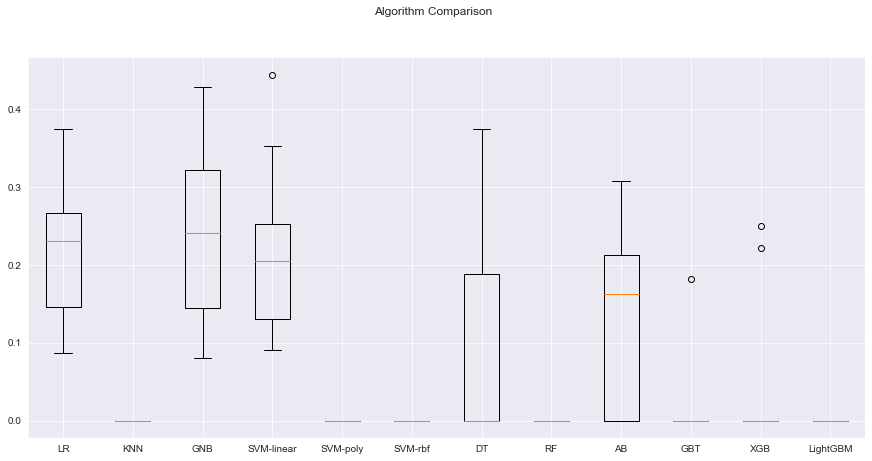

In [55]:
# calling the proper cross validation method
cross_validation_for_different_sets(predictor=X_train,target=y_train)

### Observations:
- **Gaussian Naive Bayes** seems to perform well on original data.

#### Random Under-Sampling
Randomly decreasing the frequency of the **majority** target class.

In [56]:
# Implementing random under sampling
under= RandomUnderSampler() # initialising the under sampler
X_under, y_under= under.fit_resample(X_train, y_train)

In [57]:
# checking values in train and test split
calculate_target_classes_in_data(y_under,'train')

TRAIN Fail    : 73 (50.00%)
TRAIN Pass  : 73 (50.00%)


LR: 62.690422% (17.087362%)
KNN: 53.032223% (12.091957%)
GNB: 60.061679% (10.565578%)
SVM-linear: 61.908288% (16.277128%)
SVM-poly: 23.888889% (10.030817%)
SVM-rbf: 63.897338% (10.793763%)
DT: 49.693679% (14.814498%)
RF: 56.084004% (13.728210%)
AB: 57.974359% (11.903331%)
GBT: 59.272311% (12.767664%)
XGB: 61.274510% (12.353764%)
LightGBM: 62.518868% (10.896099%)


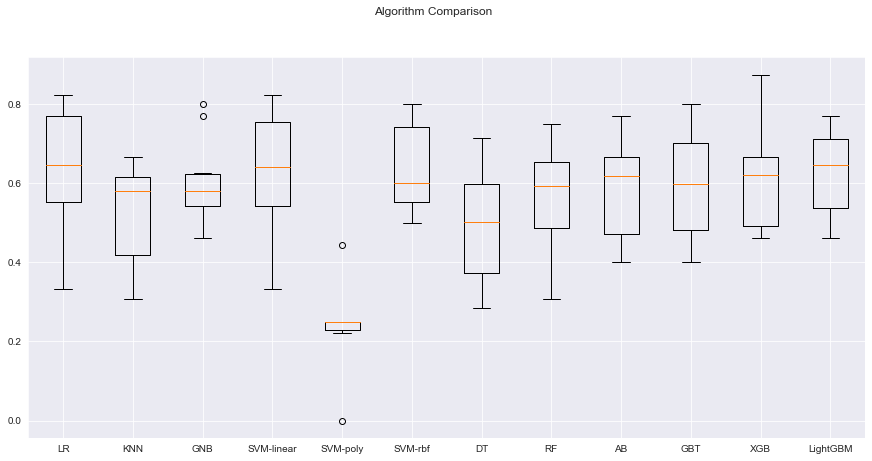

In [58]:
# calling the proper cross validation method
cross_validation_for_different_sets(predictor=X_under,target=y_under)

### Observations:
- `RandomUnderSampling` **decreased** the frequency of the **majority** class.
- The classifiers have started to perform better with sampled data.
- **Logistic Regression** and **Decision Tree** seem to perform well here.

#### Synthetic Minority Over-Sampling Technique(SMOTE)
This increases the frequency of the **minority** class based on **K-NN**.

In [59]:
# Implementing SMOTE
smt= SMOTE(k_neighbors = 5, random_state=seed) # initialising the up sampler
X_SMOTE, y_SMOTE = smt.fit_resample(X_train, y_train)

In [60]:
# checking values in train and test split
calculate_target_classes_in_data(y_SMOTE,'train')

TRAIN Fail    : 1023 (50.00%)
TRAIN Pass  : 1023 (50.00%)


LR: 94.765829% (1.080104%)
KNN: 69.532870% (0.901452%)
GNB: 85.596728% (1.850483%)
SVM-linear: 94.886977% (1.669017%)
SVM-poly: 99.854130% (0.222824%)
SVM-rbf: 99.951220% (0.146341%)
DT: 90.606188% (2.913250%)
RF: 99.409800% (0.576364%)
AB: 93.379479% (2.276925%)
GBT: 97.906928% (0.611290%)
XGB: 98.728332% (0.734552%)
LightGBM: 99.018503% (0.621461%)


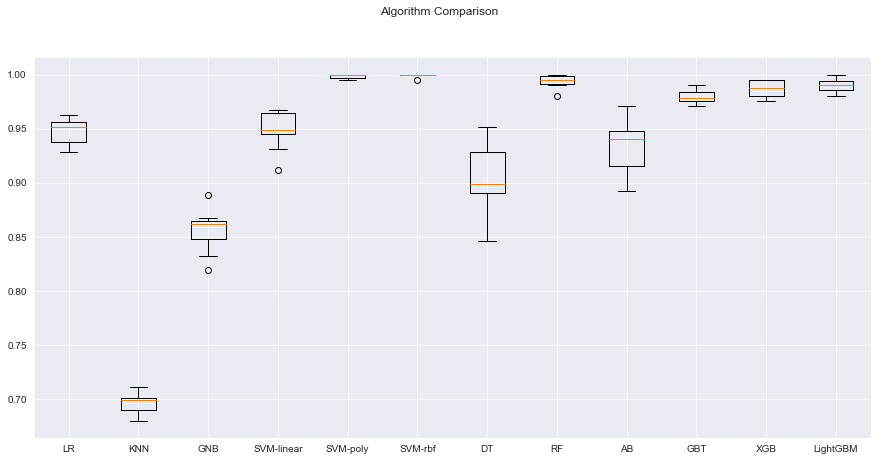

In [61]:
# calling the proper cross validation method
cross_validation_for_different_sets(predictor=X_SMOTE,target=y_SMOTE)

### Observations:
- `SMOTE` **increased** the frequency of the **minority** class.
- The classifiers have started to perform better with sampled data.
- **SVM with poly and rbf kernel** and **LightGBM** seem to perform well here.

#### Random Over-Sampling
Randomly increasing the frequency of the **minority** target class.

In [62]:
# Implementing random over sampling
over= RandomOverSampler() # initialising the over sampler
X_over, y_over= over.fit_resample(X_train, y_train)

In [63]:
# checking values in train and test split
calculate_target_classes_in_data(y_over,'train')

TRAIN Fail    : 1023 (50.00%)
TRAIN Pass  : 1023 (50.00%)


LR: 94.609819% (1.247462%)
KNN: 94.519748% (1.253212%)
GNB: 72.566539% (3.665249%)
SVM-linear: 94.886977% (1.669017%)
SVM-poly: 99.951220% (0.146341%)
SVM-rbf: 99.951220% (0.146341%)
DT: 96.007626% (1.862971%)
RF: 100.000000% (0.000000%)
AB: 95.184213% (1.511779%)
GBT: 99.374256% (0.677599%)
XGB: 99.662296% (0.611045%)
LightGBM: 99.806285% (0.320189%)


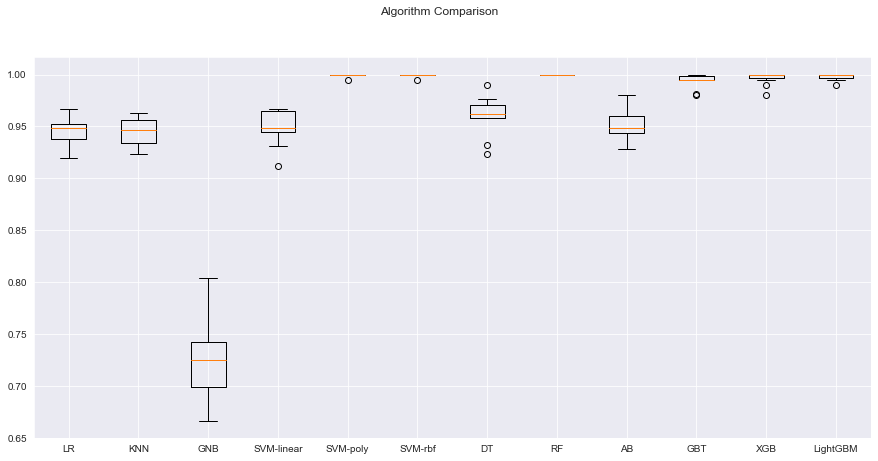

In [64]:
# calling the proper cross validation method
cross_validation_for_different_sets(predictor=X_over,target=y_over)

### Observations:
- `RandomOverSampling` **increased** the frequency of the **minority** class.
- The classifiers have started to perform better with sampled data.
- **SVM with poly and rbf kernel**, **Random Forest**, **Gradient Boost** seem to perform well here.

#### Gaussain Naive Bayes on Original Dataset

In [65]:
gnb = GaussianNB() # initialise GNB
gnb.fit(X_train, y_train) # fit the train data

GaussianNB()

In [66]:
# predict on test data
y_pred = gnb.predict(X_test)
predictions['GNB with Original Data'] = y_pred

In [67]:
train_accuracy = gnb.score(X_train,y_train)
test_accuracy = gnb.score(X_test,y_test)
accuracies['GNB with Original Data'] = [train_accuracy,test_accuracy]

In [68]:
print(f'The accuracy score of model on train data is {round(train_accuracy,4)*100}%')
print(f'The accuracy score of model on test data is {round(test_accuracy,4)*100}%')

The accuracy score of model on train data is 83.67%
The accuracy score of model on test data is 82.59%


In [69]:
print('The classification report is::')
print(classification_report(y_test,y_pred))

The classification report is::
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       440
           1       0.19      0.52      0.28        31

    accuracy                           0.83       471
   macro avg       0.58      0.68      0.59       471
weighted avg       0.91      0.83      0.86       471



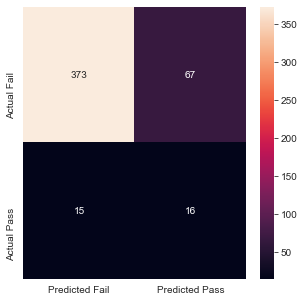

In [70]:
plot_confusion_matrix(y_test,y_pred)

In [71]:
calculate_performance_measures(y_test,y_pred,'GNB with Original Data')

Precision Score : 0.58
Recall Score : 0.68
F1-Score: 0.59
Accuracy Score : 0.83


### Observations:
- The model performs equally well on train and test data.
- There are few misclassifications by the model.

#### Gaussian Naive Bayes on Under sampled Data

In [72]:
gnb = GaussianNB() # initialise GNB
gnb.fit(X_under, y_under) # fit the train data

GaussianNB()

In [73]:
# predict on test data
y_pred = gnb.predict(X_test)
predictions['GNB with Under Sampled Data'] = y_pred

In [74]:
train_accuracy = gnb.score(X_under,y_under)
test_accuracy = gnb.score(X_test,y_test)
accuracies['GNB with Under Sampled Data'] = [train_accuracy,test_accuracy]

In [75]:
print(f'The accuracy score of model on train data is {round(train_accuracy,4)*100}%')
print(f'The accuracy score of model on test data is {round(test_accuracy,4)*100}%')

The accuracy score of model on train data is 78.77%
The accuracy score of model on test data is 64.97%


In [76]:
print('The classification report is::')
print(classification_report(y_test,y_pred))

The classification report is::
              precision    recall  f1-score   support

           0       0.96      0.65      0.78       440
           1       0.11      0.61      0.19        31

    accuracy                           0.65       471
   macro avg       0.54      0.63      0.48       471
weighted avg       0.90      0.65      0.74       471



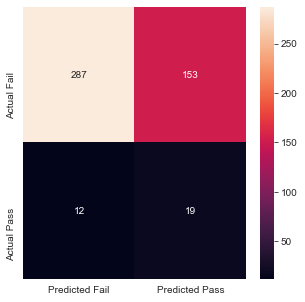

In [77]:
plot_confusion_matrix(y_test,y_pred)

In [78]:
calculate_performance_measures(y_test,y_pred,'GNB with Under Sampled Data')

Precision Score : 0.54
Recall Score : 0.63
F1-Score: 0.48
Accuracy Score : 0.65


### Observations:
- The model performs equally well on train and test data.
- There are few misclassifications by the model.

#### LightGBM on SMOTE sampled Dataset with Random Search CV
We will try to fit a `LightGBM` classifier on `SMOTE` sampled data with `RandomizedSearchCV` to tune best hyper-parameters.

In [79]:
# distribution of parameters to search from
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

sample = 100  # number of iterations

In [80]:
lgb = LGBMClassifier(max_depth=-1, random_state=seed, silent=True, metric='f1', n_jobs=4, n_estimators=2000) # initialising the LGBM classifier

# initialising the random search CV for tuning hyper-parameters
gs = RandomizedSearchCV(
    estimator=lgb, param_distributions=param_test, 
    n_iter=sample,
    scoring='f1',
    cv=5,
    refit=True,
    random_state=314,
    verbose=True)

# fit on SMOTE samples
gs.fit(X_SMOTE, y_SMOTE)

# getting the best parameters
gs.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'colsample_bytree': 0.952164731370897,
 'min_child_samples': 111,
 'min_child_weight': 0.01,
 'num_leaves': 38,
 'reg_alpha': 0,
 'reg_lambda': 0.1,
 'subsample': 0.3029313662262354}

In [81]:
# initialising LGBM classifier with best hyper-parameters
lgb=LGBMClassifier(colsample_bytree=0.95,
 min_child_samples= 111,
 min_child_weight= 0.01,
 num_leaves= 38,
 reg_alpha= 0,
 reg_lambda= 0.1,
 subsample=0.30)

lgb.fit(X_SMOTE,y_SMOTE) # fit on train data

LGBMClassifier(colsample_bytree=0.95, min_child_samples=111,
               min_child_weight=0.01, num_leaves=38, reg_alpha=0,
               reg_lambda=0.1, subsample=0.3)

In [82]:
# predict on test data
y_pred = lgb.predict(X_test)
predictions['LGBM with SMOTE Sampled Data'] = y_pred

In [83]:
train_accuracy = lgb.score(X_SMOTE,y_SMOTE)
test_accuracy = lgb.score(X_test,y_test)
accuracies['LGBM with SMOTE Sampled Data'] = [train_accuracy,test_accuracy]

In [84]:
print(f'The accuracy score of model on train data is {round(train_accuracy,4)*100}%')
print(f'The accuracy score of model on test data is {round(test_accuracy,4)*100}%')

The accuracy score of model on train data is 100.0%
The accuracy score of model on test data is 92.57%


In [85]:
print('The classification report is::')
print(classification_report(y_test,y_pred))

The classification report is::
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       440
           1       0.17      0.03      0.05        31

    accuracy                           0.93       471
   macro avg       0.55      0.51      0.51       471
weighted avg       0.88      0.93      0.90       471



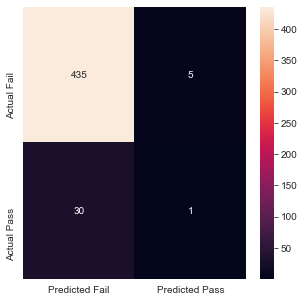

In [86]:
plot_confusion_matrix(y_test,y_pred)

In [87]:
calculate_performance_measures(y_test,y_pred,'LGBM with SMOTE Sampled Data')

Precision Score : 0.55
Recall Score : 0.51
F1-Score: 0.51
Accuracy Score : 0.93


### Observations:
- The model performs extremely well on train and test data.
- There are few misclassifications by the model.

#### RandomForest on Random over sampled Dataset with Random Search CV
We will try to fit a `RandomForest` classifier on `over-sampled` data with `RandomizedSearchCV` to tune best hyper-parameters.

In [88]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 50)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = range(2,100,5)
# Minimum number of samples required at each leaf node
min_samples_leaf = range(1,100,10)
# Method of selecting samples for training each tree
bootstrap = [True, False]

# distribution of parameters to search from
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
                'criterion':['gini','entropy']}

In [89]:
rf = RandomForestClassifier() # initialising the RF classifier

# initialising the random search CV for tuning hyper-parameters
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv = 5, verbose=2, random_state=90, n_jobs = -1)

# fit on SMOTE samples
rf_random.fit(X_over, y_over)

# getting the best parameters
rf_random.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_estimators': 463,
 'min_samples_split': 82,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 110,
 'criterion': 'gini',
 'bootstrap': False}

In [90]:
# initialising RF classifier with best hyper-parameters
rf = RandomForestClassifier(n_estimators=463,
 min_samples_split= 82,
 min_samples_leaf=1,
 max_features= 'sqrt',
 max_depth= 110,
 criterion= 'gini',
 bootstrap= False)

rf.fit(X_over, y_over) # fit on train data

RandomForestClassifier(bootstrap=False, max_depth=110, max_features='sqrt',
                       min_samples_split=82, n_estimators=463)

In [91]:
# predict on test data
y_pred = rf.predict(X_test)
predictions['RF with Over Sampled Data'] = y_pred

In [92]:
train_accuracy = rf.score(X_over,y_over)
test_accuracy = rf.score(X_test,y_test)
accuracies['RF with Over Sampled Data'] = [train_accuracy,test_accuracy]

In [93]:
print(f'The accuracy score of model on train data is {round(train_accuracy,4)*100}%')
print(f'The accuracy score of model on test data is {round(test_accuracy,4)*100}%')

The accuracy score of model on train data is 100.0%
The accuracy score of model on test data is 93.42%


In [94]:
print('The classification report is::')
print(classification_report(y_test,y_pred))

The classification report is::
              precision    recall  f1-score   support

           0       0.93      1.00      0.97       440
           1       0.00      0.00      0.00        31

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471



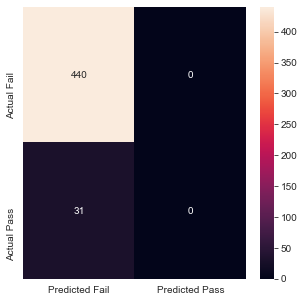

In [95]:
plot_confusion_matrix(y_test,y_pred)

In [96]:
calculate_performance_measures(y_test,y_pred,'RF with Over Sampled Data')

Precision Score : 0.47
Recall Score : 0.50
F1-Score: 0.48
Accuracy Score : 0.93


### Observations:
- The model performs extremely well on train and test data.
- There are few misclassifications by the model.

#### SVM with under-sampled data and Grid Search CV
We will try to fit a `SVM` classifier on `under-sampled` data with `GridSearchCV` to tune best hyper-parameters.

In [97]:
# hyper-parameters to search from
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

# grid search classifier
svm_grid= GridSearchCV(SVC(), param_grid, verbose = 2,cv=5, n_jobs = -1)
 
# fit on over samples
svm_grid.fit(X_over, y_over)

# getting the best parameters
svm_grid.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [98]:
# initialising SVM classifier with best hyper-parameters
svc_cv = SVC(kernel = 'rbf', gamma = 1, C = 1,probability=True)

# fit on train data
svc_cv.fit(X_over,y_over)

SVC(C=1, gamma=1, probability=True)

In [99]:
# predict on test data
y_pred = svc_cv.predict(X_test)
predictions['SVM with Over Sampled Data'] = y_pred

In [100]:
train_accuracy = svc_cv.score(X_over,y_over)
test_accuracy = svc_cv.score(X_test,y_test)
accuracies['SVM with Over Sampled Data'] = [train_accuracy,test_accuracy]

In [101]:
print(f'The accuracy score of model on train data is {round(train_accuracy,4)*100}%')
print(f'The accuracy score of model on test data is {round(test_accuracy,4)*100}%')

The accuracy score of model on train data is 100.0%
The accuracy score of model on test data is 93.42%


In [102]:
print('The classification report is::')
print(classification_report(y_test,y_pred))

The classification report is::
              precision    recall  f1-score   support

           0       0.93      1.00      0.97       440
           1       0.00      0.00      0.00        31

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471



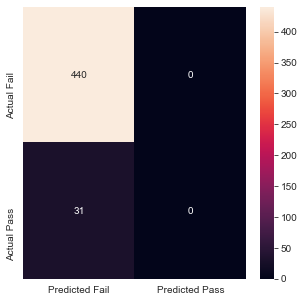

In [103]:
plot_confusion_matrix(y_test,y_pred)

In [104]:
calculate_performance_measures(y_test,y_pred,'SVM with Over Sampled Data')

Precision Score : 0.47
Recall Score : 0.50
F1-Score: 0.48
Accuracy Score : 0.93


### Observations:
- The model performs well in train and test data but as per confusion matrix, it is a bad predictor.
- There are high misclassifications.

### Algorithm Comparison

In [105]:
model_df = pd.DataFrame(model_lists, columns = ['Model', 'Accuracy Scores on Test', 'Recall Score', 'Precision Score','F1 Score'])
model_df

Model  Accuracy Scores on Test  Recall Score  \
0        GNB with Original Data                82.590234     68.192815   
1   GNB with Under Sampled Data                64.968153     63.258798   
2  LGBM with SMOTE Sampled Data                92.569002     51.044721   
3     RF with Over Sampled Data                93.418259     50.000000   
4    SVM with Over Sampled Data                93.418259     50.000000   

   Precision Score   F1 Score  
0        57.705565  59.083397  
1        53.516567  48.195871  
2        55.107527  50.769001  
3        46.709130  48.298573  
4        46.709130  48.298573

#### ROC-AUC plot

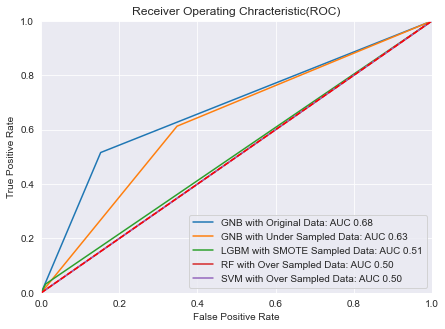

In [106]:
plt.figure(figsize=(7,5))
for model, predicted in predictions.items(): # for each prediction of each of the model
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predicted)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, label='%s: AUC %0.2f'% (model,roc_auc))

plt.plot([0,1],[0,1],'r--') # random model
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Chracteristic(ROC)')
plt.legend(loc='lower right')
plt.show()

In [107]:
accuracy_df = pd.DataFrame(accuracies,index=['Train Accuracy','Test Accuracy'])
accuracy_df

GNB with Original Data  GNB with Under Sampled Data  \
Train Accuracy                0.836679                     0.787671   
Test Accuracy                 0.825902                     0.649682   

                LGBM with SMOTE Sampled Data  RF with Over Sampled Data  \
Train Accuracy                       1.00000                   1.000000   
Test Accuracy                        0.92569                   0.934183   

                SVM with Over Sampled Data  
Train Accuracy                    1.000000  
Test Accuracy                     0.934183

### Observations:
- `Gaussian Naive Bayes` classifier performs well both over `train` and `test` data with an accuracy of **82%** and reasonable `recall`. This model seems to **generalize** well.
- Other models like `Light Gradient Boost`, `Random Forest`, `SVM` do extremely well in `train` data, but drop in `test` data. So the models do not generalize and seem to **over-fit**.

#### Principal Component Analysis(PCA)
We will perform `PCA` to **reduce** dimensions and check if our model performance increases.

In [108]:
# copying original data frame
signal = signal_df.copy()

# dropping the Time column
signal.drop(['Time'],axis=1,inplace=True)

# dropping the columns the have constant signal
cols = signal.select_dtypes([np.number]).columns
std = signal[cols].std()
cols_to_drop = std[std==0].index
signal.drop(cols_to_drop, axis=1,inplace=True)

#label encoding the target class
signal['Pass/Fail'].replace([-1,1],[0,1],inplace=True)

# replacing the NaN with zero and considering it as no signal
signal.fillna(0,inplace=True)

row,column=signal.shape
print('The dataset contains', row, 'rows and', column, 'columns')

The dataset contains 1567 rows and 475 columns


In [109]:
# segregate into predictors and target
X = signal.drop(['Pass/Fail'],axis=1)

y = signal['Pass/Fail']

In [110]:
# scaling independant features
X_scaled = X.apply(zscore)

X_scaled.dropna(axis=1,inplace=True)

In [111]:
# extracting componenets that explaint 95% of the variation
pca = PCA(.95)
pca_ = pca.fit_transform(X_scaled)
pca

PCA(n_components=0.95)

In [112]:
# scaled independant attributes explaining 95% varaince
X_pca = pca.transform(X)

In [113]:
pca.explained_variance_

array([25.93593991, 18.59287319, 14.32179009, 12.23591513, 10.63194133,
        9.90123235,  9.32775892,  8.58057519,  8.17436353,  8.08246094,
        7.12278823,  6.87719205,  6.59716313,  6.3975767 ,  6.22173838,
        6.12527462,  5.99244845,  5.64088928,  5.54809321,  5.32487951,
        5.23974818,  5.12453061,  4.92349097,  4.89172322,  4.78569072,
        4.57489247,  4.53074348,  4.5131774 ,  4.41272848,  4.34260772,
        4.24914012,  4.12486409,  4.0352558 ,  3.84114743,  3.78399455,
        3.68287986,  3.63419647,  3.5705301 ,  3.50299795,  3.46936862,
        3.39397366,  3.33625841,  3.31433983,  3.18311325,  3.14195881,
        3.10974734,  3.09094993,  2.99053519,  2.97587144,  2.96435817,
        2.92097563,  2.83044267,  2.78447553,  2.70204847,  2.69648951,
        2.65684455,  2.61689317,  2.57133341,  2.53004392,  2.44121205,
        2.4257052 ,  2.39284654,  2.35381752,  2.32996725,  2.28625258,
        2.22331548,  2.19309031,  2.16022365,  2.13058178,  2.11

In [114]:
X_pca.shape

(1567, 158)

### Observations:
- We successfully reduced our dimensions from 475 to **158**.
- These dimensions explain **95%** of variance in the data.
- We will use these to build our models.

In [115]:
# splitting data into training and test set for independent attributes
X_train, X_test, y_train, y_test =train_test_split(X_pca,y, test_size=.30,random_state=seed,stratify=y)

In [116]:
# checking values in train and test split
calculate_target_classes_in_data(y_train,'train')
print()
calculate_target_classes_in_data(y_test,'test')
print()

TRAIN Fail    : 73 (6.66%)
TRAIN Pass  : 1023 (93.34%)

TEST Fail    : 31 (6.58%)
TEST Pass  : 440 (93.42%)



### Observations:
- There are roughly same proportions of target classes in train and test splits.

#### Random Under-Sampling
Randomly decreasing the frequency of the **majority** target class.

In [117]:
# Implementing random under sampling
under= RandomUnderSampler() # initialising the under sampler
X_under, y_under= under.fit_resample(X_train, y_train)

In [118]:
# checking values in train and test split
calculate_target_classes_in_data(y_under,'train')

TRAIN Fail    : 73 (50.00%)
TRAIN Pass  : 73 (50.00%)


#### Synthetic Minority Over-Sampling Technique(SMOTE)
This increases the frequency of the **minority** class based on **K-NN**.

In [119]:
# Implementing SMOTE
smt= SMOTE(k_neighbors = 5, random_state=seed) # initialising the up sampler
X_SMOTE, y_SMOTE = smt.fit_resample(X_train, y_train)

In [120]:
# checking values in train and test split
calculate_target_classes_in_data(y_SMOTE,'train')

TRAIN Fail    : 1023 (50.00%)
TRAIN Pass  : 1023 (50.00%)


#### Random Over-Sampling
Randomly increasing the frequency of the **minority** target class.

In [121]:
# Implementing random over sampling
over= RandomOverSampler() # initialising the over sampler
X_over, y_over= over.fit_resample(X_train, y_train)

In [122]:
# checking values in train and test split
calculate_target_classes_in_data(y_over,'train')

TRAIN Fail    : 1023 (50.00%)
TRAIN Pass  : 1023 (50.00%)


In [123]:
# initialised a dictionary to hold accuracy of various models
# {model: [train_accuracy,test_accuracy]}
accuracies = {}

# initialised a dictionary to hold predictions of various models
# {model: [predictions]}
predictions = {}

model_lists = [] # initialise to hold various model parameters

#### Gaussain Naive Bayes on Original Dataset

In [124]:
gnb = GaussianNB() # initialise GNB
gnb.fit(X_train, y_train) # fit the train data

GaussianNB()

In [125]:
# predict on test data
y_pred = gnb.predict(X_test)
predictions['GNB with Original Data'] = y_pred

In [126]:
train_accuracy = gnb.score(X_train,y_train)
test_accuracy = gnb.score(X_test,y_test)
accuracies['GNB with Original Data'] = [train_accuracy,test_accuracy]

In [127]:
print(f'The accuracy score of model on train data is {round(train_accuracy,4)*100}%')
print(f'The accuracy score of model on test data is {round(test_accuracy,4)*100}%')

The accuracy score of model on train data is 36.41%
The accuracy score of model on test data is 38.22%


In [128]:
print('The classification report is::')
print(classification_report(y_test,y_pred))

The classification report is::
              precision    recall  f1-score   support

           0       0.93      0.37      0.53       440
           1       0.06      0.58      0.11        31

    accuracy                           0.38       471
   macro avg       0.49      0.47      0.32       471
weighted avg       0.87      0.38      0.50       471



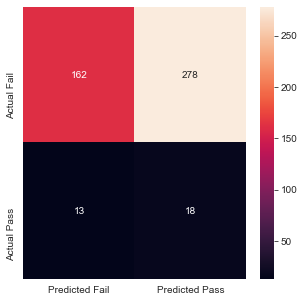

In [129]:
plot_confusion_matrix(y_test,y_pred)

In [130]:
calculate_performance_measures(y_test,y_pred,'GNB with Original Data')

Precision Score : 0.49
Recall Score : 0.47
F1-Score: 0.32
Accuracy Score : 0.38


### Observations:
- The model performs badly on train and test data.
- There are many misclassifications by the model.

#### Gaussian Naive Bayes on Under sampled Data

In [131]:
gnb = GaussianNB() # initialise GNB
gnb.fit(X_under, y_under) # fit the train data

GaussianNB()

In [132]:
# predict on test data
y_pred = gnb.predict(X_test)
predictions['GNB with Under Sampled Data'] = y_pred

In [133]:
train_accuracy = gnb.score(X_under,y_under)
test_accuracy = gnb.score(X_test,y_test)
accuracies['GNB with Under Sampled Data'] = [train_accuracy,test_accuracy]

In [134]:
print(f'The accuracy score of model on train data is {round(train_accuracy,4)*100}%')
print(f'The accuracy score of model on test data is {round(test_accuracy,4)*100}%')

The accuracy score of model on train data is 62.33%
The accuracy score of model on test data is 38.43%


In [135]:
print('The classification report is::')
print(classification_report(y_test,y_pred))

The classification report is::
              precision    recall  f1-score   support

           0       0.93      0.37      0.53       440
           1       0.06      0.61      0.12        31

    accuracy                           0.38       471
   macro avg       0.50      0.49      0.32       471
weighted avg       0.87      0.38      0.50       471



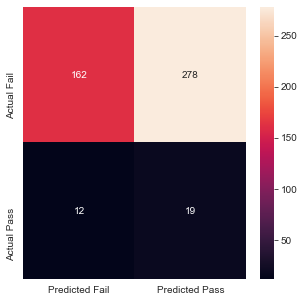

In [136]:
plot_confusion_matrix(y_test,y_pred)

In [137]:
calculate_performance_measures(y_test,y_pred,'GNB with Under Sampled Data')

Precision Score : 0.50
Recall Score : 0.49
F1-Score: 0.32
Accuracy Score : 0.38


### Observations:
- The model performs badly on train and test data.
- There are high misclassifications by the model.

#### Logistic Regression on original Dataset with Grid Search CV
We will try to fit a `LogisticRegression` classifier on original data with `GridSearchCV` to tune best hyper-parameters.

In [138]:
# hyper-parameters to search from
param_grid = [    
    {'penalty' : ['l1', 'l2'],
    'C' : [1,2,4],
    'solver' : ['lbfgs','saga'],
    'max_iter' : [100, 1000]
    }
]

# logistic classifier
lg=LogisticRegression()

# grid search cv
log = GridSearchCV(lg, param_grid = param_grid, cv = 5, verbose=2, n_jobs=-1)

# fit on original samples
log.fit(X_train,y_train)

# getting the best parameters
log.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


LogisticRegression(C=1, penalty='l1', solver='saga')

In [139]:
# initialising Logistic Regression classifier with best hyper-parameters
lg = LogisticRegression(C=1, max_iter=1000, penalty='l1', solver='saga')

# fit on train data
lg.fit(X_train,y_train)

LogisticRegression(C=1, max_iter=1000, penalty='l1', solver='saga')

In [140]:
# predict on test data
y_pred = lg.predict(X_test)
predictions['Logistic Regression with Original Data'] = y_pred

In [141]:
train_accuracy = lg.score(X_under,y_under)
test_accuracy = lg.score(X_test,y_test)
accuracies['Logistic Regression with Original Data'] = [train_accuracy,test_accuracy]

In [142]:
print(f'The accuracy score of model on train data is {round(train_accuracy,4)*100}%')
print(f'The accuracy score of model on test data is {round(test_accuracy,4)*100}%')

The accuracy score of model on train data is 51.370000000000005%
The accuracy score of model on test data is 93.21000000000001%


In [143]:
print('The classification report is::')
print(classification_report(y_test,y_pred))

The classification report is::
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       440
           1       0.00      0.00      0.00        31

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471



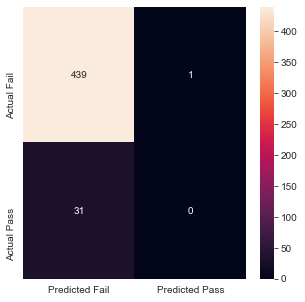

In [144]:
plot_confusion_matrix(y_test,y_pred)

In [145]:
calculate_performance_measures(y_test,y_pred,'Logistic Regression with Original Data')

Precision Score : 0.47
Recall Score : 0.50
F1-Score: 0.48
Accuracy Score : 0.93


### Observations:
- The model performs badly on train and but extremely well on test data, but as per confusion matrix could not predict any `Pass`.
- There are high misclassifications by the model.

#### LightGBM on SMOTE sampled Dataset with Random Search CV
We will try to fit a `LightGBM` classifier on `SMOTE` sampled data with `RandomizedSearchCV` to tune best hyper-parameters.

In [146]:
# distribution of parameters to search from
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

sample = 100  # number of iterations

In [147]:
lgb = LGBMClassifier(max_depth=-1, random_state=seed, silent=True, metric='f1', n_jobs=4, n_estimators=2000) # initialising the LGBM classifier

# initialising the random search CV for tuning hyper-parameters
gs = RandomizedSearchCV(
    estimator=lgb, param_distributions=param_test, 
    n_iter=sample,
    scoring='f1',
    cv=5,
    refit=True,
    random_state=314,
    verbose=True)

# fit on SMOTE samples
gs.fit(X_SMOTE, y_SMOTE)

# getting the best parameters
gs.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'colsample_bytree': 0.952164731370897,
 'min_child_samples': 111,
 'min_child_weight': 0.01,
 'num_leaves': 38,
 'reg_alpha': 0,
 'reg_lambda': 0.1,
 'subsample': 0.3029313662262354}

In [148]:
# initialising LGBM classifier with best hyper-parameters
lgb=LGBMClassifier(colsample_bytree=0.95,
 min_child_samples= 111,
 min_child_weight= 0.01,
 num_leaves= 38,
 reg_alpha= 0,
 reg_lambda= 0.1,
 subsample=0.30)

lgb.fit(X_SMOTE,y_SMOTE) # fit on train data

LGBMClassifier(colsample_bytree=0.95, min_child_samples=111,
               min_child_weight=0.01, num_leaves=38, reg_alpha=0,
               reg_lambda=0.1, subsample=0.3)

In [149]:
# predict on test data
y_pred = lgb.predict(X_test)
predictions['LGBM with SMOTE Sampled Data'] = y_pred

In [150]:
train_accuracy = lgb.score(X_SMOTE,y_SMOTE)
test_accuracy = lgb.score(X_test,y_test)
accuracies['LGBM with SMOTE Sampled Data'] = [train_accuracy,test_accuracy]

In [151]:
print(f'The accuracy score of model on train data is {round(train_accuracy,4)*100}%')
print(f'The accuracy score of model on test data is {round(test_accuracy,4)*100}%')

The accuracy score of model on train data is 99.95%
The accuracy score of model on test data is 87.47%


In [152]:
print('The classification report is::')
print(classification_report(y_test,y_pred))

The classification report is::
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       440
           1       0.03      0.03      0.03        31

    accuracy                           0.87       471
   macro avg       0.48      0.48      0.48       471
weighted avg       0.87      0.87      0.87       471



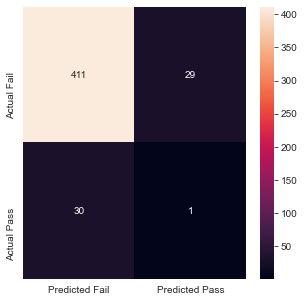

In [153]:
plot_confusion_matrix(y_test,y_pred)

In [154]:
calculate_performance_measures(y_test,y_pred,'LGBM with SMOTE Sampled Data')

Precision Score : 0.48
Recall Score : 0.48
F1-Score: 0.48
Accuracy Score : 0.87


### Observations:
- The model performs well on train and test data, but as per confusion matrix could not predict any `Pass`.
- There are high misclassifications by the model.

#### RandomForest on Random over sampled Dataset with Random Search CV
We will try to fit a `RandomForest` classifier on `over-sampled` data with `RandomizedSearchCV` to tune best hyper-parameters.

In [155]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 50)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = range(2,100,5)
# Minimum number of samples required at each leaf node
min_samples_leaf = range(1,100,10)
# Method of selecting samples for training each tree
bootstrap = [True, False]

# distribution of parameters to search from
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
                'criterion':['gini','entropy']}

In [156]:
rf = RandomForestClassifier() # initialising the RF classifier

# initialising the random search CV for tuning hyper-parameters
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv = 5, verbose=2, random_state=90, n_jobs = -1)

# fit on SMOTE samples
rf_random.fit(X_over, y_over)

# getting the best parameters
rf_random.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_estimators': 463,
 'min_samples_split': 82,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 110,
 'criterion': 'gini',
 'bootstrap': False}

In [157]:
# initialising RF classifier with best hyper-parameters
rf = RandomForestClassifier(n_estimators=463,
 min_samples_split= 82,
 min_samples_leaf=1,
 max_features= 'sqrt',
 max_depth= 110,
 criterion= 'gini',
 bootstrap= False)

rf.fit(X_over, y_over) # fit on train data

RandomForestClassifier(bootstrap=False, max_depth=110, max_features='sqrt',
                       min_samples_split=82, n_estimators=463)

In [158]:
# predict on test data
y_pred = rf.predict(X_test)
predictions['RF with Over Sampled Data'] = y_pred

In [159]:
train_accuracy = rf.score(X_over,y_over)
test_accuracy = rf.score(X_test,y_test)
accuracies['RF with Over Sampled Data'] = [train_accuracy,test_accuracy]

In [160]:
print(f'The accuracy score of model on train data is {round(train_accuracy,4)*100}%')
print(f'The accuracy score of model on test data is {round(test_accuracy,4)*100}%')

The accuracy score of model on train data is 100.0%
The accuracy score of model on test data is 92.99%


In [161]:
print('The classification report is::')
print(classification_report(y_test,y_pred))

The classification report is::
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       440
           1       0.00      0.00      0.00        31

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471



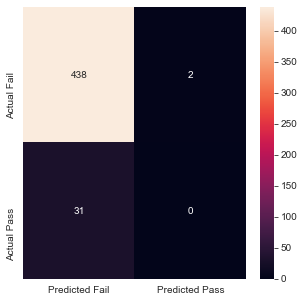

In [162]:
plot_confusion_matrix(y_test,y_pred)

In [163]:
calculate_performance_measures(y_test,y_pred,'RF with Over Sampled Data')

Precision Score : 0.47
Recall Score : 0.50
F1-Score: 0.48
Accuracy Score : 0.93


### Observations:
- The model performs well on train and test data, but as per confusion matrix could not predict any `Pass`.
- There will be high misclassifications by the model.

#### SVM with under-sampled data and Grid Search CV
We will try to fit a `SVM` classifier on `under-sampled` data with `GridSearchCV` to tune best hyper-parameters.

In [164]:
# hyper-parameters to search from
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

# grid search classifier
svm_grid= GridSearchCV(SVC(), param_grid, verbose = 2,cv=5, n_jobs = -1)
 
# fit on over samples
svm_grid.fit(X_over, y_over)

# getting the best parameters
svm_grid.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [165]:
# initialising SVM classifier with best hyper-parameters
svc_cv = SVC(kernel = 'rbf', gamma = 1, C = 1,probability=True)

# fit on train data
svc_cv.fit(X_over,y_over)

SVC(C=1, gamma=1, probability=True)

In [166]:
# predict on test data
y_pred = svc_cv.predict(X_test)
predictions['SVM with Over Sampled Data'] = y_pred

In [167]:
train_accuracy = svc_cv.score(X_over,y_over)
test_accuracy = svc_cv.score(X_test,y_test)
accuracies['SVM with Over Sampled Data'] = [train_accuracy,test_accuracy]

In [168]:
print(f'The accuracy score of model on train data is {round(train_accuracy,4)*100}%')
print(f'The accuracy score of model on test data is {round(test_accuracy,4)*100}%')

The accuracy score of model on train data is 100.0%
The accuracy score of model on test data is 93.42%


In [169]:
print('The classification report is::')
print(classification_report(y_test,y_pred))

The classification report is::
              precision    recall  f1-score   support

           0       0.93      1.00      0.97       440
           1       0.00      0.00      0.00        31

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471



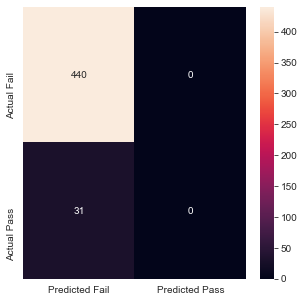

In [170]:
plot_confusion_matrix(y_test,y_pred)

In [171]:
calculate_performance_measures(y_test,y_pred,'SVM with Over Sampled Data')

Precision Score : 0.47
Recall Score : 0.50
F1-Score: 0.48
Accuracy Score : 0.93


### Observations:
- The model performs well in train and test data but as per confusion matrix, it is a bad predictor.
- There are high misclassifications.

### Algorithm Comparison after dimension reduction by PCA

In [172]:
model_df = pd.DataFrame(model_lists, columns = ['Model', 'Accuracy Scores on Test', 'Recall Score', 'Precision Score','F1 Score'])
model_df

Model  Accuracy Scores on Test  \
0                  GNB with Original Data                38.216561   
1             GNB with Under Sampled Data                38.428875   
2  Logistic Regression with Original Data                93.205945   
3            LGBM with SMOTE Sampled Data                87.473461   
4               RF with Over Sampled Data                92.993631   
5              SVM with Over Sampled Data                93.418259   

   Recall Score  Precision Score   F1 Score  
0     47.441349        49.326255  31.846051  
1     49.054252        49.750377  32.177048  
2     49.886364        46.702128  48.241758  
3     48.317449        48.265306  48.290877  
4     49.772727        46.695096  48.184818  
5     50.000000        46.709130  48.298573

#### ROC-AUC plot

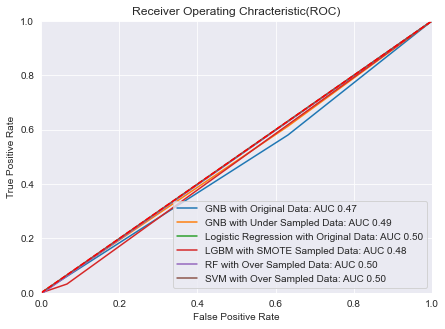

In [173]:
plt.figure(figsize=(7,5))
for model, predicted in predictions.items(): # for each prediction of each of the model
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predicted)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, label='%s: AUC %0.2f'% (model,roc_auc))

plt.plot([0,1],[0,1],'r--') # random model
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Chracteristic(ROC)')
plt.legend(loc='lower right')
plt.show()

In [174]:
accuracy_df = pd.DataFrame(accuracies,index=['Train Accuracy','Test Accuracy'])
accuracy_df

GNB with Original Data  GNB with Under Sampled Data  \
Train Accuracy                0.364051                     0.623288   
Test Accuracy                 0.382166                     0.384289   

                Logistic Regression with Original Data  \
Train Accuracy                                0.513699   
Test Accuracy                                 0.932059   

                LGBM with SMOTE Sampled Data  RF with Over Sampled Data  \
Train Accuracy                      0.999511                   1.000000   
Test Accuracy                       0.874735                   0.929936   

                SVM with Over Sampled Data  
Train Accuracy                    1.000000  
Test Accuracy                     0.934183

### Observations:
- `LogisticRegression` classifier performs well over `test` data with an accuracy of **93%** and reasonable `recall`, but this is a bad predictor as per the confusion matrix as it could not predict the other class well.
- Other models like `Light Gradient Boost`, `Random Forest`, `SVM` do extremely well in `train` data, but drop in `test` data. So the models do not generalize and seem to **over-fit**.
- `PCA` doesn't seem to improve our model building process.
- It seems we will like to go with `Gaussian Naive Bayes` with `un-sampled data`, as that seemed to **generalize** very well.
- And if we want to go for `ensemble`, we can go ahead with `Random Forest` with `random over-sampled data`, and no `PCA`.

### Final Models to use

#### Importing Unseen Data

In [212]:
col = []
for i in final_X.columns.values:
    col.append(int(i))

In [236]:
# read from excel to dataframe
unseen = pd.read_excel('Future_predictions.xlsx')

unseen = unseen[col]
unseen.fillna(0,inplace=True)
row,column = unseen.shape
print('The dataset contains', row, 'rows and', column, 'columns')

The dataset contains 18 rows and 212 columns


In [218]:
# splitting data into train:test as 70:30
X_train, X_test, y_train, y_test = train_test_split(final_X,final_y,test_size=0.30,random_state=seed,stratify=y)

#### Gaussain Naive Bayes on Original Dataset

In [219]:
gnb = GaussianNB() # initialise GNB
gnb.fit(X_train, y_train) # fit the train data

GaussianNB()

In [220]:
y_pred = gnb.predict(unseen)

In [221]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

#### Random Forest with Over-Sampled Data

In [222]:
# Implementing random over sampling
over= RandomOverSampler() # initialising the over sampler
X_over, y_over= over.fit_resample(X_train, y_train)

In [223]:
# initialising RF classifier with best hyper-parameters
rf = RandomForestClassifier(n_estimators=463,
 min_samples_split= 82,
 min_samples_leaf=1,
 max_features= 'sqrt',
 max_depth= 110,
 criterion= 'gini',
 bootstrap= False)

rf.fit(X_over, y_over) # fit on train data

RandomForestClassifier(bootstrap=False, max_depth=110, max_features='sqrt',
                       min_samples_split=82, n_estimators=463)

In [224]:
y_pred = rf.predict(unseen)

In [225]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [237]:
# fitting Random Forest with threshold
# store the predicted probabilities  for failed class 
y_pred_prob = rf.predict_proba(unseen)[:, 1]
# predict fail if the predicted probability is greater than 0.2
pred = binarize([y_pred_prob], 0.2)[0]
unseen['Pass/Fail'] = pred
unseen = unseen[(unseen['Pass/Fail'] == 1)]
unseen.head(18)

0        1          2          3       4         6       7       8  \
0   3030.93  2564.00  2187.7333  1411.1265  1.3602   97.6133  0.1242  1.5005   
13  3051.44  2529.27  2184.4333   877.6266  1.4668  107.8711  0.1240  1.5236   
17  3032.73  2517.79  2270.2556  1258.4558  1.3950  104.8078  0.1207  1.5537   

         9      10  ...     571    572     573  578     582     583     586  \
0   0.0162 -0.0034  ...  2.1113   8.95  0.3157  0.0  0.5005  0.0118  0.0000   
13 -0.0209 -0.0031  ...  2.2354   9.93  0.2785  0.0  0.5034  0.0151  0.0188   
17  0.0220 -0.0027  ...  2.1849  10.26  0.4839  0.0  0.5015  0.0105  0.0184   

       587      589  Pass/Fail  
0   0.0000   0.0000        1.0  
13  0.0098  52.2039        1.0  
17  0.0151  82.0989        1.0  

[3 rows x 213 columns]

### Observations and Conclusions:
- Based on the overall analysis and performances of the model we can go ahead and narrow down the observation that are common to all the validations sets and infer that these are likely to fail. This definetly needs to be checked with a `domain` specialist to get an acceptable threshold limit of the `Type 2` error rate and would be able choose the best performing model based on that.
- As far as `PCA` is considered, the models does better **without** it, `Random Forest with Random overrsampling` and `Gaussian Naive Bayes with original data` gives the best overall results.
- This analysis was a tedious one and could have been improved by better data set and collection and what various features do.
- We would need to involve a very proficient domain expert to come to conclusions on this dataset, because many many things are ambiguous starting from signal types to the unclean data.

#### NOTE:: I wanted to achieve more in this model by visual analysis and try for more hyper-parameter searches but couldn't perform due to hardware restraints. Would be more beneficial if we could have a hands-on of optimization of hardware usage for faster performance.